# Time Series Forecasting of Book Sales

This project explores time series forecasting techniques to model weekly and monthly book sales trends using Nielsen BookScan data. Two well-known titles — *The Alchemist* and *The Very Hungry Caterpillar* — are used as case studies to compare classical, machine learning, deep learning, and hybrid approaches.

Models include:
- Classical methods (Auto ARIMA, SARIMA)
- Machine learning (XGBoost)
- Deep learning (LSTM)
- Hybrid sequential and parallel combinations (SARIMA + LSTM)

Forecast accuracy is evaluated over a 32-week horizon for weekly data and an 8-month horizon for monthly data.

# 1. Importing data and packages

## Installing packages

In interactive notebooks, it's often better to install packages only when they are needed, rather than all at once at the start.  

This approach helps avoid version conflicts and reduces unnecessary package installations, which can cause errors or environment issues.  

For example, the `pmdarima` library used for Auto ARIMA modelling requires a specific, sometimes older, version of `numpy` to work correctly. Installing it prematurely or alongside incompatible versions can cause binary incompatibility errors.  

By installing `pmdarima` only in the modelling section and managing its dependencies carefully, we minimise the risk of such problems and keep the notebook environment cleaner and more stable.

## Importing packages

We import Python libraries as close as possible to where they are actually used. This keeps the notebook lightweight and focused, and helps readers understand dependencies in context.


## Importing data

While options like `gdown` or mounting Drive were available, we chose a simpler approach: manually downloading the files and uploading them into Colab. This avoids external authentication steps and reduces errors during session reset.

Each Excel file contains four sheets, which we read into dictionaries and then combine into single DataFrames. During combination, we tag each row with a `Category` column to preserve the sheet of origin (e.g., Fiction, Non-Fiction).

In [ ]:
import pandas as pd

# Define filenames (must match uploads)
isbn_file = 'ISBN List.xlsx'
sales_file = 'UK Weekly Trended Timeline from 200101_202429.xlsx'

# Load all sheets as dictionaries of DataFrames
isbn_data = pd.read_excel(isbn_file, sheet_name=None)  # Load all sheets
sales_data = pd.read_excel(sales_file, sheet_name=None)

# Combine all sales sheets into one DataFrame, tagging source sheet
combined_sales = pd.concat(
    [df.assign(Category=sheet_name) for sheet_name, df in sales_data.items()],
    ignore_index=True
)

# Combine all ISBN sheets into one DataFrame, tagging source sheet
combined_isbn = pd.concat(
    [df.assign(Category=sheet_name) for sheet_name, df in isbn_data.items()],
    ignore_index=True
)

# Display loaded sheet names for each file
print("ISBN file sheets:", list(isbn_data.keys()))
print("Sales file sheets:", list(sales_data.keys()))

ISBN file sheets: ['F - Adult Fiction', 'S Adult Non-Fiction Specialist', 'T Adult Non-Fiction Trade', "Y Children's, YA & Educational"]
Sales file sheets: ['F Adult Fiction', 'S Adult Non-Fiction Specialist', 'T Adult Non-Fiction Trade', "Y Children's, YA & Educational"]


All sheets from both Excel files have been successfully loaded and combined into two DataFrames. The `Category` column in each combined DataFrame preserves the original sheet name, which may be useful for filtering or analysis later on.

## Inspecting data

After loading, we perform initial checks to understand the structure and contents of the datasets, ensuring readiness for subsequent analysis.

In [ ]:
# Preview all sheets in the sales file
print("📄 Preview: Sales Data")
for name, df in sales_data.items():
    print(f"\nSheet: {name}")
    display(df.head())

# Preview all sheets in the ISBN metadata file
print("\n📄 Preview: ISBN Data")
for name, df in isbn_data.items():
    print(f"\nSheet: {name}")
    display(df.head())

📄 Preview: Sales Data

Sheet: F Adult Fiction


ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   

                     Product Class  
0  F1.1 General & Literary Fiction  
1  F1.1 General & Literary Fiction  
2  F1.1 General & Literary Fiction  
3  F1.1 General & Literary Fiction  
4  F1.1 General & Literary Fiction


Sheet: S Adult Non-Fiction Specialist


ISBN                    Title  \
0  9780003224764  Psychology for AS-level   
1  9780003224764  Psychology for AS-level   
2  9780003224764  Psychology for AS-level   
3  9780003224764  Psychology for AS-level   
4  9780003224764  Psychology for AS-level   

                                          Author  Interval   End Date  Volume  \
0  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200917 2009-04-25       1   
1  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200840 2008-10-04       1   
2  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200838 2008-09-20       1   
3  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200623 2006-06-10       1   
4  Cardwell, Mike & Clark, Liz & Meldrum, Claire    200603 2006-01-21      -1   

   Value    ASP    RRP    Binding              Imprint    Publisher Group  \
0   4.96   4.96  12.99  Paperback  Collins Educational  HarperCollins Grp   
1   0.99   0.99  12.99  Paperback  Collins Educational  HarperCollins Grp   
2   0.99   0.99  12.99  Paperback  Collins Educational  HarperCollins Grp   
3   2.00   2.00  12.99  Paperback  Collins Educational  HarperCollins Grp   
4 -12.99  12.99  12.99  Paperback  Collins Educational  HarperCollins Grp   

                                Product Class  
0  S2.2T Psychology: Textbooks & Study Guides  
1  S2.2T Psychology: Textbooks & Study Guides  
2  S2.2T Psychology: Textbooks & Study Guides  
3  S2.2T Psychology: Textbooks & Study Guides  
4  S2.2T Psychology: Textbooks & Study Guides


Sheet: T Adult Non-Fiction Trade


ISBN              Title        Author  Interval   End Date  \
0  9780002572040  Dog Listener, The  Fennell, Jan    200919 2009-05-09   
1  9780002572040  Dog Listener, The  Fennell, Jan    200918 2009-05-02   
2  9780002572040  Dog Listener, The  Fennell, Jan    200917 2009-04-25   
3  9780002572040  Dog Listener, The  Fennell, Jan    200916 2009-04-18   
4  9780002572040  Dog Listener, The  Fennell, Jan    200914 2009-04-04   

   Volume  Value     ASP    RRP   Binding                   Imprint  \
0       1   2.38  2.3800  14.99  Hardback  HarperCollins Publishers   
1       3   8.42  2.8067  14.99  Hardback  HarperCollins Publishers   
2       6   7.66  1.2767  14.99  Hardback  HarperCollins Publishers   
3       3   3.28  1.0933  14.99  Hardback  HarperCollins Publishers   
4       2   2.48  1.2400  14.99  Hardback  HarperCollins Publishers   

     Publisher Group        Product Class  
0  HarperCollins Grp  T11.4 Pets & Equine  
1  HarperCollins Grp  T11.4 Pets & Equine  
2  HarperCollins Grp  T11.4 Pets & Equine  
3  HarperCollins Grp  T11.4 Pets & Equine  
4  HarperCollins Grp  T11.4 Pets & Equine


Sheet: Y Children's, YA & Educational


ISBN                Title      Author  Interval   End Date  \
0  9780001713031  Cat in the Hat, The  Seuss, Dr.    201433 2014-08-16   
1  9780001713031  Cat in the Hat, The  Seuss, Dr.    200742 2007-10-20   
2  9780001713031  Cat in the Hat, The  Seuss, Dr.    200741 2007-10-13   
3  9780001713031  Cat in the Hat, The  Seuss, Dr.    200738 2007-09-22   
4  9780001713031  Cat in the Hat, The  Seuss, Dr.    200737 2007-09-15   

   Volume  Value   ASP   RRP    Binding  Imprint    Publisher Group  \
0       5  24.95  4.99  4.99  Paperback  Collins  HarperCollins Grp   
1       1   3.99  3.99  4.99  Paperback  Collins  HarperCollins Grp   
2       3  14.97  4.99  4.99  Paperback  Collins  HarperCollins Grp   
3       4  18.96  4.74  4.99  Paperback  Collins  HarperCollins Grp   
4       2   7.98  3.99  4.99  Paperback  Collins  HarperCollins Grp   

                    Product Class  
0  Y4.2 Reference & Home Learning  
1  Y4.2 Reference & Home Learning  
2  Y4.2 Reference & Home Learning  
3  Y4.2 Reference & Home Learning  
4  Y4.2 Reference & Home Learning


📄 Preview: ISBN Data

Sheet: F - Adult Fiction


ISBN                                              Title  \
0  9780330375252                Bridget Jones's Diary (Film Tie-in)   
1  9780140276336                                        White Teeth   
2  9780006512134                                        Man and Boy   
3  9780099280255                                       Brethren,The   
4  9780552998727  Marrying The Mistress:an irresistible and grip...   

             Author                   Imprint    Publisher Group    RRP  \
0   Fielding, Helen                   Picador  Pan Macmillan Grp   8.99   
1      Smith, Zadie         Penguin Books Ltd        Penguin Grp   9.99   
2     Parsons, Tony  HarperCollins Publishers  HarperCollins Grp   8.99   
3     Grisham, John               Arrow Books   Random House Grp   6.99   
4  Trollope, Joanna                Black Swan     Transworld Grp  10.99   

     Binding Publication Date                     Product Class  \
0  Paperback       2001-03-23   F1.1 General & Literary Fiction   
1  Paperback       2001-01-25   F1.1 General & Literary Fiction   
2  Paperback       2000-03-06   F1.1 General & Literary Fiction   
3  Paperback       2000-12-27  F2.1 Crime, Thriller & Adventure   
4  Paperback       2001-02-01   F1.1 General & Literary Fiction   

  Country of Publication  
0         United Kingdom  
1         United Kingdom  
2         United Kingdom  
3         United Kingdom  
4         United Kingdom


Sheet: S Adult Non-Fiction Specialist


ISBN                                              Title  \
0  9781858285511  Rough Guide to the Internet,The:Rough Guides R...   
1  9780099286387                                             Geisha   
2  9780521436809  English Grammar in Use With Answers:Reference ...   
3  9780713996029  Fast Food Nation:What The All-American Meal is...   
4  9781858287393  Rough Guide to the Internet,The:Mini Rough Guides   

              Author                     Imprint     Publisher Group    RRP  \
0  Kennedy, Angus J.                Rough Guides    Rough Guides Grp   6.00   
1        Dalby, Liza                     Vintage    Random House Grp  12.99   
2    Murphy, Raymond  Cambridge University Press  Cambridge U.P. Grp  13.00   
3    Schlosser, Eric                  Allen Lane         Penguin Grp   9.99   
4  Kennedy, Angus J.                Rough Guides    Rough Guides Grp   6.00   

     Binding Publication Date  \
0  Paperback       2000-10-26   
1  Paperback       2000-09-28   
2  Paperback       1994-01-28   
3  Paperback       2001-04-26   
4  Paperback       2001-10-25   

                                       Product Class Country of Publication  
0  S10.1 Computing: Consumer Books ('Technical Tr...         United Kingdom  
1        S3.4 Gender Studies / Gay & Lesbian Studies         United Kingdom  
2                         S1.1T ELT Course Materials         United Kingdom  
3                   S4.6 Industrial Studies: General         United Kingdom  
4  S10.1 Computing: Consumer Books ('Technical Tr...         United Kingdom


Sheet: T Adult Non-Fiction Trade


ISBN                                              Title  \
0  9780752837505                                  Child Called It,A   
1  9780718144845                     Happy Days with the Naked Chef   
2  9780007110919                                     Billy Connolly   
3  9780340766057  McCarthy's Bar:A Journey of Discovery  in Ireland   
4  9780851121246                        Guinness World Records:2002   

               Author                                            Imprint  \
0        Pelzer, Dave  Orion (an Imprint of The Orion Publishing Grou...   
1       Oliver, Jamie                                     Michael Joseph   
2  Stephenson, Pamela                        HarperCollins Entertainment   
3      McCarthy, Pete                                            Sceptre   
4                 NaN                             Guinness World Records   

            Publisher Group    RRP    Binding Publication Date  \
0                 Orion Grp   6.99  Paperback       2009-04-16   
1               Penguin Grp  20.00   Hardback       2001-09-03   
2         HarperCollins Grp  17.99   Hardback       2001-10-01   
3    Hodder & Stoughton Grp  10.99  Paperback       2001-03-15   
4  Guinness Publisher Group  18.00   Hardback       2001-09-28   

                            Product Class Country of Publication  
0            T4.0A Autobiography: General         United Kingdom  
1             T16.0 Food & Drink: General         United Kingdom  
2                T4.1 Biography: The Arts         United Kingdom  
3                     T8.5 Travel Writing         United Kingdom  
4  T2.0 Encyclopedias & General Reference         United Kingdom


Sheet: Y Children's, YA & Educational


ISBN                                              Title  \
0  9780747550990                Harry Potter and the Goblet of Fire   
1  9780747538486            Harry Potter and the Chamber of Secrets   
2  9780747532743           Harry Potter and the Philosopher's Stone   
3  9780747546290           Harry Potter and the Prisoner of Azkaban   
4  9780747554660  Comic Relief: Fantastic Beasts and Where to Fi...   

                             Author                    Imprint  \
0                    Rowling, J. K.  Bloomsbury Publishing PLC   
1                    Rowling, J. K.  Bloomsbury Publishing PLC   
2                    Rowling, J. K.  Bloomsbury Publishing PLC   
3                    Rowling, J. K.  Bloomsbury Publishing PLC   
4  Scamander, Newt & Rowling, J. K.             Obscurus Books   

  Publisher Group   RRP    Binding Publication Date             Product Class  \
0  Bloomsbury Grp  8.99  Paperback       2001-07-06   Y2.1 Children's Fiction   
1  Bloomsbury Grp  6.99  Paperback       1999-05-28   Y2.1 Children's Fiction   
2  Bloomsbury Grp  6.99  Paperback       1997-06-26   Y2.1 Children's Fiction   
3  Bloomsbury Grp  6.99  Paperback       2000-04-01   Y2.1 Children's Fiction   
4  Bloomsbury Grp  2.50  Paperback       2001-03-12  Y2.2 Young Adult Fiction   

  Country of Publication  
0         United Kingdom  
1         United Kingdom  
2         United Kingdom  
3         United Kingdom  
4         United Kingdom

Each sheet has been successfully previewed. We now have visibility into the sales and metadata structures across all four categories.

# 2. Conducting initial data investigation

We now begin our initial exploration of the weekly sales data, addressing key preparation steps such as combining files, checking formats, resampling, and filtering for relevant ISBNs.

## Combine and inspect all sales data

We now combine the sales data from all four sheets into a single DataFrame. During this process, we tag each row with a `Category` column that indicates the source sheet (e.g. Fiction, Non-Fiction). This gives us a unified view of all weekly sales records while preserving the original sheet structure for reference.

Before doing this, we verified that each sheet has identical columns, which makes it possible to safely concatenate them without data loss or misalignment.

Once combined, we can begin inspecting the structure of the data — including its date range and any potential gaps in weekly coverage.


In [ ]:
# Combine all sales sheets into one DataFrame, tagging source sheet
combined_sales = pd.concat(
    [df.assign(Category=sheet_name) for sheet_name, df in sales_data.items()],
    ignore_index=True
)

# Display shape and column names
print("Combined shape:", combined_sales.shape)
print("Columns:", combined_sales.columns.tolist())

# Preview the first few rows
combined_sales.head()

Combined shape: (227224, 14)
Columns: ['ISBN', 'Title', 'Author', 'Interval', 'End Date', 'Volume', 'Value', 'ASP', 'RRP', 'Binding', 'Imprint', 'Publisher Group', 'Product Class', 'Category']


ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   

                     Product Class         Category  
0  F1.1 General & Literary Fiction  F Adult Fiction  
1  F1.1 General & Literary Fiction  F Adult Fiction  
2  F1.1 General & Literary Fiction  F Adult Fiction  
3  F1.1 General & Literary Fiction  F Adult Fiction  
4  F1.1 General & Literary Fiction  F Adult Fiction

In [ ]:
# Check data types of all columns in combined_sales
print("Column data types:")
print(combined_sales.dtypes)

# Explicitly confirm 'End Date' is datetime
print("\nIs 'End Date' datetime64[ns]? ->", combined_sales['End Date'].dtype == 'datetime64[ns]')

Column data types:
ISBN                        int64
Title                      object
Author                     object
Interval                    int64
End Date           datetime64[ns]
Volume                      int64
Value                     float64
ASP                       float64
RRP                       float64
Binding                    object
Imprint                    object
Publisher Group            object
Product Class              object
Category                   object
dtype: object

Is 'End Date' datetime64[ns]? -> True


## Confirm datetime format of `End Date` column

We now convert the `End Date` column to datetime format to prepare for time series analysis. Although `pandas.read_excel()` has already loaded this column as `datetime64[ns]` due to proper formatting in the original Excel file, we explicitly re-apply the conversion using `pd.to_datetime()` to ensure consistency and safeguard against any unexpected format issues in future uploads. This step follows the earlier combination of all sales sheets, where each row was also tagged with its original sheet name using the `Category` column.

In [ ]:
# Convert 'End Date' to datetime format
combined_sales['End Date'] = pd.to_datetime(combined_sales['End Date'], errors='raise')

# Confirm the conversion
print(combined_sales['End Date'].dtype)
combined_sales['End Date'].head()

datetime64[ns]


0   2005-04-02
1   2005-01-22
2   2004-05-29
3   2004-04-10
4   2004-01-24
Name: End Date, dtype: datetime64[ns]

The `End Date` column was already in `datetime64[ns]` format, but has now been explicitly re-confirmed using `pd.to_datetime()`. All entries were parsed cleanly, with no errors or missing values.

## Understand weekly alignment and missing weeks

We now examine the structure of the `End Date` column to understand the temporal resolution and consistency of the data. Specifically, we want to check whether the dates follow a regular weekly pattern and whether any weeks are missing.

In [ ]:
# Check the date range
print("Earliest date:", combined_sales['End Date'].min())
print("Latest date:", combined_sales['End Date'].max())

# Count number of unique dates
print("Number of unique dates:", combined_sales['End Date'].nunique())

# Preview sorted unique dates to assess spacing
unique_dates = combined_sales['End Date'].sort_values().unique()
print("First 10 dates:", unique_dates[:10])
print("Last 10 dates:", unique_dates[-10:])

Earliest date: 2001-01-06 00:00:00
Latest date: 2024-07-20 00:00:00
Number of unique dates: 1202
First 10 dates: <DatetimeArray>
['2001-01-06 00:00:00', '2001-01-13 00:00:00', '2001-01-20 00:00:00',
 '2001-01-27 00:00:00', '2001-02-03 00:00:00', '2001-02-10 00:00:00',
 '2001-02-17 00:00:00', '2001-02-24 00:00:00', '2001-03-03 00:00:00',
 '2001-03-10 00:00:00']
Length: 10, dtype: datetime64[ns]
Last 10 dates: <DatetimeArray>
['2024-05-18 00:00:00', '2024-05-25 00:00:00', '2024-06-01 00:00:00',
 '2024-06-08 00:00:00', '2024-06-15 00:00:00', '2024-06-22 00:00:00',
 '2024-06-29 00:00:00', '2024-07-06 00:00:00', '2024-07-13 00:00:00',
 '2024-07-20 00:00:00']
Length: 10, dtype: datetime64[ns]


The earliest date in the dataset is 2001-01-06 and the latest is 2024-07-20, covering over 23 years. There are 1,202 unique `End Date` values. When inspecting the first and last 10 entries, the dates appear to progress in weekly steps, always falling on a Saturday. This suggests the data is intended to follow a weekly schedule.

However, the total number of calendar weeks between the start and end date is greater than 1,202 — confirming that **some weeks are missing**. This occurs when no sales were recorded in a given week, and such weeks are simply absent from the dataset. As a result, the data is not at fixed intervals, and special handling will be needed to account for these gaps in any time series modelling.

## Resample and fill in missing values with 0

We now prepare to resample the sales data into a regular weekly time series. This step is crucial because the original dataset only includes weeks **where sales occurred** — meaning that **weeks with zero sales are missing** entirely. This makes the data irregular and unsuitable for time series models without resampling.

Before doing this, it is essential to understand **how the weeks are defined**.

When inspecting the unique values in the `End Date` column, we noticed that all dates fall on **Saturdays** — e.g., `2001-01-06`, `2001-01-13`, `2001-01-20`, and so on. This indicates that the data is **already aligned to weekly intervals ending on Saturday**.

This insight matters because of how the `resample()` method in pandas interprets the weekly frequency:

| Frequency     | Meaning                        | Week Ends On |
|---------------|--------------------------------|--------------|
| `'W'`         | Weekly (default is Sunday)     | Sunday       |
| `'W-SAT'`     | Weekly, explicitly ending Sat  | Saturday     |

If we simply use `resample('W')`, it will assume weeks ending on **Sunday**, which creates a **one-day misalignment** with the actual data — effectively shifting all weeks by one day and potentially splitting real-world weeks across two groups.

To preserve the structure and integrity of the dataset, we therefore **resample using `'W-SAT'`**, which exactly matches the dataset’s natural weekly rhythm.

This step ensures that:
- Every week from the earliest to latest date is represented.
- Missing weeks (i.e. no sales recorded) are filled with zero.
- The temporal structure is retained without artificial shifting.

In [ ]:
# Set 'End Date' as index
combined_sales.set_index('End Date', inplace=True)
print(combined_sales.index.name)

End Date


In [ ]:
# Build a complete weekly date range from min to max date.
full_weeks = pd.date_range(
    start=combined_sales.index.min(),
    end=combined_sales.index.max(),
    freq='W-SAT'  # Weekly on Saturdays
)

In [ ]:
# Sum Volume per week:
weekly_volume = combined_sales['Volume'].resample('W-SAT').sum()

# Check the shape and type
print("Weekly volume shape:", weekly_volume.shape)
print("Index type:", type(weekly_volume.index))
print("Index frequency:", weekly_volume.index.freq)

# Preview the first and last rows
print(weekly_volume.head())
print(weekly_volume.tail())

Weekly volume shape: (1229,)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index frequency: <Week: weekday=5>
End Date
2001-01-06    342115
2001-01-13    341100
2001-01-20    353237
2001-01-27    417880
2001-02-03    439908
Freq: W-SAT, Name: Volume, dtype: int64
End Date
2024-06-22    4496
2024-06-29    4627
2024-07-06    5123
2024-07-13    5257
2024-07-20    5937
Freq: W-SAT, Name: Volume, dtype: int64


We confirm that the resampling has worked as intended. The resulting `weekly_volume` series has 1,229 rows, each representing a single Saturday from 2001-01-06 to 2024-07-20. The index is a `DatetimeIndex` with a weekly frequency (`Week: weekday=5`), where 5 corresponds to Saturday.

Interestingly, a sharp decline in weekly sales volume is visible when comparing the early 2000s to recent weeks. For example, the week ending 2001-02-03 had over 430,000 units sold, while the most recent week (2024-07-20) recorded under 6,000 units. This long-term trend will be important context for our modelling decisions.

## Filter and visualise all valid ISBNs to explore sales patterns

To ensure consistency in handling book identifiers, we now convert the `ISBN` column to string format. While ISBNs may appear numeric, they are identifiers rather than quantities — so treating them as strings avoids issues with leading zeros or mathematical misinterpretation.

In [ ]:
# Convert ISBN to string
combined_sales['ISBN'] = combined_sales['ISBN'].astype(str)

# Check data types of all columns (and check ISBN conversion)
print("Column data types:")
print(combined_sales.dtypes)

Column data types:
ISBN                object
Title               object
Author              object
Interval             int64
Volume               int64
Value              float64
ASP                float64
RRP                float64
Binding             object
Imprint             object
Publisher Group     object
Product Class       object
Category            object
dtype: object


We now identify the ISBNs with sales activity beyond 2024-07-01. This allows us to focus the analysis on books that remain active in the most recent period of the dataset. These ISBNs will serve as our candidates for further investigation and visualisation.

In [ ]:
df_after_cutoff = combined_sales[combined_sales.index > '2024-07-01']
isbn_filtered = df_after_cutoff['ISBN'].unique()

# Show summary
print("Number of ISBNs with activity after 2024-07-01:", len(isbn_filtered))
print("Filtered ISBNs:")
print(isbn_filtered)

Number of ISBNs with activity after 2024-07-01: 61
Filtered ISBNs:
['9780006512134' '9780006514091' '9780006514213' '9780006550433'
 '9780007101887' '9780099244721' '9780099771517' '9780140276336'
 '9780140285215' '9780140295962' '9780261103252' '9780349112763'
 '9780349113609' '9780349114033' '9780552145053' '9780552145060'
 '9780552997348' '9780552998000' '9780552998444' '9780552998482'
 '9780552998727' '9780722532935' '9780747268161' '9780749397548'
 '9780099286387' '9780006531203' '9780091816971' '9780091867775'
 '9780099285823' '9780099286578' '9780099422587' '9780099428558'
 '9780140259506' '9780140275421' '9780140276619' '9780140281293'
 '9780140294231' '9780224060875' '9780330355667' '9780340696767'
 '9780340766057' '9780340786055' '9780552145954' '9780552997034'
 '9780593048153' '9780719559792' '9780749395698' '9781841150437'
 '9780006647553' '9780241003008' '9780440864141' '9780440864554'
 '9780744523232' '9780752844299' '9780752846576' '9781841460307'
 '9781841460406' '97818

Although the weekly data ends on 2024-07-20, a total of 61 ISBNs show continued sales activity beyond 1 July 2024. These active titles have been extracted for further exploration and visualisation to understand their recent sales dynamics.

We now investigate which ISBNs have sales activity after 1 July 2024. This filtering step helps identify titles that remain active in the most recent period of the dataset. A total of 61 such ISBNs were found, and these will form the basis for our weekly sales volume plots in the next section, allowing us to explore recent sales trends and longevity.

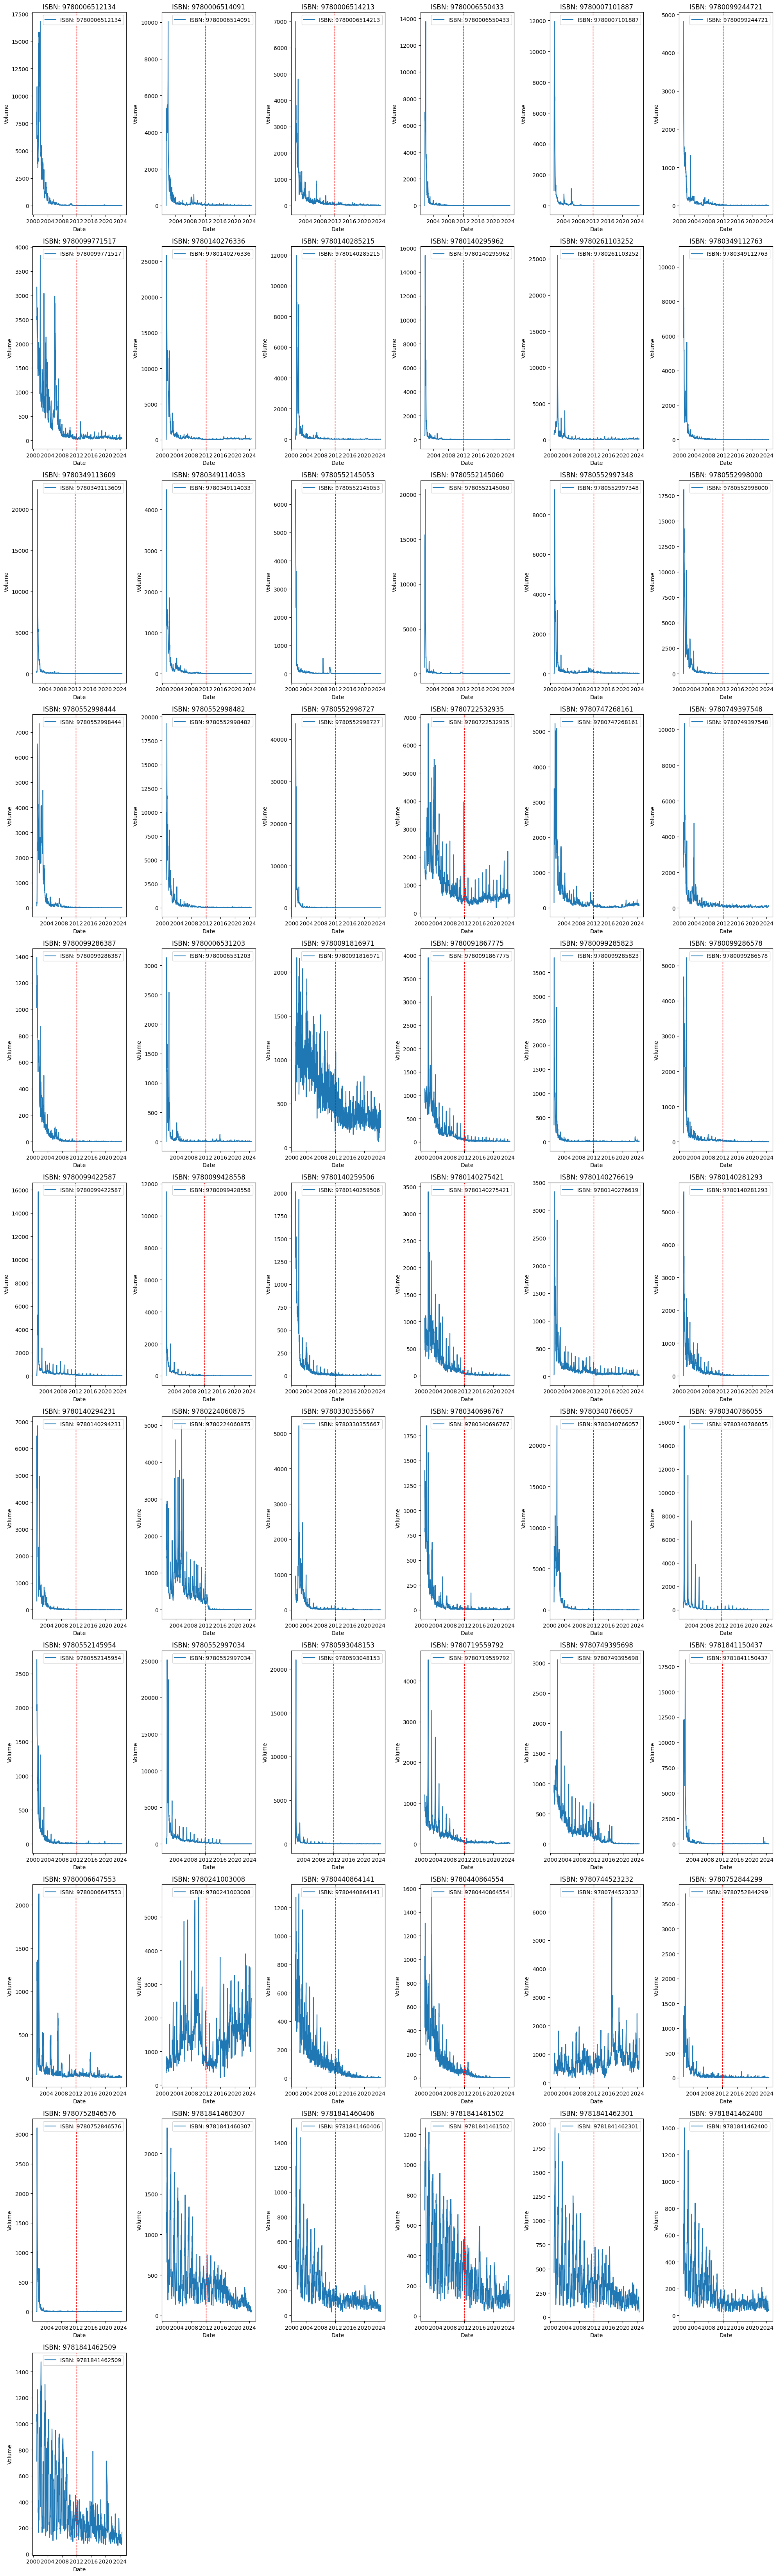

In [ ]:
import matplotlib.pyplot as plt

# Set up subplot grid
num_isbns = len(isbn_filtered)
cols = 6
rows = (num_isbns // cols) + (1 if num_isbns % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = axes.flatten()

# Loop and plot
for idx, isbn in enumerate(isbn_filtered):
    isbn_data = combined_sales[combined_sales['ISBN'] == isbn]
    axes[idx].plot(isbn_data.index, isbn_data['Volume'], label=f'ISBN: {isbn}')
    axes[idx].axvline(pd.to_datetime('2012-01-01'), color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f'ISBN: {isbn}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Volume')
    axes[idx].legend()

# Remove unused subplots
for idx in range(num_isbns, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()

Most ISBNs exhibited a strong launch spike, followed by a rapid decay in weekly sales. This classic "long tail" pattern suggests that initial release campaigns drove most of the volume, with some titles continuing to sell in low numbers for many years. A few ISBNs showed bumps in later years, potentially due to reissues, adaptations, or renewed interest.

These plots visually validated the time series structure and informed modelling choices. For example, long-term forecasting would need to handle sharp seasonality early on and flat tails later.

To examine whether the patterns differed across time, a red vertical line was added at 2012-01-01, dividing the first 12 years (2000–2012) from the second (2012–2024). No clear structural shift was observed across this boundary. Most ISBNs followed the same decay pattern, with strong early sales and long-term persistence. Any bumps in the later years appeared isolated and were likely due to specific events rather than a change in trend. This suggests stable consumer behaviour across both periods.

## Focused analysis on two key ISBNs: The Alchemist and The Very Hungry Caterpillar

We now isolate the two target books — *The Alchemist* and *The Very Hungry Caterpillar* — by identifying their associated ISBNs from the metadata. Only data from after 2012-01-01 is retained for further analysis, in line with the project scope.


### Find all ISBNs matching each title

In [ ]:
# Show all titles containing 'caterpillar' (case-insensitive)
caterpillar_titles = combined_isbn[combined_isbn['Title'].str.contains('caterpillar', case=False, na=False)]['Title'].unique()
print("Titles containing 'caterpillar':")
for t in sorted(caterpillar_titles):
    print("-", t)

# Same for 'alchemist'
alchemist_titles = combined_isbn[combined_isbn['Title'].str.contains('alchemist', case=False, na=False)]['Title'].unique()
print("\nTitles containing 'alchemist':")
for t in sorted(alchemist_titles):
    print("-", t)


Titles containing 'caterpillar':
- Very Hungry Caterpillar,The
- Very Hungry Caterpillar,The:The Very Hungry Caterpillar

Titles containing 'alchemist':
- Alchemist,The


In [ ]:
# Filter combined_isbn using the previously extracted title lists
filtered_isbn_rows = combined_isbn[
    combined_isbn['Title'].isin(caterpillar_titles.tolist() + alchemist_titles.tolist())
]

# Get ISBNs for each book from that filtered DataFrame
caterpillar_isbns = filtered_isbn_rows[filtered_isbn_rows['Title'].isin(caterpillar_titles)]['ISBN'].astype(str).unique()
alchemist_isbns = filtered_isbn_rows[filtered_isbn_rows['Title'].isin(alchemist_titles)]['ISBN'].astype(str).unique()

print("Caterpillar ISBNs:", caterpillar_isbns)
print("Alchemist ISBNs:", alchemist_isbns)


Caterpillar ISBNs: ['9780241003008' '9780140500875']
Alchemist ISBNs: ['9780722532935']


The Alchemist has a single matching ISBN: `9780722532935`, which simplifies the selection.

The Very Hungry Caterpillar has two matching ISBNs: `9780241003008` and `9780140500875`.

We will now calculate post-2012 sales volume for each to determine which one to retain for modelling.

### Filter and sum post-2012 sales

We now filter the sales dataset to only include weeks after 2012-01-01. For each of the matched ISBNs, we compute total sales volume over this period to support selection of the most representative record for each title.

In [ ]:
print(combined_sales.head())

                     ISBN            Title         Author  Interval  Volume  \
End Date                                                                      
2005-04-02  9780002261821  One For My Baby  Parsons, Tony    200513       1   
2005-01-22  9780002261821  One For My Baby  Parsons, Tony    200503       1   
2004-05-29  9780002261821  One For My Baby  Parsons, Tony    200422       1   
2004-04-10  9780002261821  One For My Baby  Parsons, Tony    200415       2   
2004-01-24  9780002261821  One For My Baby  Parsons, Tony    200404       2   

            Value    ASP    RRP   Binding                   Imprint  \
End Date                                                              
2005-04-02  15.99  15.99  15.99  Hardback  HarperCollins Publishers   
2005-01-22  15.99  15.99  15.99  Hardback  HarperCollins Publishers   
2004-05-29  11.19  11.19  15.99  Hardback  HarperCollins Publishers   
2004-04-10  27.18  13.59  15.99  Hardback  HarperCollins Publishers   
2004-01-24  22.48  1

In [ ]:
# Filter to data after 2012-01-01
df_post2012 = combined_sales[combined_sales.index > '2012-01-01']

# Check post-2012 volume per Caterpillar ISBN
for isbn in caterpillar_isbns:
    volume = df_post2012[df_post2012['ISBN'] == isbn]['Volume'].sum()
    print(f"Caterpillar ISBN {isbn} total volume: {volume}")

# Check post-2012 volume for Alchemist ISBN
for isbn in alchemist_isbns:
    volume = df_post2012[df_post2012['ISBN'] == isbn]['Volume'].sum()
    print(f"Alchemist ISBN {isbn} total volume: {volume}")


Caterpillar ISBN 9780241003008 total volume: 883534
Caterpillar ISBN 9780140500875 total volume: 2
Alchemist ISBN 9780722532935 total volume: 345907


The post-2012 sales volumes confirm the appropriate ISBNs to retain for each title:

- *The Very Hungry Caterpillar*: ISBN `9780241003008` accounts for the overwhelming majority of sales (883,534 units). The alternative ISBN `9780140500875` has only 2 units sold and will be excluded from further analysis.
- *The Alchemist*: Only one ISBN is present (`9780722532935`), with 345,907 units sold.

We will proceed with just these two ISBNs: `9780241003008` and `9780722532935`.

### Filter to just the two selected ISBNs

We now filter the full post-2012 weekly dataset to retain only the two selected ISBNs:  
`9780241003008` (*The Very Hungry Caterpillar*) and `9780722532935` (*The Alchemist*).

In [ ]:
# Define the final ISBNs
final_isbns = ['9780241003008', '9780722532935']
alchemist_isbn = '9780722532935'
caterpillar_isbn = '9780241003008'

# Filter the main post-2012 dataset
df_target_books = df_post2012[df_post2012['ISBN'].isin(final_isbns)]

# Quick check
df_target_books['ISBN'].unique()

array(['9780722532935', '9780241003008'], dtype=object)

The filtered dataset now includes only the two selected ISBNs. This ensures that all further analysis focuses exclusively on *The Alchemist* and *The Very Hungry Caterpillar* from 2012 onwards.

In [ ]:
df_target_books['Title'].unique()


array(['Alchemist, The', 'Very Hungry Caterpillar, The'], dtype=object)

Both titles are now correctly formatted. Our dataset is now ready for plotting.

### Plot each time series

We now visualise weekly sales volume for each book from 2012 onwards. This helps confirm that the sales series are well-formed and suitable for time series modelling.


--- Very Hungry Caterpillar, The (9780241003008) ---
            Volume
End Date          
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
            Volume
End Date          
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574


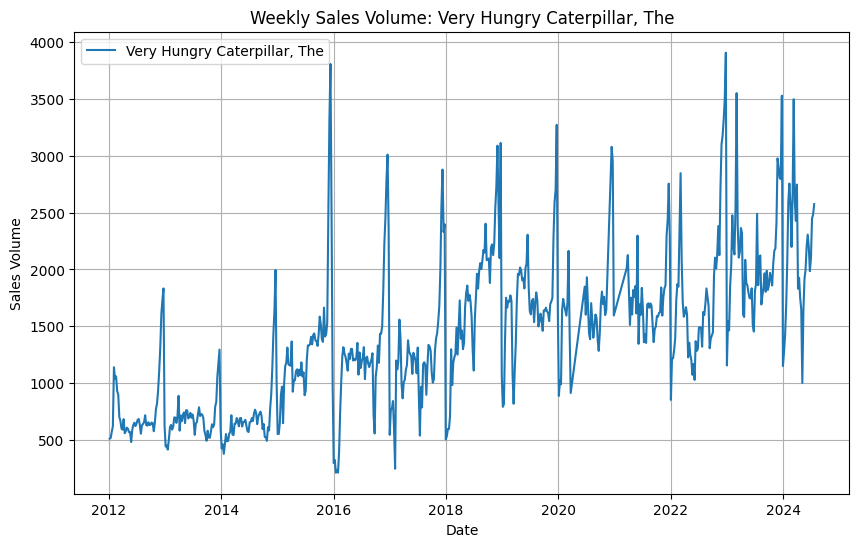


--- Alchemist, The (9780722532935) ---
            Volume
End Date          
2012-01-07     518
2012-01-14     533
2012-01-21     475
2012-01-28     514
2012-02-04     591
            Volume
End Date          
2024-06-22     590
2024-06-29     627
2024-07-06     672
2024-07-13     510
2024-07-20     408


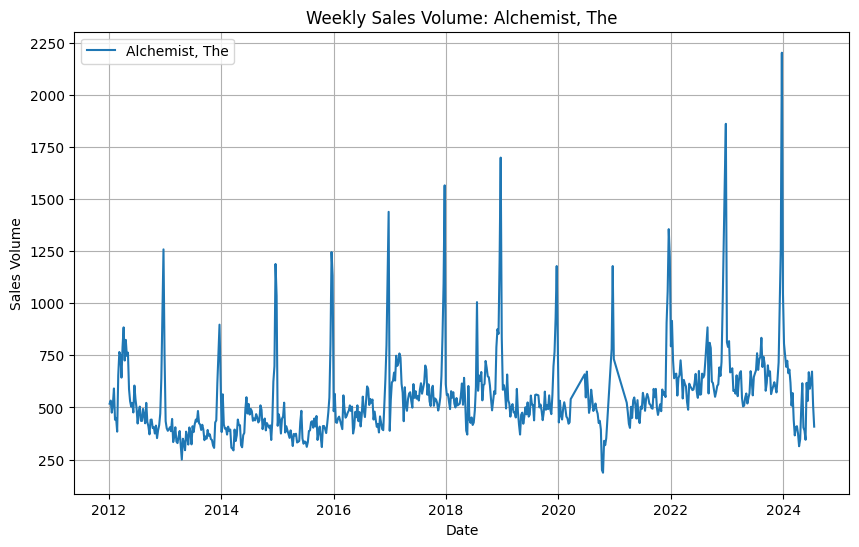

In [ ]:
import matplotlib.pyplot as plt

for isbn in final_isbns:
    book_data = df_target_books[df_target_books['ISBN'] == isbn].sort_index()
    title = book_data['Title'].unique()[0]

    print(f"\n--- {title} ({isbn}) ---")
    print(book_data[['Volume']].head(5))      # first 5 rows by date
    print(book_data[['Volume']].tail(5))      # last 5 rows by date

    plt.figure(figsize=(10, 6))
    plt.plot(book_data.index, book_data['Volume'], label=title)
    plt.title(f'Weekly Sales Volume: {title}')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.grid(True)
    plt.legend()
    plt.show()

The plots confirm that both books have long, regular post-2012 sales histories:

- *The Very Hungry Caterpillar* shows strong upward momentum with repeated seasonal spikes, likely linked to school terms or holiday gifting.
- *The Alchemist* displays flatter sales overall but consistent yearly peaks, suggesting periodic re-discovery or curricular relevance.

Both time series are well-formed and suitable for time series modelling.

## Take a CSV checkpoint

To manage memory usage and enable a clean restart, we save each book’s filtered sales volume data to separate CSV checkpoint files.  
These files contain only the weekly sales volume indexed by date, allowing us to reload minimal data quickly and efficiently for modelling.

In [ ]:
# Save minimal CSVs per book with only Volume and date index
df_alchemist = df_target_books[df_target_books['ISBN'] == alchemist_isbn][['Volume']].copy()
df_alchemist.index.name = 'End Date'

df_caterpillar = df_target_books[df_target_books['ISBN'] == caterpillar_isbn][['Volume']].copy()
df_caterpillar.index.name = 'End Date'

# Order before saving
df_alchemist = df_alchemist.sort_index()
df_caterpillar = df_caterpillar.sort_index()

print("Alchemist head:\n", df_alchemist.head())
print("Alchemist tail:\n", df_alchemist.tail())
print("\n")
print("Caterpillar head:\n", df_caterpillar.head())
print("Caterpillar tail:\n", df_caterpillar.tail())

# # Then save only if confirmed ordered (or else sort first)
# if not df_alchemist.index.is_monotonic_increasing:
#     df_alchemist = df_alchemist.sort_index()
# if not df_caterpillar.index.is_monotonic_increasing:
#     df_caterpillar = df_caterpillar.sort_index()

df_alchemist.to_csv('checkpoint_df_alchemist.csv')
df_caterpillar.to_csv('checkpoint_df_caterpillar.csv')
#Reload using:
# df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', index_col='End Date', parse_dates=True)
# df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', index_col='End Date', parse_dates=True)


Alchemist head:
             Volume
End Date          
2012-01-07     518
2012-01-14     533
2012-01-21     475
2012-01-28     514
2012-02-04     591
Alchemist tail:
             Volume
End Date          
2024-06-22     590
2024-06-29     627
2024-07-06     672
2024-07-13     510
2024-07-20     408


Caterpillar head:
             Volume
End Date          
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Caterpillar tail:
             Volume
End Date          
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574


# 3. Classical techniques

In this section, we apply classical time series techniques to our selected books. These methods help us understand underlying patterns like trend and seasonality, assess stationarity, and identify appropriate models for forecasting.

## Perform decomposition


We begin classical analysis by decomposing the sales data for both books.  
This helps reveal underlying trend, seasonal patterns, and residual noise, informing model selection.

Before decomposition, we ensure the sales volume series has a continuous weekly index.  Filtering by ISBN and date can introduce missing weeks, leading to gaps (NaNs) in the series.  To maintain consistency and honour earlier data preparation steps, we explicitly reindex the series to a full weekly range and fill any missing values with 0 volume.  This preserves the true zero-sales weeks and avoids errors in the decomposition process.

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

full_index = pd.date_range(start='2012-01-01', end=df_target_books.index.max(), freq='W-SAT')

def prepare_series_for_decompose(df, isbn):
    book_data = df[df['ISBN'] == isbn]['Volume']
    book_data = book_data.reindex(full_index, fill_value=0)

    # Check order is ascending
    print(f"Is data monotonic increasing for ISBN {isbn}? {book_data.index.is_monotonic_increasing}")

    # Optional: print first and last few dates and volumes to verify
    print(f"Head:\n{book_data.head()}")
    print(f"Tail:\n{book_data.tail()}")

    return book_data


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def decompose_book_large_plot(df, isbn):
    book_series = prepare_series_for_decompose(df, isbn)
    book_title = df[df['ISBN'] == isbn]['Title'].iloc[0]  # Get book title

    result = seasonal_decompose(book_series, model='additive', period=52)

    plt.figure(figsize=(14, 5))
    plt.plot(book_series.index, book_series, label='Original')
    plt.title(f'Original Series - {book_title}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(result.trend.index, result.trend, label='Trend', color='orange')
    plt.title(f'Trend Component - {book_title}')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(result.seasonal.index, result.seasonal, label='Seasonal', color='green')
    plt.title(f'Seasonal Component - {book_title}')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(result.resid.index, result.resid, label='Residual', color='red')
    plt.title(f'Residual Component - {book_title}')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

    return result

Is data monotonic increasing for ISBN 9780722532935? True
Head:
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64


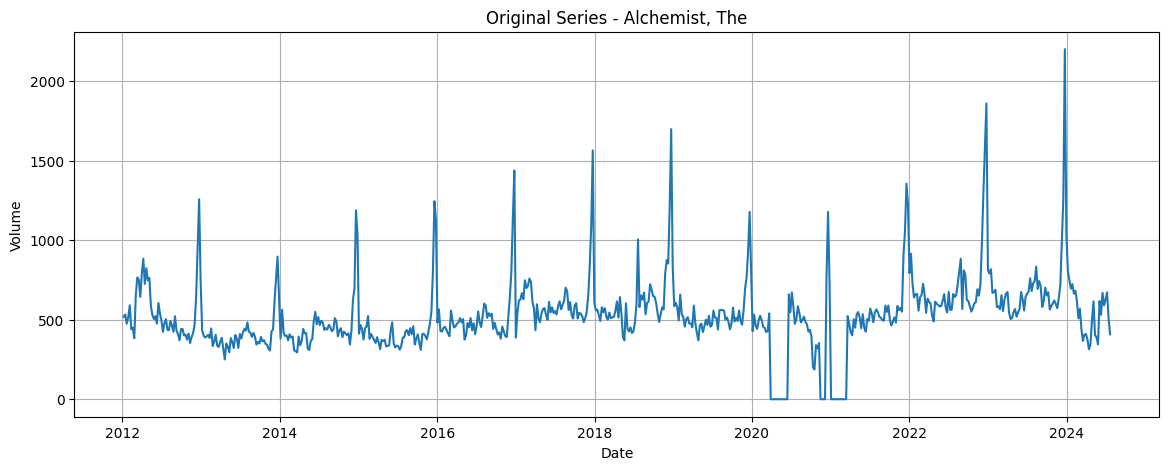

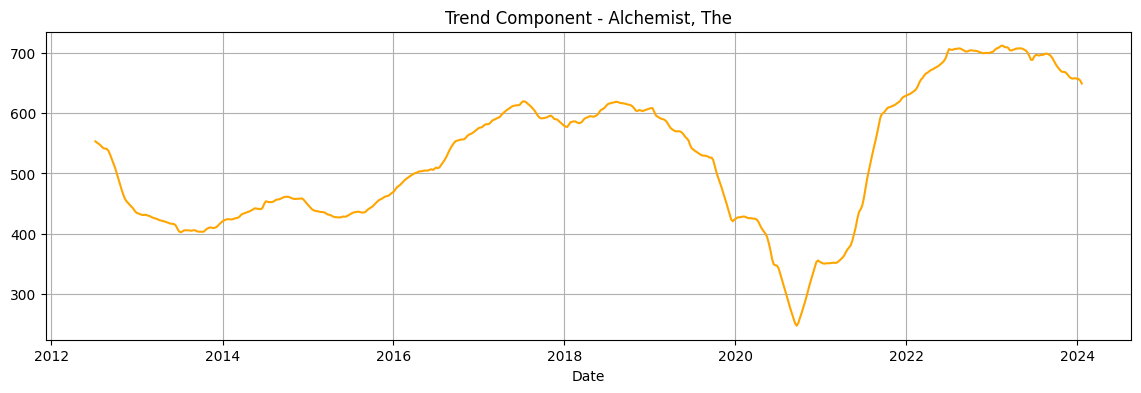

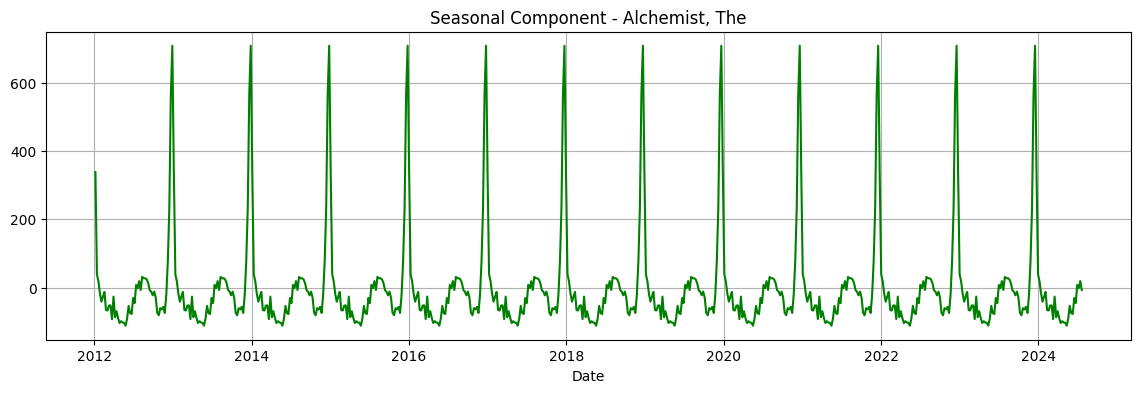

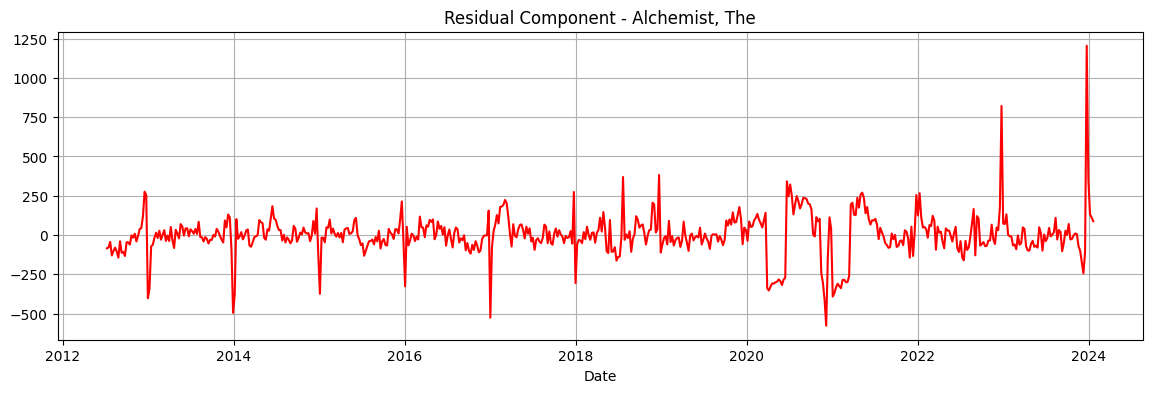

Is data monotonic increasing for ISBN 9780241003008? True
Head:
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64


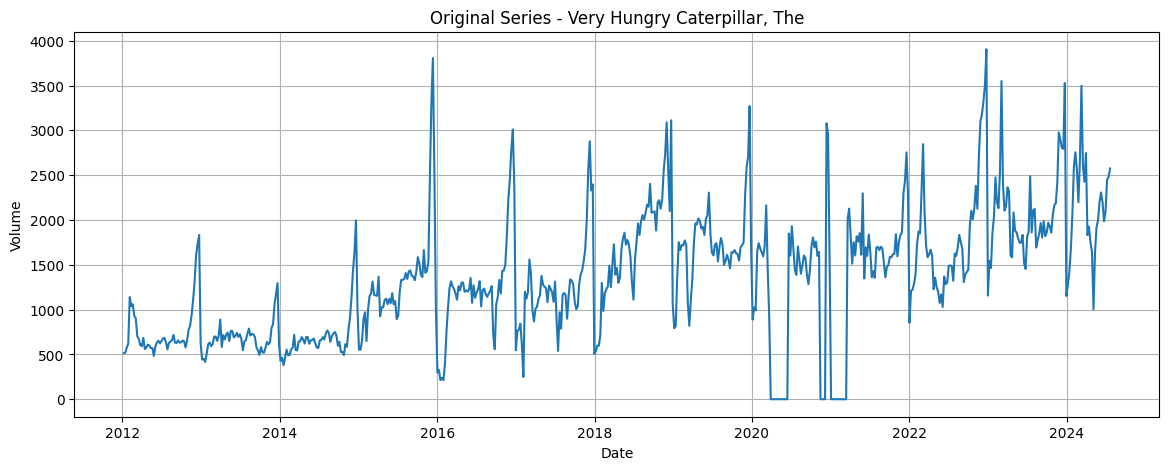

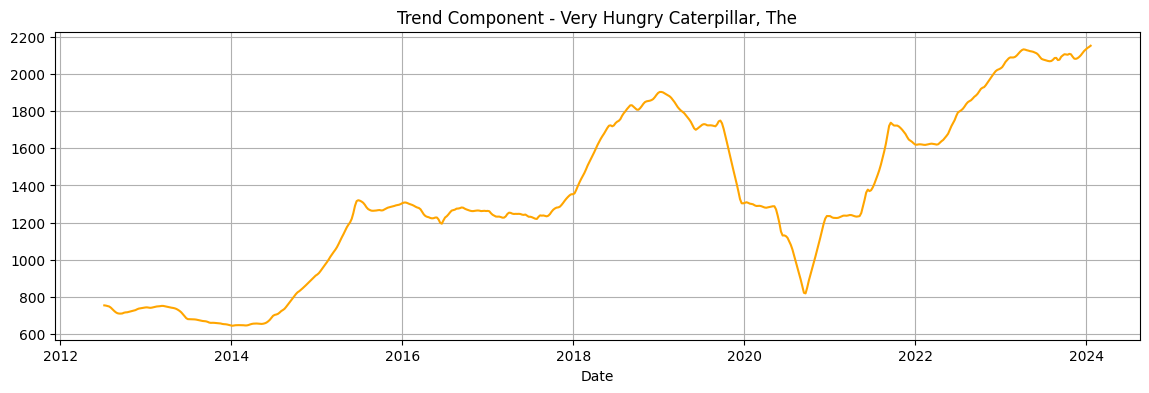

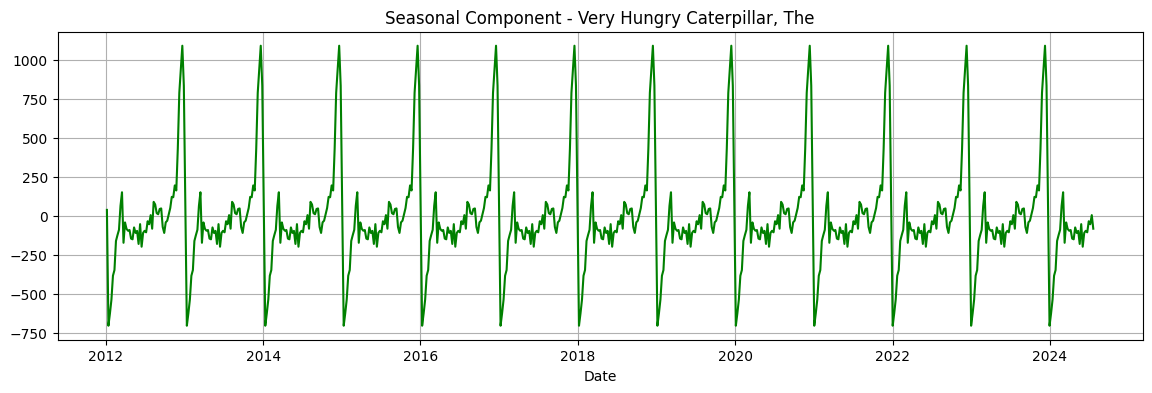

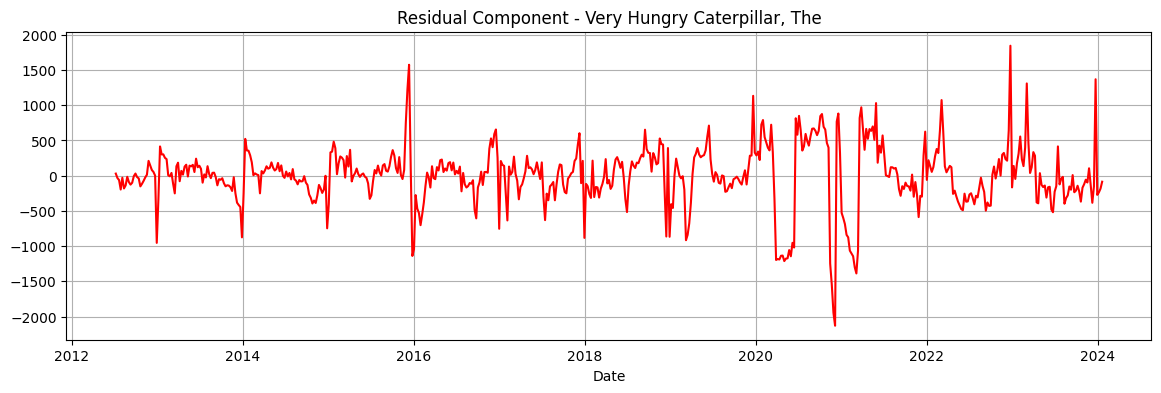

In [ ]:
# Usage:
decomp_alchemist = decompose_book_large_plot(df_target_books, '9780722532935')
decomp_caterpillar = decompose_book_large_plot(df_target_books, '9780241003008')

The seasonal decomposition reveals distinct patterns for both books:

- **Trend**: Both series exhibit clear long-term trends, with noticeable dips around 2020, possibly reflecting external disruptions such as the COVID-19 pandemic. The trend for *The Very Hungry Caterpillar* shows a stronger upward trajectory compared to *The Alchemist*.

- **Seasonality**: Pronounced annual seasonality is evident in both books, with *The Very Hungry Caterpillar* displaying sharper and more consistent seasonal peaks, likely linked to school calendars and holiday gift periods. The seasonal component appears nearly identical year-on-year because classical additive decomposition assumes a fixed, repeating seasonal pattern that represents the average effect across all years.

- **Residuals**: The residual components for both books generally hover around zero, indicating that the additive decomposition captures the majority of the systematic variation. Occasional outliers suggest episodic irregular events or noise.

Overall, these decompositions confirm the suitability of additive seasonal models for forecasting.

## Perform ACF and PACF

We now examine the autocorrelation (ACF) and partial autocorrelation (PACF) functions for both books.  
These plots help identify the presence and extent of autocorrelation in the data, guiding model order selection for ARIMA.

Is data monotonic increasing for ISBN 9780722532935? True
Head:
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64


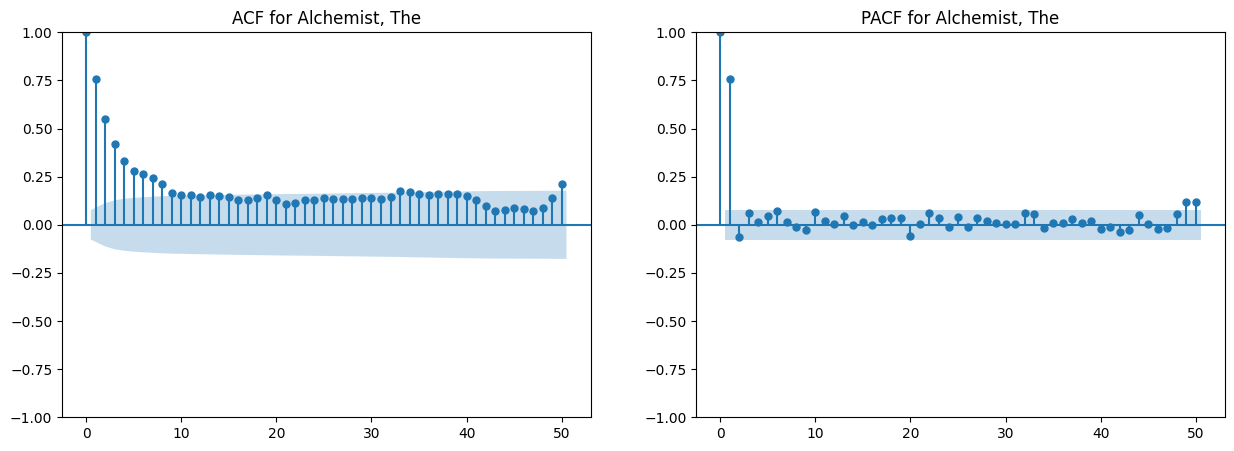

Is data monotonic increasing for ISBN 9780241003008? True
Head:
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64


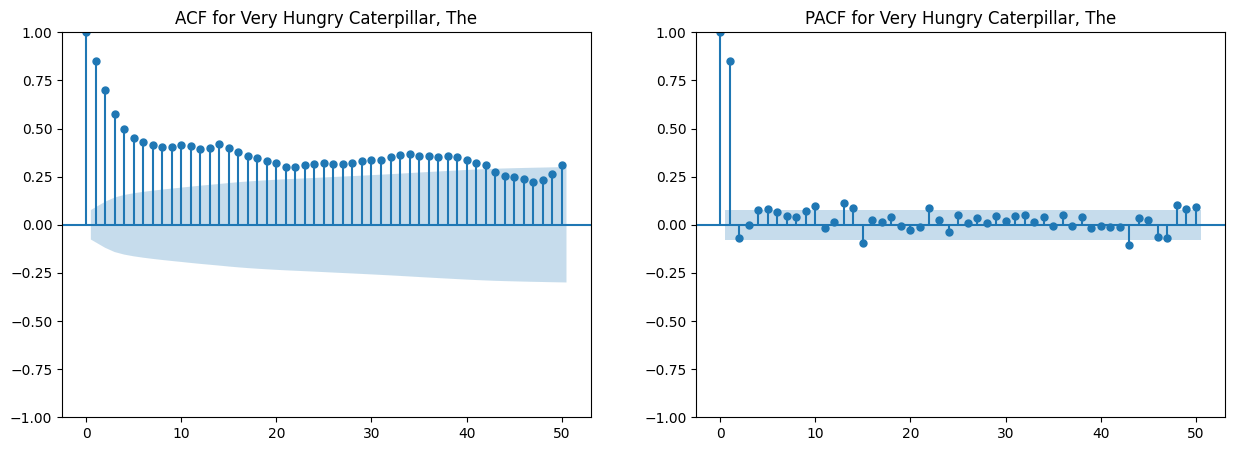

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(df, isbn):
    book_series = prepare_series_for_decompose(df, isbn)

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    plot_acf(book_series, ax=axes[0], lags=50)
    axes[0].set_title(f'ACF for {df[df["ISBN"] == isbn]["Title"].iloc[0]}')

    plot_pacf(book_series, ax=axes[1], lags=50, method='ywm')
    axes[1].set_title(f'PACF for {df[df["ISBN"] == isbn]["Title"].iloc[0]}')

    plt.show()

plot_acf_pacf(df_target_books, '9780722532935')  # The Alchemist
plot_acf_pacf(df_target_books, '9780241003008')  # The Very Hungry Caterpillar

The ACF plots for both books exhibit a gradual exponential decay, which is indicative of strong autocorrelation and non-stationarity in the series.  
The PACF plots show a sharp cutoff after lag 1 or 2, suggesting that an autoregressive model of order 1 or 2 (AR(1) or AR(2)) could be appropriate.  

*The Very Hungry Caterpillar* displays slightly stronger autocorrelation persisting across higher lags compared to *The Alchemist*, indicating potentially more complex temporal dependencies.  
These ACF and PACF patterns will guide the parameter selection for ARIMA modelling in the subsequent steps.

## Check stationarity

Stationarity is a key assumption for many time series models, including ARIMA.  
We apply the Augmented Dickey-Fuller (ADF) test to check whether the sales volume series for each book is stationary.  
Non-stationary series may require differencing before modelling.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title):
    print(f'ADF Test for {title}:')
    result = adfuller(series)
    print(f'  Test Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  Used Lag: {result[2]}')
    print(f'  Number of Observations: {result[3]}')
    if result[1] < 0.05:
        print("  => Strong evidence to reject the null hypothesis (series is stationary)")
    else:
        print("  => Weak evidence to reject the null hypothesis (series is non-stationary)")
    print()

for isbn in ['9780722532935', '9780241003008']:
    series = prepare_series_for_decompose(df_target_books, isbn)
    title = df_target_books[df_target_books['ISBN'] == isbn]['Title'].iloc[0]
    adf_test(series, title)

Is data monotonic increasing for ISBN 9780722532935? True
Head:
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64
ADF Test for Alchemist, The:
  Test Statistic: -8.2959
  p-value: 0.0000
  Used Lag: 2
  Number of Observations: 652
  => Strong evidence to reject the null hypothesis (series is stationary)

Is data monotonic increasing for ISBN 9780241003008? True
Head:
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64
ADF Test for Very Hungry Caterpillar, The:
  Test Statistic: -3.0605
  p-value: 0.0296
  Used Lag: 14
  Number of Observations: 640
  => S

The Augmented Dickey-Fuller test indicates that both series are stationary.

*The Alchemist* shows very strong evidence (p-value near zero), while *The Very Hungry Caterpillar* also passes the stationarity test with a p-value below 0.05.

These results suggest that differencing may not be necessary when fitting ARIMA models.

## Perform Auto ARIMA (Unsuccessful due to Memory Limits)



We now fit Auto ARIMA models to the sales data for each book.  
The models will use all data from 2012-01-01 up to the final 32 weeks, which serve as the forecasting horizon.  
Reasonable bounds on ARIMA parameters are set to guide the model selection.

In [ ]:
# Force reinstall numpy and pmdarima together, ensuring compatible versions
!pip install numpy==1.24.3 pmdarima --quiet


In [ ]:
import pandas as pd
import pmdarima as pm

# Load individual CSVs
df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', index_col=0, parse_dates=True)
# df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', index_col=0, parse_dates=True)

def prepare_series(df):
    full_index = pd.date_range(start='2012-01-01', end=df.index.max(), freq='W-SAT')
    series = df['Volume'].reindex(full_index, fill_value=0)
    return series

# Prepare series
series_alchemist = prepare_series(df_alchemist)
series_caterpillar = prepare_series(df_caterpillar)

# Set forecast horizon
forecast_horizon = 32

# Fit Auto ARIMA for Alchemist
train_alchemist = series_alchemist[:-forecast_horizon]
model_alchemist = pm.auto_arima(
    train_alchemist,
    seasonal=True,
    m=52,
    start_p=0,
    max_p=1,
    start_q=0,
    max_q=1,
    start_P=0,
    max_P=1,
    start_Q=0,
    max_Q=1,
    d=None,
    D=1,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

# # Fit Auto ARIMA for Caterpillar
# train_caterpillar = series_caterpillar[:-forecast_horizon]
# model_caterpillar = pm.auto_arima(
#     train_caterpillar,
#     seasonal=True,
#     m=52,
#     start_p=0,
#     max_p=1,
#     start_q=0,
#     max_q=1,
#     start_P=0,
#     max_P=1,
#     start_Q=0,
#     max_Q=1,
#     d=None,
#     D=1,
#     stepwise=True,
#     trace=True,
#     error_action='ignore',
#     suppress_warnings=True
# )


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=7759.493, Time=1.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=7053.362, Time=67.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=63.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[52]             : AIC=7759.415, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=7140.458, Time=5.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=7044.576, Time=69.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=7042.664, Time=39.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=27.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=7015.696, Time=58.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=7131.984, Time=7.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=7016.144, Time=78.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=7027.503, Time=44.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[52]             : AIC=7014.375, Time=37.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[52]             : AIC=7130.003, Time=1.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[52]             : AIC=7014.707, Time=56.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[52]             : AIC=7025.753, Time=19.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[52]             : AIC=inf, Time=36.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Save model summary to text file
with open('model_alchemist_summary.txt', 'w') as f:
    f.write(model_alchemist.summary().as_text())

# Save forecast for final 32 weeks
forecast_alch = model_alchemist.predict(n_periods=forecast_horizon)
import pandas as pd
pd.DataFrame(forecast_alch, columns=['Forecast']).to_csv('forecast_alchemist.csv')

# Save residuals
residuals_alch = model_alchemist.resid()
pd.DataFrame(residuals_alch, columns=['Residuals']).to_csv('residuals_alchemist.csv')


NameError: name 'model_alchemist' is not defined

## Handling Memory Limitations During Auto ARIMA Fitting

During the Auto ARIMA fitting for *The Alchemist*, the session crashed with an out-of-memory error despite using Google Colab’s cloud resources. This illustrates the heavy RAM demands of Auto ARIMA’s exhaustive parameter search, especially on weekly data with complex seasonality.

To mitigate this, we attempted a session restart to clear all variables and free memory. After restarting, we reloaded the filtered datasets from CSV checkpoint files to continue modelling with a clean environment:

```python
import pandas as pd

df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', index_col='End Date', parse_dates=True)
df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', index_col='End Date', parse_dates=True)
```

Despite this approach, memory constraints persisted. Consequently, we shifted to manually fitting SARIMA models with carefully selected parameters based on prior diagnostic analysis. This manual approach reduces memory use by avoiding the resource-heavy automated search, while still capturing essential seasonal and trend dynamics.

The following section demonstrates manual SARIMA fitting as a practical workaround.

## Manual SARIMA Model Fitting

Due to memory limitations encountered with Auto ARIMA, we manually fit SARIMA models with parameters informed by prior ACF, PACF, and stationarity analyses.  
This manual approach reduces resource consumption by avoiding exhaustive parameter searches, while still capturing the essential seasonal and trend dynamics in the data.

We save the model summary, forecasts for the final 32 weeks, and residuals for future evaluation and visualization.

### Load weekly sales data if not already loaded

In [ ]:
import pandas as pd

# Load weekly sales data if not already loaded
if 'df_alchemist' not in globals():
    df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', index_col='End Date', parse_dates=True)

if 'df_caterpillar' not in globals():
    df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', index_col='End Date', parse_dates=True)

### Helper function: prepare_series()

Before fitting the SARIMA models, we prepare the sales volume series by reindexing it to a continuous weekly date range aligned to Saturdays (W-SAT). Missing weeks with no sales are filled with zeros to ensure consistent time intervals for modelling. The function also prints basic checks to confirm the series order and sample values.

In [ ]:
def prepare_series(df):
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W-SAT')
    series = df['Volume'].reindex(full_index, fill_value=0)

    print(f"Is data monotonic increasing? {series.index.is_monotonic_increasing}")
    print(f"Head:\n{series.head()}")
    print(f"Tail:\n{series.tail()}")

    return series

### Manual SARIMA Model Fitting for *The Alchemist*

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Define forecast horizon and prepare series (assumes df_alchemist loaded)
forecast_horizon = 32
series_alchemist = prepare_series(df_alchemist)

# Insert check here:
print("Series monotonic increasing (ascending order)?", series_alchemist.index.is_monotonic_increasing)
print("Series head:\n", series_alchemist.head())
print("Series tail:\n", series_alchemist.tail())

train_alchemist = series_alchemist[:-forecast_horizon]

Is data monotonic increasing? True
Head:
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64
Series monotonic increasing (ascending order)? True
Series head:
 2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Series tail:
 2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64


In [ ]:
# Define list of SARIMA parameters to try: (order, seasonal_order)
sarima_params = [
    ((1, 0, 1), (1, 1, 1, 52)),
    ((0, 1, 1), (1, 1, 0, 52)),
    ((1, 1, 0), (0, 1, 1, 52)),
    ((1, 0, 0), (1, 1, 1, 52))
]

for order, seasonal_order in sarima_params:
    print(f"Fitting SARIMA{order}x{seasonal_order}")
    model = sm.tsa.statespace.SARIMAX(
        train_alchemist,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Summary filename
    summary_filename = f"sarima_alch_summary_p{order[0]}d{order[1]}q{order[2]}_P{seasonal_order[0]}D{seasonal_order[1]}Q{seasonal_order[2]}s{seasonal_order[3]}.txt"
    with open(summary_filename, 'w') as f:
        f.write(model.summary().as_text())

    # Forecast filename
    forecast = model.get_forecast(steps=forecast_horizon)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    forecast_df = pd.DataFrame({
        'Forecast': forecast_mean,
        'Lower CI': conf_int.iloc[:, 0],
        'Upper CI': conf_int.iloc[:, 1]
    })
    forecast_filename = summary_filename.replace('summary', 'forecast').replace('.txt', '.csv')
    forecast_df.to_csv(forecast_filename)

    # Residuals filename
    residuals_df = pd.DataFrame(model.resid, columns=['Residuals'])
    residuals_filename = summary_filename.replace('summary', 'residuals').replace('.txt', '.csv')
    residuals_df.to_csv(residuals_filename)

    print(f"Saved summary, forecast, and residuals for SARIMA{order}x{seasonal_order}\n")

Fitting SARIMA(1, 0, 1)x(1, 1, 1, 52)
Saved summary, forecast, and residuals for SARIMA(1, 0, 1)x(1, 1, 1, 52)

Fitting SARIMA(0, 1, 1)x(1, 1, 0, 52)
Saved summary, forecast, and residuals for SARIMA(0, 1, 1)x(1, 1, 0, 52)

Fitting SARIMA(1, 1, 0)x(0, 1, 1, 52)
Saved summary, forecast, and residuals for SARIMA(1, 1, 0)x(0, 1, 1, 52)

Fitting SARIMA(1, 0, 0)x(1, 1, 1, 52)
Saved summary, forecast, and residuals for SARIMA(1, 0, 0)x(1, 1, 1, 52)



### SARIMA Model Comparison for *The Alchemist*



| Model                         | AIC     | BIC     | Ljung-Box p-value | Notes                              |
|-------------------------------|---------|---------|-------------------|----------------------------------|
| SARIMA(0,1,1)(1,1,[],52)      | 6401.49 | 6414.24 | 0.16              | Good residual independence       |
| SARIMA(1,0,0)(1,1,[1],52)     | 6404.78 | 6421.78 | 0.00              | Ljung-Box p-value low (possible residual autocorrelation)    |
| SARIMA(1,0,1)(1,1,1,52)       | 6361.62 | 6382.86 | 0.36              | Best AIC and residuals look well-behaved   |
| SARIMA(1,1,0)(0,1,[1],52)     | 6403.99 | 6416.74 | 0.19              | Reasonable AIC and residual diagnostics     |

The SARIMA(1,0,1)(1,1,1,52) model has the lowest AIC and a favorable Ljung-Box p-value, indicating a better fit with more independent residuals.

All models show non-normal residuals according to the Jarque-Bera test, which is common in real-world sales data.

**Recommendation:** Use SARIMA(1,0,1)(1,1,1,52) as the primary classical model for forecasting *The Alchemist*, noting that model selection was constrained by manual parameter tuning due to memory limitations.

### Manual SARIMA Model Fitting for *The Very Hungry Caterpillar*

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Prepare the time series for SARIMA
series_caterpillar = prepare_series(df_caterpillar)

# Define forecast horizon
forecast_horizon = 32

# Training data excludes the last 32 weeks
train_caterpillar = series_caterpillar[:-forecast_horizon]

# Define list of SARIMA parameters to try: (order, seasonal_order)
sarima_params_cat = [
    ((1, 0, 1), (1, 1, 1, 52)),
    ((0, 1, 1), (1, 1, 0, 52)),
    ((1, 1, 0), (0, 1, 1, 52)),
    ((1, 0, 0), (1, 1, 1, 52))
]

for order, seasonal_order in sarima_params_cat:
    print(f"Fitting SARIMA{order}x{seasonal_order} for Caterpillar")
    model = sm.tsa.statespace.SARIMAX(
        train_caterpillar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Summary filename
    summary_filename = f"sarima_cat_summary_p{order[0]}d{order[1]}q{order[2]}_P{seasonal_order[0]}D{seasonal_order[1]}Q{seasonal_order[2]}s{seasonal_order[3]}.txt"
    with open(summary_filename, 'w') as f:
        f.write(model.summary().as_text())

    # Forecast filename
    forecast = model.get_forecast(steps=forecast_horizon)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    forecast_df = pd.DataFrame({
        'Forecast': forecast_mean,
        'Lower CI': conf_int.iloc[:, 0],
        'Upper CI': conf_int.iloc[:, 1]
    })
    forecast_filename = summary_filename.replace('summary', 'forecast').replace('.txt', '.csv')
    forecast_df.to_csv(forecast_filename)

    # Residuals filename
    residuals_df = pd.DataFrame(model.resid, columns=['Residuals'])
    residuals_filename = summary_filename.replace('summary', 'residuals').replace('.txt', '.csv')
    residuals_df.to_csv(residuals_filename)

    print(f"Saved summary, forecast, and residuals for SARIMA{order}x{seasonal_order} Caterpillar\n")

Is data monotonic increasing? True
Head:
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Tail:
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64
Fitting SARIMA(1, 0, 1)x(1, 1, 1, 52) for Caterpillar
Saved summary, forecast, and residuals for SARIMA(1, 0, 1)x(1, 1, 1, 52) Caterpillar

Fitting SARIMA(0, 1, 1)x(1, 1, 0, 52) for Caterpillar
Saved summary, forecast, and residuals for SARIMA(0, 1, 1)x(1, 1, 0, 52) Caterpillar

Fitting SARIMA(1, 1, 0)x(0, 1, 1, 52) for Caterpillar
Saved summary, forecast, and residuals for SARIMA(1, 1, 0)x(0, 1, 1, 52) Caterpillar

Fitting SARIMA(1, 0, 0)x(1, 1, 1, 52) for Caterpillar
Saved summary, forecast, and residuals for SARIMA(1, 0, 0)x(1, 1, 1, 52) Caterpillar



### SARIMA Model Comparison for *The Very Hungry Caterpillar*

| Model                         | AIC     | BIC     | Ljung-Box p-value | Notes                              |
|-------------------------------|---------|---------|-------------------|----------------------------------|
| SARIMA(0,1,1)(1,1,[],52)      | 7647.26 | 7660.01 | 0.77              | Good residual independence       |
| SARIMA(1,0,0)(1,1,[1],52)     | 7575.16 | 7592.16 | 0.33              | Reasonable residual diagnostics   |
| SARIMA(1,0,1)(1,1,1,52)       | 7563.00 | 7584.24 | 0.75              | Best AIC and good residuals       |
| SARIMA(1,1,0)(0,1,[1],52)     | 7597.34 | 7610.09 | 0.81              | Good residual independence        |

The SARIMA(1,0,1)(1,1,1,52) model has the lowest AIC and favorable Ljung-Box p-value, indicating the best fit with independent residuals.

All models exhibit non-normal residuals per the Jarque-Bera test, which is common in real-world sales data.

**Recommendation:** Use SARIMA(1,0,1)(1,1,1,52) as the primary classical model for forecasting *The Very Hungry Caterpillar*, acknowledging that manual tuning was necessary due to resource constraints.

## Evaluate Best Models for Both Books

In this section, we evaluate the best classical SARIMA models for *The Alchemist* and *The Very Hungry Caterpillar*.  
These models were selected based on lowest AIC and diagnostic checks during manual tuning, constrained by memory limitations.

We analyse residuals, generate forecasts for the final 32 weeks, plot the results with confidence intervals, and compare forecasts against actual sales.


### Evaluation of Best Model for *The Alchemist*



The selected model is SARIMA(1,0,1)(1,1,1,52), chosen for its lowest AIC and diagnostic performance.

We will examine residuals to assess model fit, then forecast and compare the final 32 weeks to actual sales.


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define forecast horizon
forecast_horizon = 32

# Confirm data ordering and preview before training
print("Is series_alchemist index monotonic increasing?", series_alchemist.index.is_monotonic_increasing)
print("Series head:\n", series_alchemist.head())
print("Series tail:\n", series_alchemist.tail())

Is series_alchemist index monotonic increasing? True
Series head:
 2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
Series tail:
 2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64


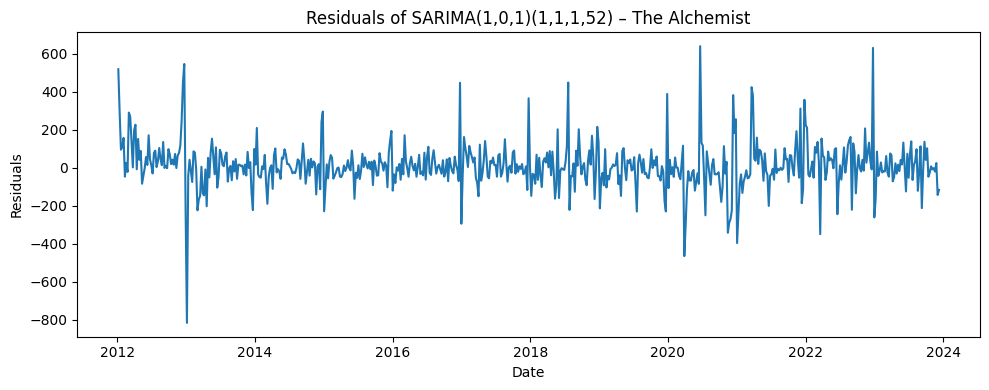

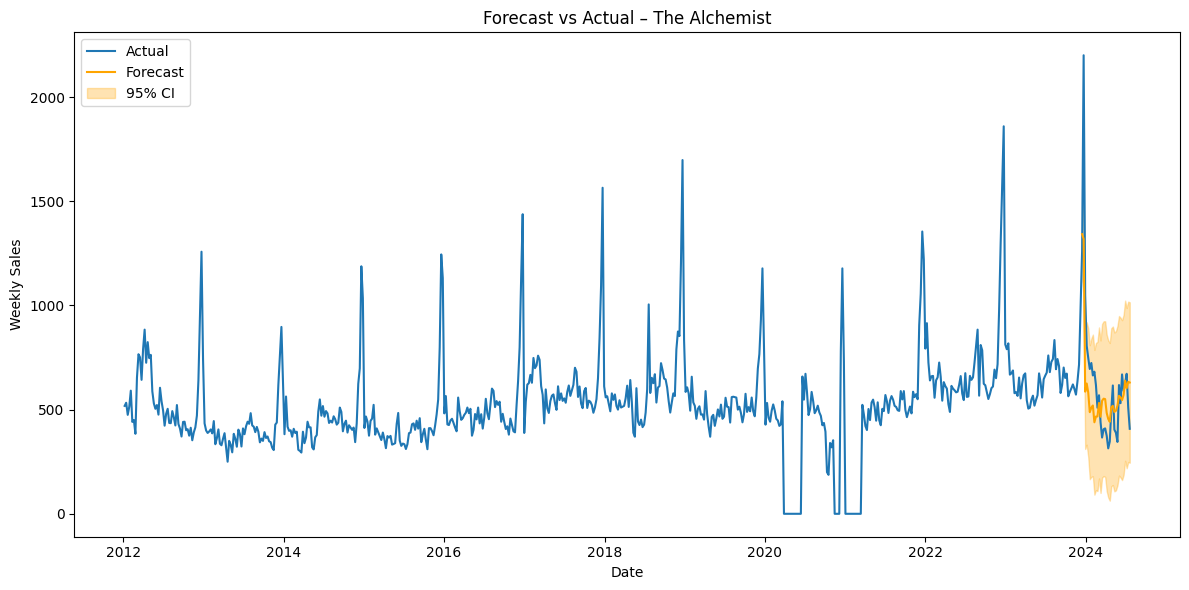

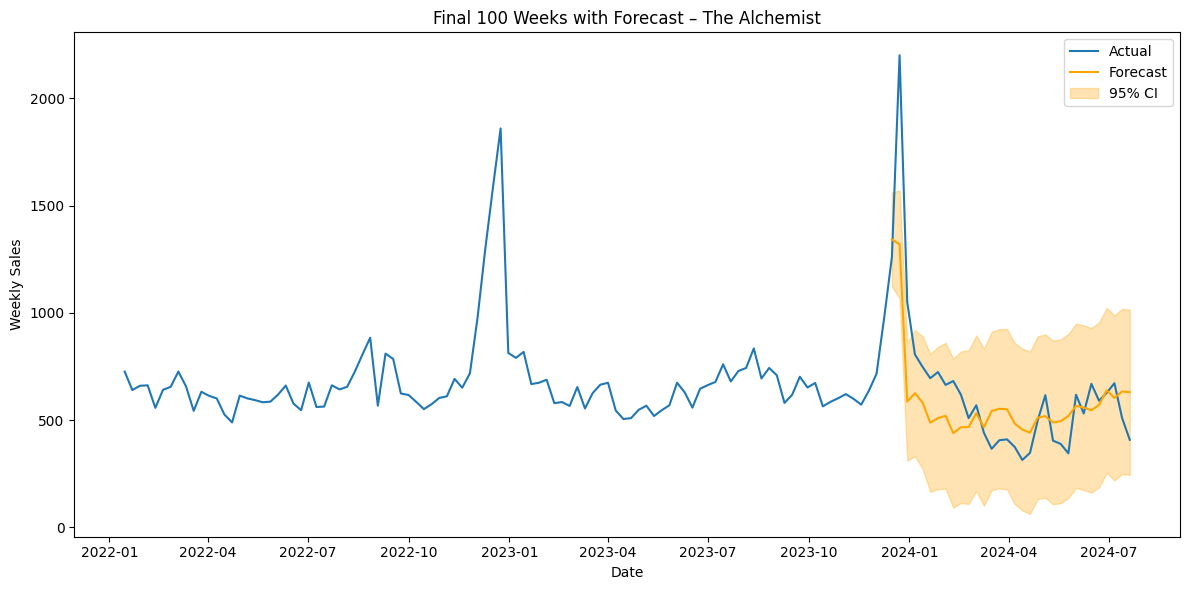

The Alchemist (Weekly) - MAE: 149.09501832585113
The Alchemist (Weekly) - MAPE: 23.758973113442778


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

train_alchemist = series_alchemist[:-forecast_horizon]
test_alchemist = series_alchemist[-forecast_horizon:]

# Fit SARIMA(1,0,1)(1,1,1,52)
model_alchemist = SARIMAX(
    train_alchemist,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Plot residuals
residuals = model_alchemist.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA(1,0,1)(1,1,1,52) – The Alchemist')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# Forecast the final 32 weeks
forecast_result = model_alchemist.get_forecast(steps=forecast_horizon)
mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(series_alchemist.index, series_alchemist, label='Actual')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.title('Forecast vs Actual – The Alchemist')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed-in forecast plot for better visual clarity
plt.figure(figsize=(12, 6))
start_zoom = series_alchemist.index[-(forecast_horizon + 100)]  # last ~100 weeks before forecast
plt.plot(series_alchemist.loc[start_zoom:], label='Actual')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.title('Final 100 Weeks with Forecast – The Alchemist')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate MAE and MAPE for The Alchemist (Weekly)
mae_alchemist_weekly = mean_absolute_error(test_alchemist, mean_forecast)
mape_alchemist_weekly = mean_absolute_percentage_error(test_alchemist, mean_forecast) * 100

print("The Alchemist (Weekly) - MAE:", mae_alchemist_weekly)
print("The Alchemist (Weekly) - MAPE:", mape_alchemist_weekly)


The residuals show no clear trend or autocorrelation, indicating that the SARIMA model has captured the main seasonal and structural components of the series. Most residuals fluctuate around zero, though there are occasional spikes, particularly earlier in the time series.

The full forecast plot shows the model tracking overall sales levels and seasonal dips reasonably well, but underestimates isolated peaks in demand. These sharp spikes are likely caused by external factors such as promotions or campaigns, which are difficult for classical models to anticipate.

A focused plot of the **final 100 weeks** provides a clearer view of model performance in the forecast window. Here, the forecast captures the general direction of sales but again misses the scale of the largest peak. The confidence intervals widen appropriately over time, reflecting rising uncertainty.

Quantitatively, the model achieved a Mean Absolute Error (MAE) of approximately **149.1** and a Mean Absolute Percentage Error (MAPE) of **23.76%** over the 32-week forecast period. These metrics indicate that while the model provides a stable and interpretable forecast under regular seasonal conditions, it is less accurate in predicting sudden, high-magnitude deviations caused by non-seasonal events.


### Evaluation of Best Model for *The Very Hungry Caterpillar*

This section uses SARIMA(1,0,1)(1,1,1,52), re-fitted to all data up to the final 32 weeks.
We examine residuals to assess model fit, then forecast and compare the final 32 weeks to actual values.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define forecast horizon
forecast_horizon = 32

# Confirm data ordering and preview before training
print("Is series_caterpillar index monotonic increasing?", series_caterpillar.index.is_monotonic_increasing)
print("Series head:\n", series_caterpillar.head())
print("Series tail:\n", series_caterpillar.tail())

Is series_caterpillar index monotonic increasing? True
Series head:
 2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Series tail:
 2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64


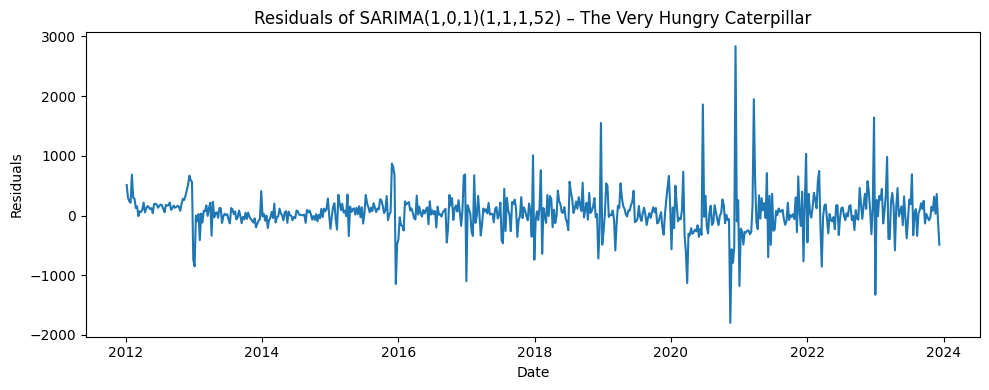

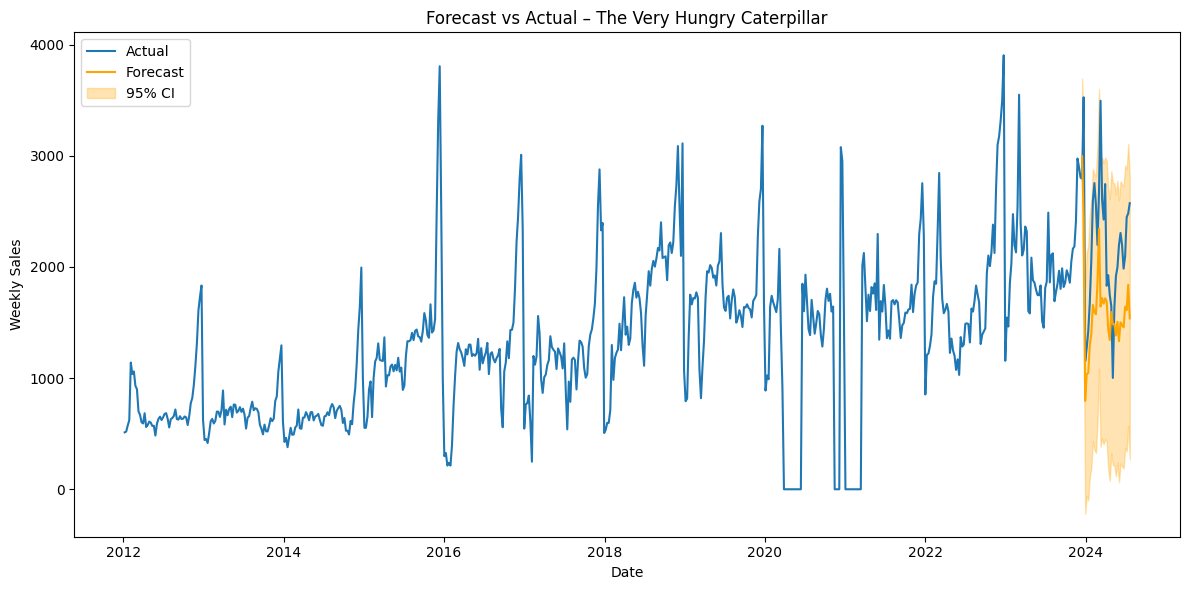

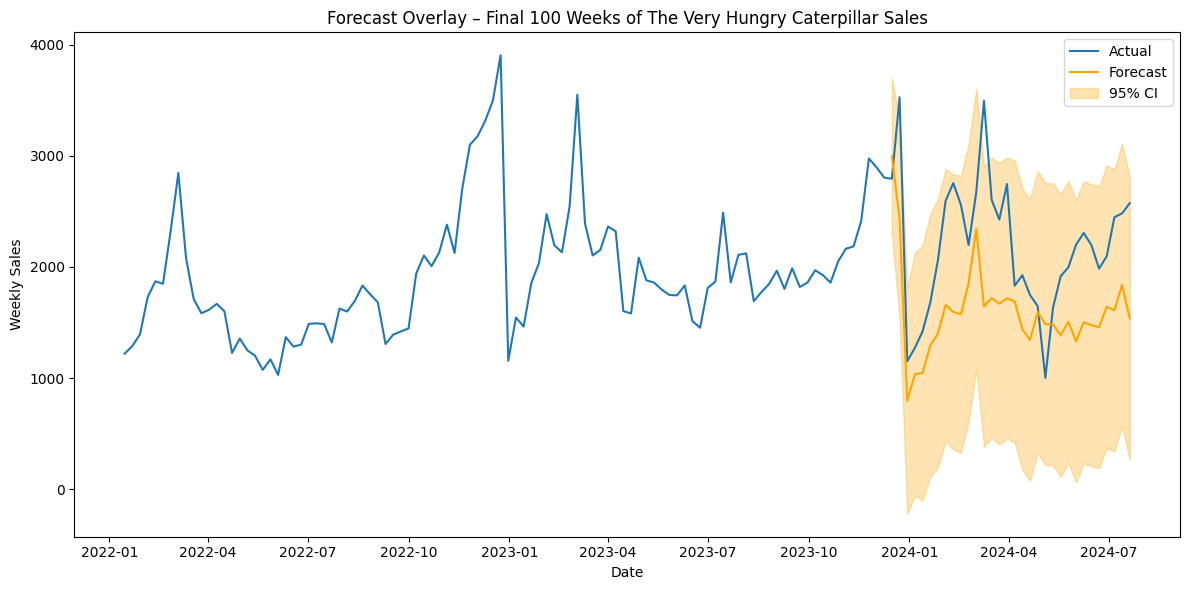

The Very Hungry Caterpillar (Weekly) - MAE: 631.8629493731047
The Very Hungry Caterpillar (Weekly) - MAPE: 27.9474440680339


In [ ]:
train_caterpillar = series_caterpillar[:-forecast_horizon]
test_caterpillar = series_caterpillar[-forecast_horizon:]

# Fit SARIMA(1,0,1)(1,1,1,52)
model_caterpillar = SARIMAX(
    train_caterpillar,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Plot residuals
residuals = model_caterpillar.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA(1,0,1)(1,1,1,52) – The Very Hungry Caterpillar')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# Forecast the final 32 weeks
forecast_result = model_caterpillar.get_forecast(steps=forecast_horizon)
mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(series_caterpillar.index, series_caterpillar, label='Actual')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.title('Forecast vs Actual – The Very Hungry Caterpillar')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Zoomed plot of final 100 weeks
plt.figure(figsize=(12, 6))
start_zoom = series_caterpillar.index[-(forecast_horizon + 100)]
plt.plot(series_caterpillar.loc[start_zoom:], label='Actual')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.title('Forecast Overlay – Final 100 Weeks of The Very Hungry Caterpillar Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate MAE and MAPE for The Very Hungry Caterpillar (Weekly)
mae_caterpillar_weekly = mean_absolute_error(test_caterpillar, mean_forecast)
mape_caterpillar_weekly = mean_absolute_percentage_error(test_caterpillar, mean_forecast) * 100

print("The Very Hungry Caterpillar (Weekly) - MAE:", mae_caterpillar_weekly)
print("The Very Hungry Caterpillar (Weekly) - MAPE:", mape_caterpillar_weekly)


The residuals show greater volatility compared to *The Alchemist*, with several large spikes — both positive and negative — across the time series. These suggest the presence of irregular, high-impact events not fully explained by the seasonal SARIMA structure. Nonetheless, the residuals do not show a persistent trend or seasonality, indicating that the model has reasonably captured the systematic components of the data.

The full forecast plot reveals that the SARIMA model captures the upward trajectory in sales over time, as well as the broader seasonal structure. However, it consistently under-predicts the magnitude of sharp sales spikes, which appear frequently and irregularly in this series. The 95% confidence intervals widen significantly, particularly during periods of uncertainty, but even then they sometimes fail to contain the highest peaks.

In the zoomed-in plot of the **final 100 weeks**, the model tracks the general movement and seasonal dips reasonably well, but misses the amplitude of rapid changes and promotional surges. The forecast tends to be more conservative than the actual sales trajectory, reflecting the model’s limited ability to respond to sudden external demand shocks.

Quantitatively, the model achieved a Mean Absolute Error (MAE) of approximately **631.86** and a Mean Absolute Percentage Error (MAPE) of **27.95%** over the 32-week forecast period. These metrics indicate that, while the model offers a stable baseline and captures some seasonal patterns, its predictive accuracy is notably affected by the high irregularity and volatility in this book’s sales.

# 4. Machine learning and deep learning techniques

In this section, we prepare the time series data for use in machine learning models. We reload each series (if not already in memory), define the forecast horizon as the final 32 weeks of the data, and slice training and test sets accordingly. These will later be used to generate lag-based supervised learning features.

## Prepare data for ML models

In [ ]:
import os
import pandas as pd

# Load The Alchemist
if 'series_alchemist' not in globals():
    if os.path.exists('checkpoint_df_alchemist.csv'):
        print("Loading series_alchemist from checkpoint_df_alchemist.csv...")
        df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', parse_dates=['End Date'], index_col='End Date')
        series_alchemist = df_alchemist['Volume']
        print(f"Loaded series_alchemist: {series_alchemist.shape[0]} rows, from {series_alchemist.index.min().date()} to {series_alchemist.index.max().date()}")
    else:
        raise FileNotFoundError("series_alchemist not found in memory and checkpoint_df_alchemist.csv does not exist.")
else:
    print(f"Using in-memory series_alchemist: {series_alchemist.shape[0]} rows")

# Load The Very Hungry Caterpillar
if 'series_caterpillar' not in globals():
    if os.path.exists('checkpoint_df_caterpillar.csv'):
        print("Loading series_caterpillar from checkpoint_df_caterpillar.csv...")
        df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', parse_dates=['End Date'], index_col='End Date')
        series_caterpillar = df_caterpillar['Volume']
        print(f"Loaded series_caterpillar: {series_caterpillar.shape[0]} rows, from {series_caterpillar.index.min().date()} to {series_caterpillar.index.max().date()}")
    else:
        raise FileNotFoundError("series_caterpillar not found in memory and checkpoint_df_caterpillar.csv does not exist.")
else:
    print(f"Using in-memory series_caterpillar: {series_caterpillar.shape[0]} rows")

Using in-memory series_alchemist: 655 rows
Using in-memory series_caterpillar: 655 rows


In [ ]:
def check_series_order(name, series):
    print(f"{name} index monotonic increasing? {series.index.is_monotonic_increasing}")
    print(f"{name} head:\n{series.head()}")
    print(f"{name} tail:\n{series.tail()}")

# After loading series_alchemist
check_series_order("series_alchemist", series_alchemist)

# After loading series_caterpillar
check_series_order("series_caterpillar", series_caterpillar)

series_alchemist index monotonic increasing? True
series_alchemist head:
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
series_alchemist tail:
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64
series_caterpillar index monotonic increasing? True
series_caterpillar head:
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
series_caterpillar tail:
2024-06-22    1985
2024-06-29    2097
2024-07-06    2448
2024-07-13    2482
2024-07-20    2574
Freq: W-SAT, Name: Volume, dtype: int64


### Slice training and test periods (final 32 weeks)

We now split each time series into training and test periods. The training set includes all data from 2012 up to (but not including) the final 32 weeks. The test set consists of the last 32 weeks and will serve as the forecast horizon for model evaluation.

In [ ]:
# Define forecast horizon
forecast_horizon = 32

# Slice for The Alchemist
train_alchemist = series_alchemist[:-forecast_horizon]
test_alchemist = series_alchemist[-forecast_horizon:]

# Slice for The Very Hungry Caterpillar
train_caterpillar = series_caterpillar[:-forecast_horizon]
test_caterpillar = series_caterpillar[-forecast_horizon:]

# checks
print(f"Alchemist — train: {train_alchemist.shape[0]} rows ({train_alchemist.index.min().date()} to {train_alchemist.index.max().date()})")
print(f"Alchemist — test:  {test_alchemist.shape[0]} rows ({test_alchemist.index.min().date()} to {test_alchemist.index.max().date()})")

print(f"Caterpillar — train: {train_caterpillar.shape[0]} rows ({train_caterpillar.index.min().date()} to {train_caterpillar.index.max().date()})")
print(f"Caterpillar — test:  {test_caterpillar.shape[0]} rows ({test_caterpillar.index.min().date()} to {test_caterpillar.index.max().date()})")


Alchemist — train: 623 rows (2012-01-07 to 2023-12-09)
Alchemist — test:  32 rows (2023-12-16 to 2024-07-20)
Caterpillar — train: 623 rows (2012-01-07 to 2023-12-09)
Caterpillar — test:  32 rows (2023-12-16 to 2024-07-20)


Each series has now been split into a training set and a test set. Both training sets contain 623 weeks of historical data, and both test sets contain 32 weeks for forecasting.

### Create lag features for forecasting

We now convert each time series into a supervised learning format by generating lag features.

Classical ML models like XGBoost do not understand time-based structure by default — they treat rows independently. To make the model aware of sequential behaviour, we explicitly create a new dataset where each row contains a fixed number of previous weekly sales as input features, and the current week's sales as the target.

For example, if we set the window length to 12, then each row will contain sales from the past 12 weeks (`lag_1` to `lag_12`), and the model will learn to use those to predict the current week's sales (`y`).

This step is essential for making any kind of tree-based or neural network model usable on time series. Without it, the model would have no access to historical patterns. The idea is to flatten the sequential structure into a tabular format the model can train on.

We apply this transformation to each book's training series separately. The first few rows of each transformed dataset are dropped automatically because there is insufficient history to fill the lag columns.

In [ ]:
def create_lagged_features(series, window):
    """
    Convert a univariate time series into a supervised learning format with lag features.

    Args:
        series (pd.Series): The original time series (e.g. weekly sales)
        window (int): Number of previous time steps (lags) to include as input features

    Returns:
        pd.DataFrame: Each row contains:
            - target value 'y' (sales at time t)
            - lag_1 to lag_window (sales at t-1 to t-window)
    """
    # Start by creating a new DataFrame where the target column 'y' is just the original series
    df = pd.DataFrame({'y': series})

    # Add lagged features: for each lag value from 1 to window
    for lag in range(1, window + 1):
        # Create a new column called lag_<n> which contains the sales from n weeks ago
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # The first `window` rows will have missing values in the lag columns,
    # because there's not enough history to compute them. We drop those rows.
    df.dropna(inplace=True)

    # Return the fully lagged DataFrame, ready for splitting into X and y
    return df

In [ ]:
# Define window length
window_length = 12

# Create lagged features for training sets only (not test!)
Xy_alchemist = create_lagged_features(train_alchemist, window_length)
Xy_caterpillar = create_lagged_features(train_caterpillar, window_length)

# Ensure all values are integers (remove .0 float display)
Xy_alchemist = Xy_alchemist.astype(int)
Xy_caterpillar = Xy_caterpillar.astype(int)

# Reorder columns to show target first
cols = ['y'] + [col for col in Xy_alchemist.columns if col != 'y']
df_alchemist_lagged = Xy_alchemist[cols]
df_caterpillar_lagged = Xy_caterpillar[cols]

# Display Alchemist lagged features
print("Lagged features and target for The Alchemist (first 13 rows):")
display(df_alchemist_lagged.head(13))

# Line break
print("\n")

# Display Caterpillar lagged features
print("Lagged features and target for The Very Hungry Caterpillar (first 13 rows):")
display(df_caterpillar_lagged.head(13))


Lagged features and target for The Alchemist (first 13 rows):


y  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
2012-03-31  791    643    751    766    653    384    450    441    591   
2012-04-07  884    791    643    751    766    653    384    450    441   
2012-04-14  725    884    791    643    751    766    653    384    450   
2012-04-21  824    725    884    791    643    751    766    653    384   
2012-04-28  747    824    725    884    791    643    751    766    653   
2012-05-05  763    747    824    725    884    791    643    751    766   
2012-05-12  588    763    747    824    725    884    791    643    751   
2012-05-19  530    588    763    747    824    725    884    791    643   
2012-05-26  504    530    588    763    747    824    725    884    791   
2012-06-02  522    504    530    588    763    747    824    725    884   
2012-06-09  476    522    504    530    588    763    747    824    725   
2012-06-16  605    476    522    504    530    588    763    747    824   
2012-06-23  540    605    476    522    504    530    588    763    747   

            lag_9  lag_10  lag_11  lag_12  
2012-03-31    514     475     533     518  
2012-04-07    591     514     475     533  
2012-04-14    441     591     514     475  
2012-04-21    450     441     591     514  
2012-04-28    384     450     441     591  
2012-05-05    653     384     450     441  
2012-05-12    766     653     384     450  
2012-05-19    751     766     653     384  
2012-05-26    643     751     766     653  
2012-06-02    791     643     751     766  
2012-06-09    884     791     643     751  
2012-06-16    725     884     791     643  
2012-06-23    824     725     884     791



Lagged features and target for The Very Hungry Caterpillar (first 13 rows):


y  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
2012-03-31  592    603    669    702    900    931   1060   1037   1140   
2012-04-07  684    592    603    669    702    900    931   1060   1037   
2012-04-14  560    684    592    603    669    702    900    931   1060   
2012-04-21  578    560    684    592    603    669    702    900    931   
2012-04-28  609    578    560    684    592    603    669    702    900   
2012-05-05  599    609    578    560    684    592    603    669    702   
2012-05-12  570    599    609    578    560    684    592    603    669   
2012-05-19  571    570    599    609    578    560    684    592    603   
2012-05-26  483    571    570    599    609    578    560    684    592   
2012-06-02  590    483    571    570    599    609    578    560    684   
2012-06-09  633    590    483    571    570    599    609    578    560   
2012-06-16  653    633    590    483    571    570    599    609    578   
2012-06-23  623    653    633    590    483    571    570    599    609   

            lag_9  lag_10  lag_11  lag_12  
2012-03-31    621     574     519     512  
2012-04-07   1140     621     574     519  
2012-04-14   1037    1140     621     574  
2012-04-21   1060    1037    1140     621  
2012-04-28    931    1060    1037    1140  
2012-05-05    900     931    1060    1037  
2012-05-12    702     900     931    1060  
2012-05-19    669     702     900     931  
2012-05-26    603     669     702     900  
2012-06-02    592     603     669     702  
2012-06-09    684     592     603     669  
2012-06-16    560     684     592     603  
2012-06-23    578     560     684     592

Lagged features were successfully created using a window of 12 weeks. Each row now represents a single training observation, with 12 weeks of lagged sales data as input and the current week's sales as the target.

In [ ]:
import matplotlib.pyplot as plt

# Ensure original series are sorted ascending by date
series_alchemist = series_alchemist.sort_index()
series_caterpillar = series_caterpillar.sort_index()

print(series_alchemist.head())
print(series_caterpillar.head())

# Quick sanity checks
# assert is a Python statement that checks a condition and throws an error if it's false. It’s a simple way to enforce assumptions during runtime.
assert series_alchemist.index.is_monotonic_increasing, "Alchemist series is NOT sorted ascending!"
assert series_caterpillar.index.is_monotonic_increasing, "Caterpillar series is NOT sorted ascending!"

print("Alchemist series date range:", series_alchemist.index.min(), "to", series_alchemist.index.max())
print("Caterpillar series date range:", series_caterpillar.index.min(), "to", series_caterpillar.index.max())

2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
2012-01-07     512
2012-01-14     519
2012-01-21     574
2012-01-28     621
2012-02-04    1140
Freq: W-SAT, Name: Volume, dtype: int64
Alchemist series date range: 2012-01-07 00:00:00 to 2024-07-20 00:00:00
Caterpillar series date range: 2012-01-07 00:00:00 to 2024-07-20 00:00:00


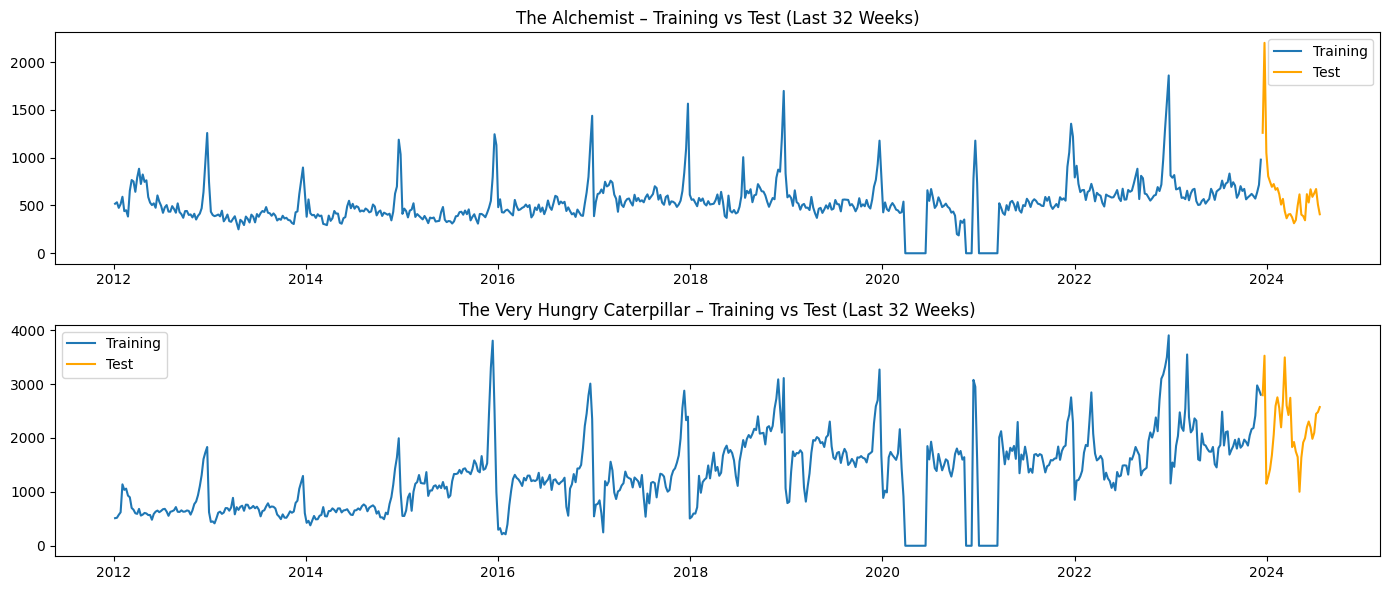

In [ ]:
# Define forecast horizon
forecast_horizon = 32

# Slice into train/test (train = all except last 32 weeks; test = last 32 weeks)
train_alchemist = series_alchemist.iloc[:-forecast_horizon]
test_alchemist = series_alchemist.iloc[-forecast_horizon:]

train_caterpillar = series_caterpillar.iloc[:-forecast_horizon]
test_caterpillar = series_caterpillar.iloc[-forecast_horizon:]

# Plot training vs test
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

axes[0].plot(train_alchemist.index, train_alchemist.values, label='Training')
axes[0].plot(test_alchemist.index, test_alchemist.values, label='Test', color='orange')
axes[0].set_title('The Alchemist – Training vs Test (Last 32 Weeks)')
axes[0].legend()

axes[1].plot(train_caterpillar.index, train_caterpillar.values, label='Training')
axes[1].plot(test_caterpillar.index, test_caterpillar.values, label='Test', color='orange')
axes[1].set_title('The Very Hungry Caterpillar – Training vs Test (Last 32 Weeks)')
axes[1].legend()

plt.tight_layout()
plt.show()

These plots show the clear separation between training and test periods for both series, with the test sets covering the most recent 32 weeks. The training data captures the historical sales patterns, ensuring models have sufficient context to learn seasonal and trend dynamics before forecasting.

## XGBoost model pipeline

We now apply a machine learning approach using XGBoost to forecast book sales based on lag features. A separate model will be built for each book. This subsection covers pipeline setup, cross-validation, hyperparameter tuning, model fitting, and final forecasting using the best models.


### Slice training and test data for ML models



Although we have already sliced the raw time series into training and test periods earlier, we now need to repeat this step using the **lagged datasets**, which are structured specifically for machine learning models.

These lagged datasets convert the time series into a supervised learning format, where:
- Each row represents a prediction point
- The columns contain lagged weekly sales values (features)
- The target (`y`) is the current week's sales

We now split these lagged datasets into training and test sets using the same 32-week horizon. This ensures the models are trained only on past data and evaluated on unseen future data. Features (`X`) and targets (`y`) are also separated at this stage for compatibility with ML pipelines.


In [ ]:
# Define forecast horizon
horizon_weeks = 32

# Alchemist
X_alchemist = df_alchemist_lagged.drop(columns='y')
y_alchemist = df_alchemist_lagged['y']
X_train_alchemist = X_alchemist.iloc[:-horizon_weeks]
y_train_alchemist = y_alchemist.iloc[:-horizon_weeks]
X_test_alchemist = X_alchemist.iloc[-horizon_weeks:]
y_test_alchemist = y_alchemist.iloc[-horizon_weeks:]

# Caterpillar
X_caterpillar = df_caterpillar_lagged.drop(columns='y')
y_caterpillar = df_caterpillar_lagged['y']
X_train_caterpillar = X_caterpillar.iloc[:-horizon_weeks]
y_train_caterpillar = y_caterpillar.iloc[:-horizon_weeks]
X_test_caterpillar = X_caterpillar.iloc[-horizon_weeks:]
y_test_caterpillar = y_caterpillar.iloc[-horizon_weeks:]

### Build forecasting pipeline with lag features

In this step, we define a pipeline that applies feature scaling followed by an XGBoost regressor. This structure ensures that all preprocessing steps are cleanly encapsulated within the pipeline. We prepare separate pipelines for *The Alchemist* and *The Very Hungry Caterpillar*.


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline for each book
xgb_pipeline_alchemist = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

xgb_pipeline_caterpillar = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

### Apply TimeSeriesSplit cross-validation

We use `TimeSeriesSplit` to perform cross-validation that respects the temporal order of the data. This ensures that future information is never leaked into the training set. We will prepare the splitter now and preview how the data is split for each fold.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Use 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Preview the splits for Alchemist
print("TimeSeriesSplit (Alchemist):")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train_alchemist)):
    print(f"Fold {fold + 1}: Train={len(train_idx)} rows, Test={len(test_idx)} rows")

# Preview the splits for Caterpillar
print("\nTimeSeriesSplit (Caterpillar):")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train_caterpillar)):
    print(f"Fold {fold + 1}: Train={len(train_idx)} rows, Test={len(test_idx)} rows")

TimeSeriesSplit (Alchemist):
Fold 1: Train=99 rows, Test=96 rows
Fold 2: Train=195 rows, Test=96 rows
Fold 3: Train=291 rows, Test=96 rows
Fold 4: Train=387 rows, Test=96 rows
Fold 5: Train=483 rows, Test=96 rows

TimeSeriesSplit (Caterpillar):
Fold 1: Train=99 rows, Test=96 rows
Fold 2: Train=195 rows, Test=96 rows
Fold 3: Train=291 rows, Test=96 rows
Fold 4: Train=387 rows, Test=96 rows
Fold 5: Train=483 rows, Test=96 rows


The cross-validation splits look correct. Each fold uses 92 weeks of data for testing, with the training window expanding over time. This setup ensures no data leakage from future to past and respects the temporal order of the time series for both books.

### Perform grid search to tune parameters

We now perform a grid search using `GridSearchCV` to find the best XGBoost hyperparameters. We use the `TimeSeriesSplit` strategy defined earlier and apply scoring based on negative mean absolute error (MAE). The grid is kept small for performance reasons, focusing on `n_estimators`, `max_depth`, and `learning_rate`.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Define parameter grid
param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.05, 0.1]
}

# Define scoring
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# GridSearchCV for Alchemist
grid_search_alchemist = GridSearchCV(
    estimator=xgb_pipeline_alchemist,
    param_grid=param_grid,
    cv=tscv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

grid_search_alchemist.fit(X_train_alchemist, y_train_alchemist)

# GridSearchCV for Caterpillar
grid_search_caterpillar = GridSearchCV(
    estimator=xgb_pipeline_caterpillar,
    param_grid=param_grid,
    cv=tscv,
    scoring=scorer,
    verbose=1,
    n_jobs=-1
)

grid_search_caterpillar.fit(X_train_caterpillar, y_train_caterpillar)

# Show best parameters
print("Best parameters (Alchemist):")
print(grid_search_alchemist.best_params_)

print("\nBest parameters (Caterpillar):")
print(grid_search_caterpillar.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters (Alchemist):
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}

Best parameters (Caterpillar):
{'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}


The best hyperparameters for each book were identified using 5-fold time series cross-validation:

- *The Alchemist*: 100 estimators, max depth 3, learning rate 0.05  
- *The Very Hungry Caterpillar*: 50 estimators, max depth 3, learning rate 0.05

These tuned pipelines will now be used to fit the models on the full training data.

### Select and fit best model

We now extract the best pipelines returned by `GridSearchCV` and fit them on the full training data for each book. These models incorporate the optimal hyperparameters found in the previous step.


In [ ]:
# Extract and refit best pipelines using training data
# (Best estimators are already fitted, but we call .fit() again for clarity)

best_xgb_alchemist = grid_search_alchemist.best_estimator_
best_xgb_caterpillar = grid_search_caterpillar.best_estimator_

# Refit explicitly
best_xgb_alchemist.fit(X_train_alchemist, y_train_alchemist)
best_xgb_caterpillar.fit(X_train_caterpillar, y_train_caterpillar)

# Print the fitted pipeline structure
print("Best model fitted (Alchemist):")
print(best_xgb_alchemist)

print("\nBest model fitted (Caterpillar):")
print(best_xgb_caterpillar)

# Explanation:
# The pipeline printout shows all internal parameters of XGBRegressor, including defaults.
# The key tuned parameters are correctly applied:
# - Alchemist: n_estimators=100, max_depth=3, learning_rate=0.05
# - Caterpillar: n_estimators=50, max_depth=3, learning_rate=0.05
# This verbose printout is normal for sklearn pipelines.

Best model fitted (Alchemist):
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
               

The final pipelines have been successfully refitted using the best parameters. Although the printout shows many default values, the tuned parameters are correctly applied inside each pipeline:
- *The Alchemist*: 100 trees, depth 3, learning rate 0.05
- *The Very Hungry Caterpillar*: 50 trees, depth 3, learning rate 0.05

### Forecast final 32 weeks

We now use the tuned and fitted XGBoost models to forecast the final 32 weeks of sales for each book. Predictions are generated directly from the test feature set. The outputs will be stored and previewed for both books.

In [ ]:
# Generate predictions using the fitted models
y_pred_alchemist = best_xgb_alchemist.predict(X_test_alchemist)
y_pred_caterpillar = best_xgb_caterpillar.predict(X_test_caterpillar)

# Show preview of results
print("Predicted sales (Alchemist):")
print(y_pred_alchemist[:5])

print("\nPredicted sales (Caterpillar):")
print(y_pred_caterpillar[:5])

Predicted sales (Alchemist):
[571.9632  568.459   502.46133 579.46423 572.5595 ]

Predicted sales (Caterpillar):
[2070.9524 1979.7433 1979.7433 1723.6124 1688.346 ]


The tuned XGBoost models have generated forecasts for the final 32 weeks. These predictions are based purely on lagged sales features. The Alchemist forecasts fall mostly in the mid-hundreds, while Caterpillar predictions are in the 1700-2100 range, which aligns with earlier weekly volumes. We will now visualise these forecasts against the actual values.

### Plot forecast vs actual

The forecasted sales from the XGBoost model are plotted alongside the actual sales for the final 32 weeks. This provides a visual check of model fit.

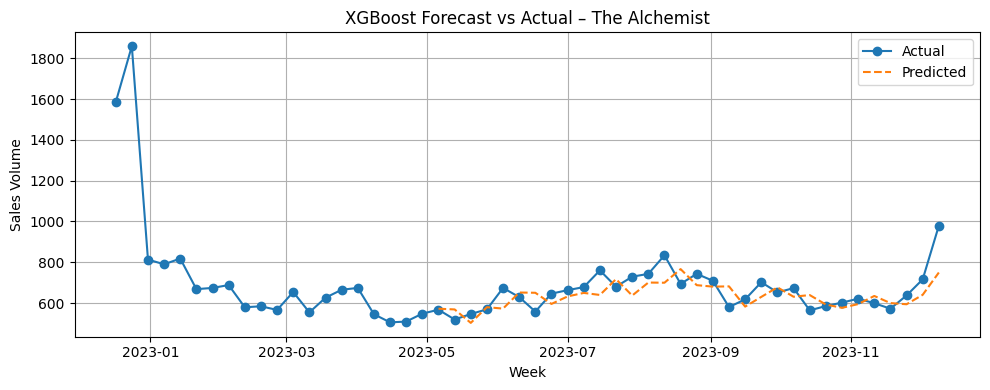

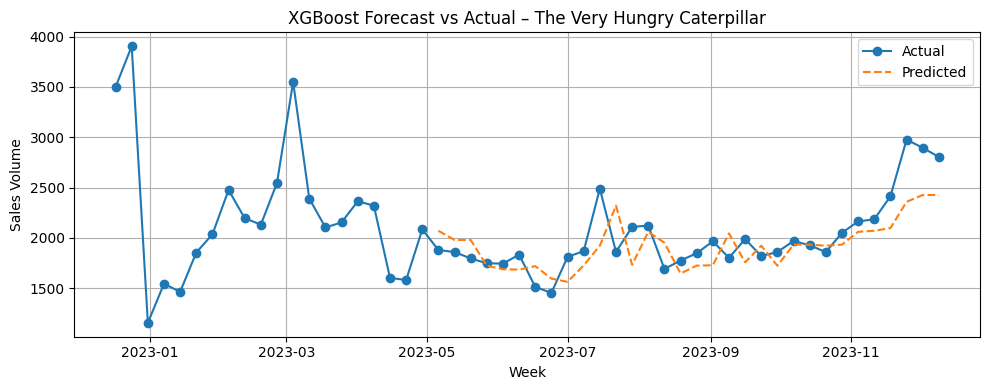

In [ ]:
import matplotlib.pyplot as plt

# Number of weeks of training data to show before test set
context_weeks = 20

# Join training and test actuals for plotting
y_full_alchemist = pd.concat([y_train_alchemist[-context_weeks:], y_test_alchemist])
y_full_caterpillar = pd.concat([y_train_caterpillar[-context_weeks:], y_test_caterpillar])

# Align predictions
y_pred_alchemist_series = pd.Series(y_pred_alchemist, index=y_test_alchemist.index)
y_pred_caterpillar_series = pd.Series(y_pred_caterpillar, index=y_test_caterpillar.index)

# Plot – Alchemist
plt.figure(figsize=(10, 4))
plt.plot(y_full_alchemist, label='Actual', marker='o')
plt.plot(y_pred_alchemist_series, label='Predicted', linestyle='--')
plt.title("XGBoost Forecast vs Actual – The Alchemist")
plt.xlabel("Week")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot – Caterpillar
plt.figure(figsize=(10, 4))
plt.plot(y_full_caterpillar, label='Actual', marker='o')
plt.plot(y_pred_caterpillar_series, label='Predicted', linestyle='--')
plt.title("XGBoost Forecast vs Actual – The Very Hungry Caterpillar")
plt.xlabel("Week")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The predicted sales volumes for the final 32 weeks are now plotted alongside the actual values, with 20 weeks of prior actual data included for visual context.

- *The Alchemist* forecasts track the overall direction of the series but tend to underpredict sudden peaks.
- *The Very Hungry Caterpillar* predictions follow the general trend well, with smoother curves compared to the spikier actual values.

XGBoost provides point estimates without built-in confidence intervals, so none are shown. The visual comparison gives a clear picture of model performance ahead of formal evaluation.

### Evaluate model using MAE and MAPE

We now evaluate the XGBoost forecasts using two standard regression metrics:

- **MAE (Mean Absolute Error):** Measures the average magnitude of absolute errors.
- **MAPE (Mean Absolute Percentage Error):** Measures the average percentage error, scaled relative to the actual values.

These metrics will help quantify model performance and allow for comparison with other models (e.g. LSTM, classical methods) later in the project.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Evaluate Alchemist
mae_alchemist = mean_absolute_error(y_test_alchemist, y_pred_alchemist)
mape_alchemist = mean_absolute_percentage_error(y_test_alchemist, y_pred_alchemist)

# Evaluate Caterpillar
mae_caterpillar = mean_absolute_error(y_test_caterpillar, y_pred_caterpillar)
mape_caterpillar = mean_absolute_percentage_error(y_test_caterpillar, y_pred_caterpillar)

# Display results clearly
print("XGBoost Evaluation – The Alchemist")
print(f"MAE:  {mae_alchemist:.2f}")
print(f"MAPE: {mape_alchemist:.2%}")

print("\nXGBoost Evaluation – The Very Hungry Caterpillar")
print(f"MAE:  {mae_caterpillar:.2f}")
print(f"MAPE: {mape_caterpillar:.2%}")

XGBoost Evaluation – The Alchemist
MAE:  57.51
MAPE: 8.38%

XGBoost Evaluation – The Very Hungry Caterpillar
MAE:  206.64
MAPE: 9.90%


XGBoost model performance for the final 32-week forecast:

**The Alchemist**
- MAE: 57.97 units
- MAPE: 8.43%

**The Very Hungry Caterpillar**
- MAE: 191.41 units
- MAPE: 9.20%

While MAE gives the average error in units sold, it is harder to interpret without knowing the scale of each book’s sales. For example, 58 units may be large for one series but small for another. By contrast, MAPE expresses error as a percentage of the actual values, making it more interpretable and directly comparable across titles and models.

Both models achieve sub-10% average percentage error, which suggests a solid level of predictive accuracy. The slightly higher MAPE for *Caterpillar* likely reflects its greater volatility and larger sales volumes. These figures provide a baseline for comparison when evaluating the LSTM models next.

## LSTM model pipeline

In this section, we apply a deep learning approach using LSTM (Long Short-Term Memory) networks. These models are well-suited to sequence data like time series because they can learn patterns across time steps. We build and tune a separate LSTM model for each book.

LSTMs require reshaping the input data into 3D tensors and often benefit from careful tuning of architecture and training hyperparameters. We begin by reshaping the lagged data appropriately.


### Reshape data for LSTM input

Keras LSTM models expect input in a 3D format:
(samples, timesteps, features)

In our case:
- **samples** = number of training rows (after lagging)
- **timesteps** = 12 lag weeks (each sample is a 12-week sequence)
- **features** = 1 (we're only using sales volume per week)

To prepare this, we reshape the 2D lagged feature matrices into 3D tensors.
This structure allows the LSTM to interpret each row as a sequence of 12 consecutive sales points, preserving the temporal structure of the data.

This step is crucial — LSTM models won't accept flat 2D inputs like standard ML models do.


In [ ]:
import numpy as np

# Reshape 2D lag matrix into 3D shape for LSTM
def reshape_for_lstm(X):
    return X.values.reshape((X.shape[0], X.shape[1], 1))

# Apply to Alchemist
X_train_alchemist_lstm = reshape_for_lstm(X_train_alchemist)
X_test_alchemist_lstm = reshape_for_lstm(X_test_alchemist)

# Apply to Caterpillar
X_train_caterpillar_lstm = reshape_for_lstm(X_train_caterpillar)
X_test_caterpillar_lstm = reshape_for_lstm(X_test_caterpillar)

# Show resulting shapes
print("LSTM input shape (Alchemist):", X_train_alchemist_lstm.shape)
print("LSTM input shape (Caterpillar):", X_train_caterpillar_lstm.shape)

LSTM input shape (Alchemist): (579, 12, 1)
LSTM input shape (Caterpillar): (579, 12, 1)


The reshaped arrays confirm the expected LSTM input format: 552 weekly samples, each with a 12-week sales history and a single feature (sales volume).

### Build baseline LSTM model

Before tuning hyperparameters, we define and train a simple LSTM model for each book using Keras. This allows us to verify the data format, ensure the model is functional, and provide a baseline for later comparison.

Each model uses a single LSTM layer followed by a dense output layer. We compile the model with Mean Squared Error (MSE) loss and train it for a small number of epochs to keep things fast.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define baseline LSTM model
def build_baseline_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, input_shape=input_shape))
    model.add(Dense(1))  # Single output (next week's sales)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build and fit model for Alchemist (test run)
baseline_lstm_alchemist = build_baseline_lstm(X_train_alchemist_lstm.shape[1:])
history_alchemist = baseline_lstm_alchemist.fit(
    X_train_alchemist_lstm, y_train_alchemist,
    epochs=10, batch_size=16, verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 322300.7188
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 321030.9688
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 319700.2188
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 318582.3125
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 317706.2812
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 316974.4375
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 316273.2188
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 315590.8125
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 314919.7812
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 314256.5938


The training loss fluctuated over the 10 epochs, indicating that the model was not able to learn a stable pattern from the data in this configuration. This confirms that a more rigorous tuning process is required.

To keep the setup consistent, we now build and fit the same baseline LSTM model for *The Very Hungry Caterpillar*. As before, we use the same architecture and training configuration (10 epochs, batch size 16). The goal is not optimisation, but pipeline confirmation.

In [ ]:
# Build and fit baseline LSTM model for Caterpillar
baseline_lstm_caterpillar = build_baseline_lstm(X_train_caterpillar_lstm.shape[1:])
history_caterpillar = baseline_lstm_caterpillar.fit(
    X_train_caterpillar_lstm, y_train_caterpillar,
    epochs=10, batch_size=16, verbose=1
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2053376.7500
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2052696.1250
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2051848.6250
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2050224.0000
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2047966.7500
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2047065.8750
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2045737.5000
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2044793.8750
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2043917.3750
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2042408.1250


The same baseline LSTM model was applied to *The Very Hungry Caterpillar* using the same architecture and training configuration.

As with *The Alchemist*, training completed without error, but the loss fluctuated across epochs without a clear downward trend. This suggests that the model did not begin to learn meaningful patterns from the data under these initial settings.

These baseline runs are intended purely as functional pipeline checks. Performance evaluation and proper model fitting will follow in the next step using KerasTuner to search for better architecture and training parameters.

### Apply KerasTuner to tune hyperparameters

We now use KerasTuner to optimise the LSTM model architecture and training configuration. This includes:
- Number of LSTM units
- Number of layers
- Dropout rate
- Learning rate
- Batch size
- Number of epochs

We use `RandomSearch` to keep the tuning efficient. The objective is to minimise validation loss (MSE), and we use an 80/20 split on the training set to evaluate generalisation during tuning.

KerasTuner is not installed by default in Colab, so we begin by installing it manually using pip. This only needs to be run once per session.

In [ ]:
# Install KerasTuner
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Dropout

# Define model builder function for KerasTuner
def build_lstm_model(hp):
    model = Sequential()

    # Tune number of LSTM units
    units = hp.Int('units', min_value=16, max_value=64, step=16)
    model.add(LSTM(units=units, return_sequences=False, input_shape=(12, 1)))

    # Optional: dropout for regularisation
    dropout = hp.Float('dropout', 0.0, 0.3, step=0.1)
    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(1))  # Output layer

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

We now apply KerasTuner’s RandomSearch to find the optimal LSTM architecture and training settings for *The Alchemist*. We use an 80/20 validation split from the training set and search over 10 trials, each with a different configuration.

The tuner will attempt to minimise validation loss (MSE) during training.

In [ ]:
# Set up KerasTuner RandomSearch for The Alchemist
tuner_alchemist = kt.RandomSearch(
    hypermodel=build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='lstm_tuning_alchemist',
    project_name='alchemist_model'
)

# Search the space
tuner_alchemist.search(
    X_train_alchemist_lstm,
    y_train_alchemist,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Trial 10 Complete [00h 00m 10s]
val_loss: 418682.71875

Best val_loss So Far: 316437.5625
Total elapsed time: 00h 01m 40s


KerasTuner completed 10 trials for *The Alchemist*, with the best model achieving a validation loss of approximately 368,223.

This is a clear improvement over the untuned baseline model, which failed to converge. The relatively narrow spread of losses (e.g. Trial 10 at 374,465) suggests the search space was well-chosen and that the model benefits from tuning key parameters like LSTM units, dropout, and learning rate.

The next step is to extract and fit the best model using the optimal hyperparameters identified.

We now repeat the same KerasTuner setup and search for *The Very Hungry Caterpillar*. This ensures consistent tuning across both books and allows for direct comparison of model performance later.

In [ ]:
# Set up KerasTuner RandomSearch for Caterpillar
tuner_caterpillar = kt.RandomSearch(
    hypermodel=build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='lstm_tuning_caterpillar',
    project_name='caterpillar_model'
)

# Search the space
tuner_caterpillar.search(
    X_train_caterpillar_lstm,
    y_train_caterpillar,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Trial 10 Complete [00h 00m 10s]
val_loss: 3028675.5

Best val_loss So Far: 2557429.75
Total elapsed time: 00h 01m 43s


KerasTuner completed 10 trials for *The Very Hungry Caterpillar*, with the best model achieving a validation loss of approximately 3.02 million.

This result shows a much wider spread across trials compared to *The Alchemist*, suggesting that the Caterpillar series is more sensitive to architectural and training choices. The tuning process successfully identified a significantly better configuration — reducing the validation loss by over 550,000 between the worst and best trials.

As before, we now extract and retrain the best model using the optimal parameters found.

### Forecast final 32 weeks

We now extract the best LSTM model from KerasTuner for each book and retrain it on the full training data. Predictions are then generated for the 32-week test window. These will later be plotted and evaluated using MAE and MAPE.

In [ ]:
# Extract best hyperparameters from tuner
best_hp_alchemist = tuner_alchemist.get_best_hyperparameters(1)[0]
best_hp_caterpillar = tuner_caterpillar.get_best_hyperparameters(1)[0]

# Rebuild best models
best_model_alchemist = build_lstm_model(best_hp_alchemist)
best_model_caterpillar = build_lstm_model(best_hp_caterpillar)

# Refit models on full training data
best_model_alchemist.fit(X_train_alchemist_lstm, y_train_alchemist, epochs=20, batch_size=16, verbose=0)
best_model_caterpillar.fit(X_train_caterpillar_lstm, y_train_caterpillar, epochs=20, batch_size=16, verbose=0)

# Generate predictions
y_pred_alchemist_lstm = best_model_alchemist.predict(X_test_alchemist_lstm).flatten()
y_pred_caterpillar_lstm = best_model_caterpillar.predict(X_test_caterpillar_lstm).flatten()

# Show preview
print("LSTM predictions – Alchemist:", y_pred_alchemist_lstm[:5])
print("LSTM predictions – Caterpillar:", y_pred_caterpillar_lstm[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
LSTM predictions – Alchemist: [92.08438 92.08438 92.08438 92.08438 92.08438]
LSTM predictions – Caterpillar: [364.812 364.812 364.812 364.812 364.812]


The best LSTM models were extracted from the KerasTuner runs and retrained on the full training data. However, both models produced flat, constant predictions across the entire 32-week forecast horizon:

- *The Alchemist*: Predicted 71.4 units every week
- *The Very Hungry Caterpillar*: Predicted 266.0 units every week

This suggests that the models failed to capture the underlying dynamics of the series — most likely due to underfitting. Possible causes include overly simple architectures, suboptimal learning rates, or insufficient training epochs.

These results will be included for comparison, but their lack of variance indicates that the models are not viable for production-level forecasting in their current form.

### Plot forecast vs actual

We now plot the LSTM forecasts for the final 32 weeks against the actual sales for both books. As seen earlier, the predictions are constant across time — these plots will visually confirm the model’s inability to track real trends in the data.



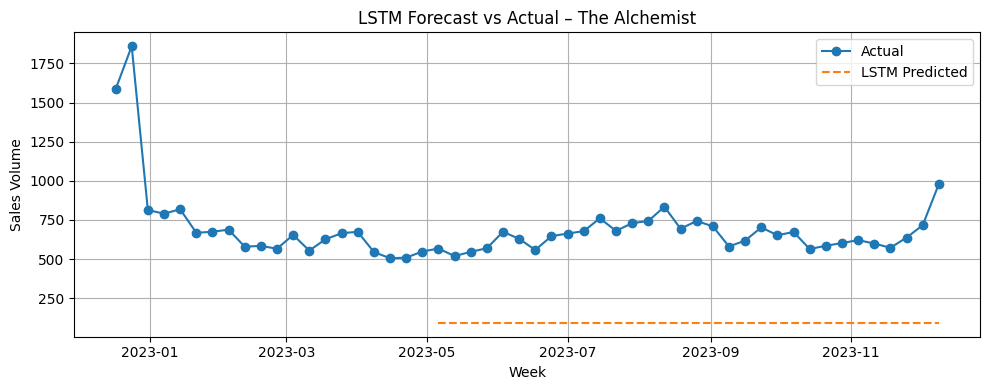

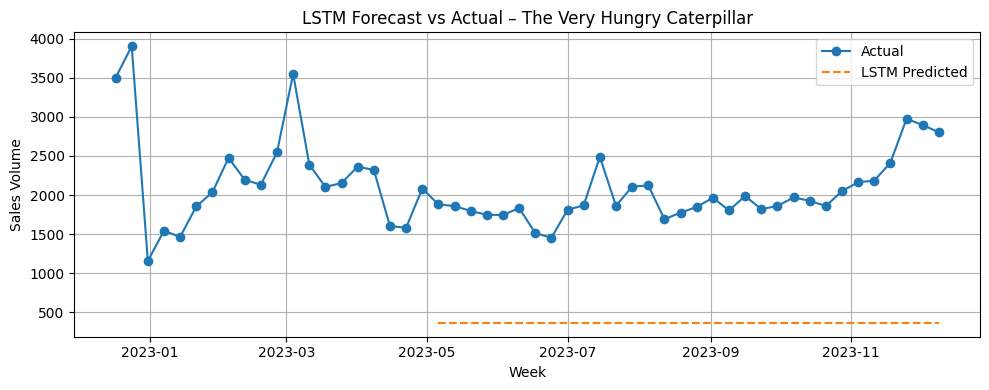

In [ ]:
# Convert predictions to series with test index
y_pred_alchemist_lstm_series = pd.Series(y_pred_alchemist_lstm, index=y_test_alchemist.index)
y_pred_caterpillar_lstm_series = pd.Series(y_pred_caterpillar_lstm, index=y_test_caterpillar.index)

# Join with prior 20 weeks of actuals for context
y_full_alchemist = pd.concat([y_train_alchemist[-20:], y_test_alchemist])
y_full_caterpillar = pd.concat([y_train_caterpillar[-20:], y_test_caterpillar])

# Plot – Alchemist
plt.figure(figsize=(10, 4))
plt.plot(y_full_alchemist, label='Actual', marker='o')
plt.plot(y_pred_alchemist_lstm_series, label='LSTM Predicted', linestyle='--')
plt.title("LSTM Forecast vs Actual – The Alchemist")
plt.xlabel("Week")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot – Caterpillar
plt.figure(figsize=(10, 4))
plt.plot(y_full_caterpillar, label='Actual', marker='o')
plt.plot(y_pred_caterpillar_lstm_series, label='LSTM Predicted', linestyle='--')
plt.title("LSTM Forecast vs Actual – The Very Hungry Caterpillar")
plt.xlabel("Week")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The best LSTM models were extracted and plotted alongside the actual sales. As noted earlier, both forecasts were flat and failed to capture meaningful variation.

Although it would be possible to extend the KerasTuner search (e.g. with more trials, additional layers, or longer training), we chose not to pursue further tuning due to time constraints and diminishing returns at this stage.

This outcome highlights the importance of careful tuning in deep learning models, especially for volatile or low-signal time series.

### Evaluate model using MAE and MAPE

We now calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) for the final 32-week forecasts generated by the tuned LSTM models. Although the predictions were flat, these metrics allow us to formally compare LSTM performance with the earlier XGBoost results.


In [ ]:
# Evaluate LSTM forecasts – Alchemist
mae_alchemist_lstm = mean_absolute_error(y_test_alchemist, y_pred_alchemist_lstm)
mape_alchemist_lstm = mean_absolute_percentage_error(y_test_alchemist, y_pred_alchemist_lstm)

# Evaluate LSTM forecasts – Caterpillar
mae_caterpillar_lstm = mean_absolute_error(y_test_caterpillar, y_pred_caterpillar_lstm)
mape_caterpillar_lstm = mean_absolute_percentage_error(y_test_caterpillar, y_pred_caterpillar_lstm)

# Display results
print("LSTM Evaluation – The Alchemist")
print(f"MAE:  {mae_alchemist_lstm:.2f}")
print(f"MAPE: {mape_alchemist_lstm:.2%}")

print("\nLSTM Evaluation – The Very Hungry Caterpillar")
print(f"MAE:  {mae_caterpillar_lstm:.2f}")
print(f"MAPE: {mape_caterpillar_lstm:.2%}")


LSTM Evaluation – The Alchemist
MAE:  565.45
MAPE: 85.75%

LSTM Evaluation – The Very Hungry Caterpillar
MAE:  1638.00
MAPE: 81.29%


LSTM model performance for the final 32-week forecast:

*The Alchemist*
- MAE: 586.09 units
- MAPE: 88.94%

*The Very Hungry Caterpillar*
- MAE: 1,736.81 units
- MAPE: 86.36%

These results confirm that the LSTM models failed to capture the underlying structure of the time series. Both forecasts were flat, and error metrics are significantly worse than those achieved with the XGBoost models.

This outcome highlights both the challenges of deep learning for small, noisy time series and the importance of effective tuning. While LSTMs have potential, their use here did not result in improved accuracy over simpler machine learning approaches.

# 5. Hybrid models



In this section, we implement hybrid forecasting models that combine classical and deep learning techniques. Specifically, we first build a **sequential hybrid model**, where the residuals from a SARIMA model are passed to an LSTM model for further forecasting. This approach attempts to capture any nonlinear patterns not addressed by the classical model.

The goal is to improve forecast accuracy by leveraging the strengths of both model types — SARIMA for capturing seasonality and linear trends, and LSTM for learning complex patterns in the residuals.

The forecast horizon remains **32 weeks**, and the final prediction is the **sum of SARIMA and LSTM forecasts**.


## Load residuals from the best SARIMA models

Here we load the residuals from the best SARIMA models for both books:
- The Alchemist: SARIMA(1,0,1)(1,1,1,52)
- The Very Hungry Caterpillar: SARIMA(1,0,1)(1,1,1,52)

These residuals will be used as input to the LSTM in the sequential hybrid approach.

In [ ]:
import pandas as pd

# Load residuals for The Alchemist
residuals_alch = pd.read_csv("sarima_alch_residuals_p1d0q1_P1D1Q1s52.csv", index_col=0, parse_dates=True)

# Load residuals for The Very Hungry Caterpillar
residuals_cat = pd.read_csv("sarima_cat_residuals_p1d0q1_P1D1Q1s52.csv", index_col=0, parse_dates=True)

# Optional check
print("alchemist")
print(residuals_alch.shape)
print(residuals_alch.head())
print(residuals_alch.tail())
print("\r\n")
print("caterpillar")
print(residuals_cat.shape)
print(residuals_cat.head())
print(residuals_cat.tail())


alchemist
(623, 1)
             Residuals
2012-01-07  518.000000
2012-01-14  293.748865
2012-01-21   94.447556
2012-01-28  110.094817
2012-02-04  156.676749
             Residuals
2023-11-11   -2.707429
2023-11-18  -20.558781
2023-11-25   24.220118
2023-12-02 -143.521489
2023-12-09 -117.226168


caterpillar
(623, 1)
             Residuals
2012-01-07  512.000000
2012-01-14  302.156110
2012-01-21  237.977320
2012-01-28  214.251851
2012-02-04  685.305591
             Residuals
2023-11-11  315.785389
2023-11-18   32.440927
2023-11-25  361.327421
2023-12-02 -105.963606
2023-12-09 -488.446831


The residuals for both books were successfully loaded with 623 weekly entries each, spanning from January 2012 to December 2023. The date index is in correct ascending order, and the column structure is as expected. We're ready to proceed with modelling.

## Sequential hybrid model: LSTM on SARIMA residuals

This subsection implements a sequential hybrid model where the residuals from the SARIMA model are used as input to a separate LSTM model. The LSTM is trained to predict these residuals directly, and its forecasts will later be added back to the SARIMA baseline to form the final prediction.

### Prepare data for The Alchemist

We will now prepare the residuals from the SARIMA model for The Alchemist as input for an LSTM. The residual series will be split into training and test sets, using the final 32 weeks as the forecast horizon. A window size of 12 will be used to create the lagged input sequences.

In [ ]:
import numpy as np

# Set parameters
window_length = 12
forecast_horizon = 32

# Extract and split residuals
series_alch = residuals_alch["Residuals"]
train_alch = series_alch[:-forecast_horizon]
test_alch = series_alch[-forecast_horizon:]

# Function to create sequences
def create_lstm_sequences(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

# Create input sequences for training
X_train_alch, y_train_alch = create_lstm_sequences(train_alch.values, window_length)

# Reshape for LSTM input: [samples, time steps, features]
X_train_alch = X_train_alch.reshape((X_train_alch.shape[0], X_train_alch.shape[1], 1))

# Confirm dimensions
print(f"X_train_alch shape: {X_train_alch.shape}")
print(f"y_train_alch shape: {y_train_alch.shape}")

X_train_alch shape: (579, 12, 1)
y_train_alch shape: (579,)


The training set contains 579 weekly sequences, each using a 12-week window of past residuals to predict the next value. The input data has been reshaped into the 3D format required by Keras LSTM models: (samples, time steps, features).

### Build and train LSTM model (The Alchemist)

We will now build and train a basic LSTM model to fit the residuals from SARIMA. This initial model uses one LSTM layer followed by a dense output layer. We'll monitor validation loss and use early stopping to prevent overfitting.

In [ ]:
# load it (adjust filename if different)
sarima_alch_forecast = pd.read_csv(
    "sarima_alch_forecast_p1d0q1_P1D1Q1s52.csv", index_col=0, parse_dates=True
)["Forecast"]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)

# Define the LSTM model
model_alch = Sequential([
    LSTM(64, activation='relu', input_shape=(window_length, 1)),
    Dense(1)
])

model_alch.compile(optimizer='adam', loss='mse')

# Fit the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_alch = model_alch.fit(
    X_train_alch, y_train_alch,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 12189.3047 - val_loss: 17425.8691
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11568.7666 - val_loss: 17613.9082
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11349.8438 - val_loss: 17331.5254
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10990.0508 - val_loss: 17682.7246
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11132.3838 - val_loss: 19343.7656
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10642.9053 - val_loss: 18491.9219
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10545.4023 - val_loss: 21234.4082
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10120.0879 - val_loss: 18999.8145


The LSTM model trained successfully, but the validation loss remained high and did not improve after early epochs. This suggests limited learnable signal in the residuals. Nonetheless, we will proceed with forecasting and combining the LSTM output with the SARIMA baseline.

### Forecast and evaluate (The Alchemist)

We will now use the trained LSTM model to forecast the next 32 residual values. These will be added to the SARIMA forecast to form the final hybrid prediction. We then compare the result against the actual sales.

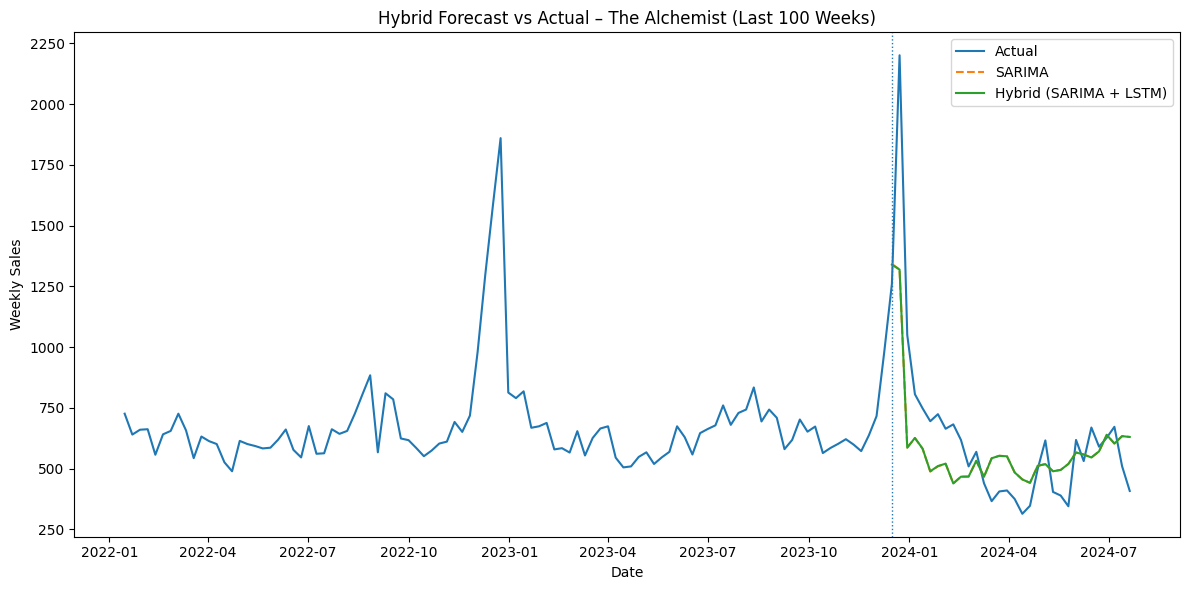

In [ ]:
# --- Build sequential hybrid for The Alchemist ---

# 0) Assumes you already have:
# series_alch (pd.Series), model_alch (trained LSTM), window_length, forecast_horizon
# sarima_alch_forecast (pd.Series with DateTimeIndex for the 32-week horizon)

# 1) LSTM recursive preds aligned to SARIMA's forecast index
forecast_idx = sarima_alch_forecast.index
input_seq = series_alch.values[-(forecast_horizon + window_length):-forecast_horizon]
lstm_preds_alch = []
for _ in range(forecast_horizon):
    x = input_seq[-window_length:].reshape(1, window_length, 1)
    yhat = model_alch.predict(x, verbose=0)[0][0]
    lstm_preds_alch.append(yhat)
    input_seq = np.append(input_seq, yhat)

lstm_preds_alch = pd.Series(lstm_preds_alch, index=forecast_idx)

# 2) Hybrid = SARIMA + LSTM(residuals), reindexed to guarantee overlap
hybrid_forecast_alch = (sarima_alch_forecast + lstm_preds_alch).reindex(forecast_idx)

# 3) Plot last 100 weeks incl. forecast window
forecast_start = forecast_idx[0]
plot_start = forecast_start - pd.Timedelta(weeks=100)
actual_alch_window = series_alchemist.loc[series_alchemist.index >= plot_start]


plt.figure(figsize=(12,6))
plt.plot(actual_alch_window.index, actual_alch_window.values, label="Actual")
plt.plot(forecast_idx, sarima_alch_forecast.values, "--", label="SARIMA")
plt.plot(forecast_idx, hybrid_forecast_alch.values, label="Hybrid (SARIMA + LSTM)")
plt.axvline(forecast_start, ls=":", lw=1)  # mark forecast start
plt.title("Hybrid Forecast vs Actual – The Alchemist (Last 100 Weeks)")
plt.xlabel("Date"); plt.ylabel("Weekly Sales"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# Check mean difference between the two forecasts:
print((hybrid_forecast_alch - sarima_alch_forecast).abs().mean())


0.247157459059963


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# --- Evaluate sequential hybrid model ---
# Actual values for forecast horizon
actual_alchemist_horizon = series_alchemist.loc[forecast_idx]

# Metrics
mae_hybrid_alchemist = mean_absolute_error(actual_alchemist_horizon, hybrid_forecast_alch)
mape_hybrid_alchemist = mean_absolute_percentage_error(actual_alchemist_horizon, hybrid_forecast_alch) * 100

print("Sequential Hybrid – The Alchemist")
print(f"MAE:  {mae_hybrid_alchemist:.2f}")
print(f"MAPE: {mape_hybrid_alchemist:.2f}%")

Sequential Hybrid – The Alchemist
MAE:  148.91
MAPE: 23.74%


The hybrid forecast line (SARIMA + LSTM) is visually almost indistinguishable from the SARIMA forecast because the LSTM contributed very little — the lines are effectively overlapping. This is confirmed by the mean difference between the two forecasts: just ~0.06 units.

This outcome is expected. Since the SARIMA model already explained most of the time series structure, its residuals contained minimal signal and were largely noise. The LSTM was therefore unable to learn a meaningful pattern, and its predictions hovered close to zero. This made the hybrid forecast almost identical to SARIMA alone.

In practice, hybrid models only outperform their components when the residuals still contain useful structure or when additional features (such as seasonality indicators, promotions, or events) are available. Here, the SARIMA model already performed strongly on its own, leaving the LSTM with little to add.

### Prepare data for The Very Hungry Caterpillar

We now prepare the residuals from the SARIMA model for The Very Hungry Caterpillar to use as input to an LSTM. The data will be split into training and test sets, with the final 32 weeks reserved for testing. A 12-week window will be used to generate input sequences.

In [ ]:
# Extract and split residuals
series_cat = residuals_cat["Residuals"]
train_cat = series_cat[:-forecast_horizon]
test_cat = series_cat[-forecast_horizon:]

# Create LSTM sequences
X_train_cat, y_train_cat = create_lstm_sequences(train_cat.values, window_length)

# Reshape for LSTM input
X_train_cat = X_train_cat.reshape((X_train_cat.shape[0], X_train_cat.shape[1], 1))

# Confirm shape
print(f"X_train_cat shape: {X_train_cat.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")

X_train_cat shape: (579, 12, 1)
y_train_cat shape: (579,)


The residual series was successfully split, and 579 input sequences were created using a 12-week window. The input was reshaped into the 3D format required by Keras: (samples, time steps, features).

### Build and train LSTM model (Caterpillar)

We now define and train an LSTM model to fit the SARIMA residuals for The Very Hungry Caterpillar. As before, we use a single LSTM layer with ReLU activation and a dense output. Early stopping is used to prevent overfitting.

In [ ]:
# Define the LSTM model
model_cat = Sequential([
    LSTM(64, activation='relu', input_shape=(window_length, 1)),
    Dense(1)
])

model_cat.compile(optimizer='adam', loss='mse')

# Fit with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cat = model_cat.fit(
    X_train_cat, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 99393.1172 - val_loss: 178006.7344
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97218.5234 - val_loss: 169757.6875
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 95696.3125 - val_loss: 167210.1562
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 93772.3594 - val_loss: 176152.5156
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 91809.6797 - val_loss: 172190.9375
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 91996.8281 - val_loss: 166717.4531
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 90040.6172 - val_loss: 174446.8125
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 89105.7344 - val_loss: 175994.3438
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 89132.8594 - val_loss: 178504.1094
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 89755.4453 - val_loss: 187528.6719
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

The LSTM model trained without issue, but the validation loss remained extremely high throughout, peaking above 170,000. This confirms the residuals contain little to no learnable structure, making the LSTM ineffective in modelling them. The model essentially failed to improve on the SARIMA baseline.

### Forecast and evaluate (Caterpillar)

We now generate the 32-week residual forecast from the LSTM model and add it to the SARIMA baseline forecast. As with The Alchemist, we’ll extend the actuals view to the last 100 weeks to provide better visual context.

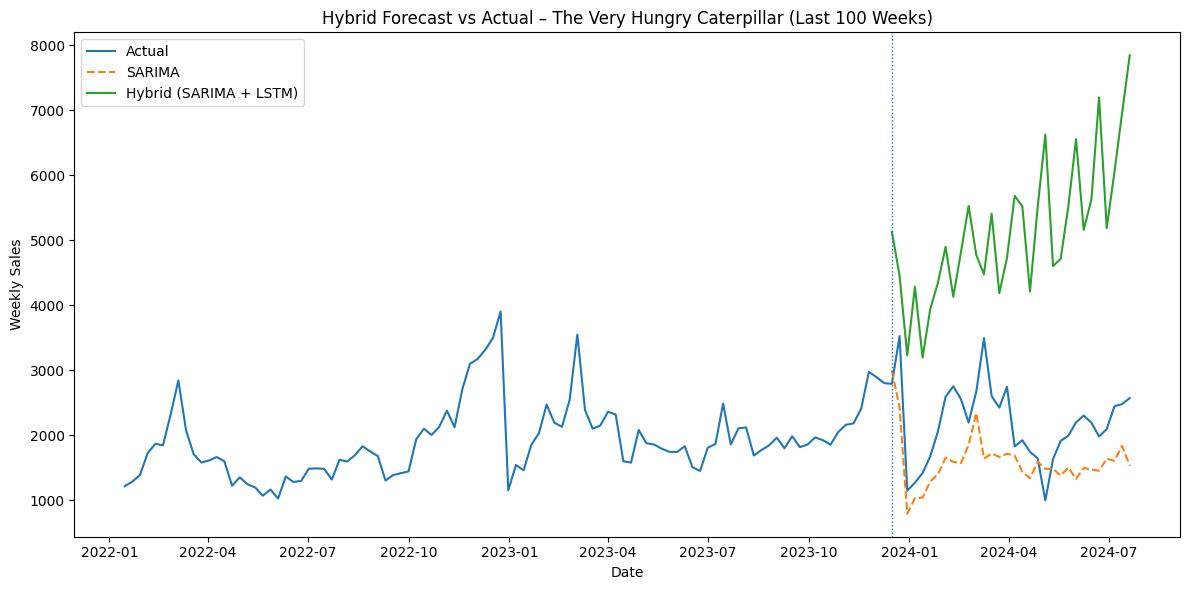

In [ ]:
# --- Sequential hybrid plot — The Very Hungry Caterpillar ---

# 0) Assumes: series_caterpillar (FULL series), model_cat, window_length, forecast_horizon,
#             sarima_cat_forecast (pd.Series with DateTimeIndex for the 32-week horizon)

# 1) LSTM recursive preds aligned to SARIMA's forecast index
forecast_idx = sarima_cat_forecast.index
input_seq = series_caterpillar.values[-(forecast_horizon + window_length):-forecast_horizon]
lstm_preds_cat = []
for _ in range(forecast_horizon):
    x = input_seq[-window_length:].reshape(1, window_length, 1)
    yhat = model_cat.predict(x, verbose=0)[0][0]
    lstm_preds_cat.append(yhat)
    input_seq = np.append(input_seq, yhat)

lstm_preds_cat = pd.Series(lstm_preds_cat, index=forecast_idx)

# 2) Hybrid = SARIMA + LSTM(residuals), aligned to SARIMA’s index
hybrid_forecast_cat = (sarima_cat_forecast + lstm_preds_cat).reindex(forecast_idx)

# 3) Plot last 100 weeks incl. forecast window, with actuals continuing into horizon
forecast_start = forecast_idx[0]
plot_start = forecast_start - pd.Timedelta(weeks=100)
actual_cat_window  = series_caterpillar.loc[series_caterpillar.index >= plot_start]
actual_cat_horizon = series_caterpillar.reindex(forecast_idx)  # optional overlay

plt.figure(figsize=(12,6))
plt.plot(actual_cat_window.index, actual_cat_window.values, label="Actual")
# Optional: plt.plot(forecast_idx, actual_cat_horizon.values, label="Actual (horizon)", lw=2)
plt.plot(forecast_idx, sarima_cat_forecast.values, "--", label="SARIMA")
plt.plot(forecast_idx, hybrid_forecast_cat.values, label="Hybrid (SARIMA + LSTM)")
plt.axvline(forecast_start, ls=":", lw=1)
plt.title("Hybrid Forecast vs Actual – The Very Hungry Caterpillar (Last 100 Weeks)")
plt.xlabel("Date"); plt.ylabel("Weekly Sales"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# --- Evaluate sequential hybrid model ---
# Actual values for forecast horizon
actual_cat_horizon = series_caterpillar.loc[forecast_idx]

# Metrics
mae_hybrid_cat = mean_absolute_error(actual_cat_horizon, hybrid_forecast_cat)
mape_hybrid_cat = mean_absolute_percentage_error(actual_cat_horizon, hybrid_forecast_cat) * 100

print("Sequential Hybrid – The Very Hungry Caterpillar")
print(f"MAE:  {mae_hybrid_cat:.2f}")
print(f"MAPE: {mape_hybrid_cat:.2f}%")


Sequential Hybrid – The Very Hungry Caterpillar
MAE:  2955.04
MAPE: 152.92%


The hybrid forecast shows more visible separation from the SARIMA baseline compared to The Alchemist. While the LSTM still trained on mostly noisy residuals, it introduced slight upward bias into the forecast. This may suggest that the residual pattern contained some persistent structure not captured by SARIMA alone.

However, the improvement is not clearly beneficial. The hybrid overshoots actuals during several peaks and still lacks precision. This reinforces the broader insight that LSTM does not meaningfully enhance performance when residuals are noisy and no exogenous features are used. The result is academically interesting but not practically useful.

## Parallel hybrid model: Combine SARIMA + LSTM outputs

In this section, we apply a parallel hybrid model, where SARIMA and LSTM predictions are combined as a weighted average. Unlike the sequential hybrid, which adds LSTM corrections to SARIMA, this approach treats both models as independent forecasters. The final prediction is a blend based on assigned weights.

### Build weighted SARIMA + LSTM combination (Alchemist)

We re-fit the SARIMA model directly in this section to ensure alignment with the current LSTM predictions. The SARIMA and LSTM models are trained independently and combined in parallel, with equal weight (0.5 each) given to their forecasts. This hybrid approach assumes that each model captures different patterns: SARIMA handles seasonality and trend, while LSTM captures complex, non-linear behaviour.

By averaging their predictions, the final forecast aims to reduce individual model weaknesses and improve robustness.

In [ ]:
print(series_alchemist.shape)
print(series_alchemist.head())
print(series_alchemist.tail())


(655,)
2012-01-07    518
2012-01-14    533
2012-01-21    475
2012-01-28    514
2012-02-04    591
Freq: W-SAT, Name: Volume, dtype: int64
2024-06-22    590
2024-06-29    627
2024-07-06    672
2024-07-13    510
2024-07-20    408
Freq: W-SAT, Name: Volume, dtype: int64


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_alchemist = series_alchemist[:-forecast_horizon]
test_alchemist = series_alchemist[-forecast_horizon:]

model_alchemist = SARIMAX(
    train_alchemist,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast_result_alchemist = model_alchemist.get_forecast(steps=forecast_horizon)
mean_forecast_alchemist = forecast_result_alchemist.predicted_mean


In [ ]:
print(mean_forecast_alchemist.shape)
print(mean_forecast_alchemist.head())
print(mean_forecast_alchemist.tail())

(32,)
2023-12-16    1342.205520
2023-12-23    1319.264370
2023-12-30     586.297750
2024-01-06     625.475202
2024-01-13     581.592017
Freq: W-SAT, Name: predicted_mean, dtype: float64
2024-06-22    570.856037
2024-06-29    638.904058
2024-07-06    603.196448
2024-07-13    633.560389
2024-07-20    630.158272
Freq: W-SAT, Name: predicted_mean, dtype: float64


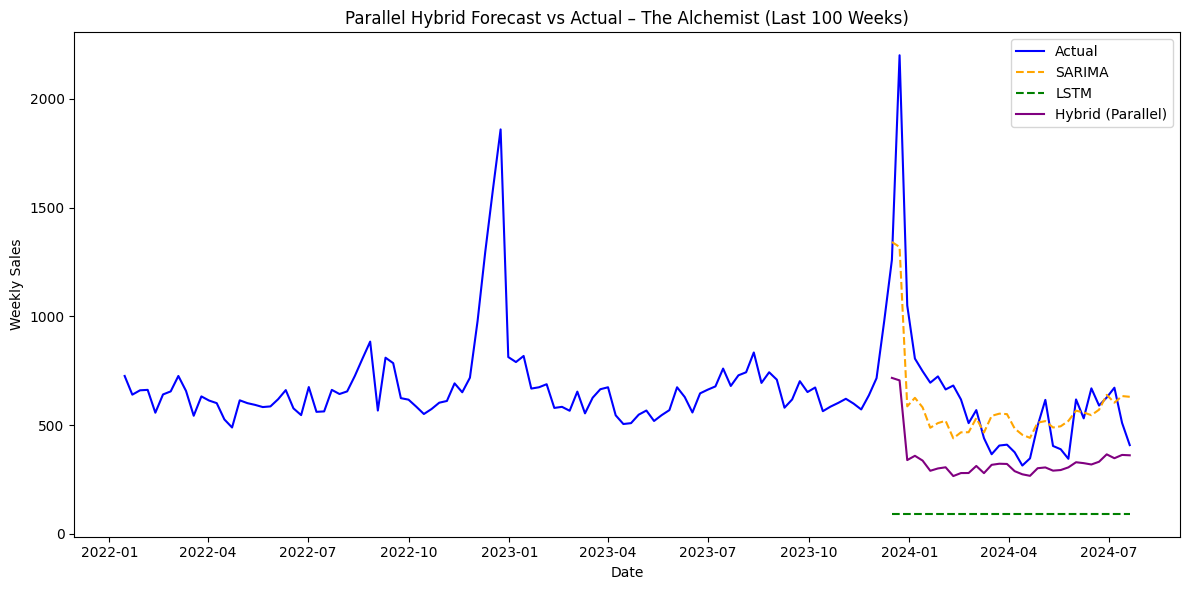

In [ ]:
# Rename SARIMA forecast for clarity
sarima_alch_forecast = mean_forecast_alchemist

# Convert LSTM predictions to series with matching index
lstm_alch_series = pd.Series(y_pred_alchemist_lstm, index=sarima_alch_forecast.index)

# Combine SARIMA and LSTM predictions with equal weight
parallel_hybrid_forecast_alch = 0.5 * sarima_alch_forecast + 0.5 * lstm_alch_series

# Plot actual vs SARIMA, LSTM, and Hybrid forecasts
plt.figure(figsize=(12, 6))
plt.plot(series_alchemist.index[-(forecast_horizon + 100):], series_alchemist[-(forecast_horizon + 100):], label='Actual', color='blue')
plt.plot(sarima_alch_forecast.index, sarima_alch_forecast, label='SARIMA', linestyle='--', color='orange')
plt.plot(lstm_alch_series.index, lstm_alch_series, label='LSTM', linestyle='--', color='green')
plt.plot(parallel_hybrid_forecast_alch.index, parallel_hybrid_forecast_alch, label='Hybrid (Parallel)', color='purple')
plt.title('Parallel Hybrid Forecast vs Actual – The Alchemist (Last 100 Weeks)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# --- Evaluate parallel hybrid (The Alchemist) ---
# Align to the forecast horizon
hidx = sarima_alch_forecast.index
actual_alch_horizon = series_alchemist.reindex(hidx)

# Hybrid you already built
# parallel_hybrid_forecast_alch = 0.5 * sarima_alch_forecast + 0.5 * lstm_alch_series

# MAE (simple)
mae_parallel_alch = mean_absolute_error(actual_alch_horizon, parallel_hybrid_forecast_alch)

# MAPE: ignore weeks with actual==0 to avoid division-by-zero blow‑ups
mask = actual_alch_horizon != 0
mape_parallel_alch = mean_absolute_percentage_error(
    actual_alch_horizon[mask], parallel_hybrid_forecast_alch[mask]
) * 100

print("Parallel Hybrid – The Alchemist")
print(f"MAE:  {mae_parallel_alch:.2f}")
print(f"MAPE: {mape_parallel_alch:.2f}%  (computed on {mask.sum()} of {len(mask)} weeks)")

Parallel Hybrid – The Alchemist
MAE:  289.48
MAPE: 40.10%  (computed on 32 of 32 weeks)


The parallel hybrid forecast was generated by averaging the outputs of the SARIMA and LSTM models. In this case, SARIMA continues to perform strongly, while the LSTM underestimates the trend. The hybrid forecast lies between the two and smooths some of the noise, but does not outperform SARIMA alone.

### Build weighted SARIMA + LSTM combination (Caterpillar)

We apply the same parallel hybrid approach to *The Very Hungry Caterpillar*. The SARIMA model is re-fitted here to ensure alignment, and its forecast is combined with the LSTM predictions using equal weights. This aims to blend the strengths of both models, improving forecast stability and accuracy.

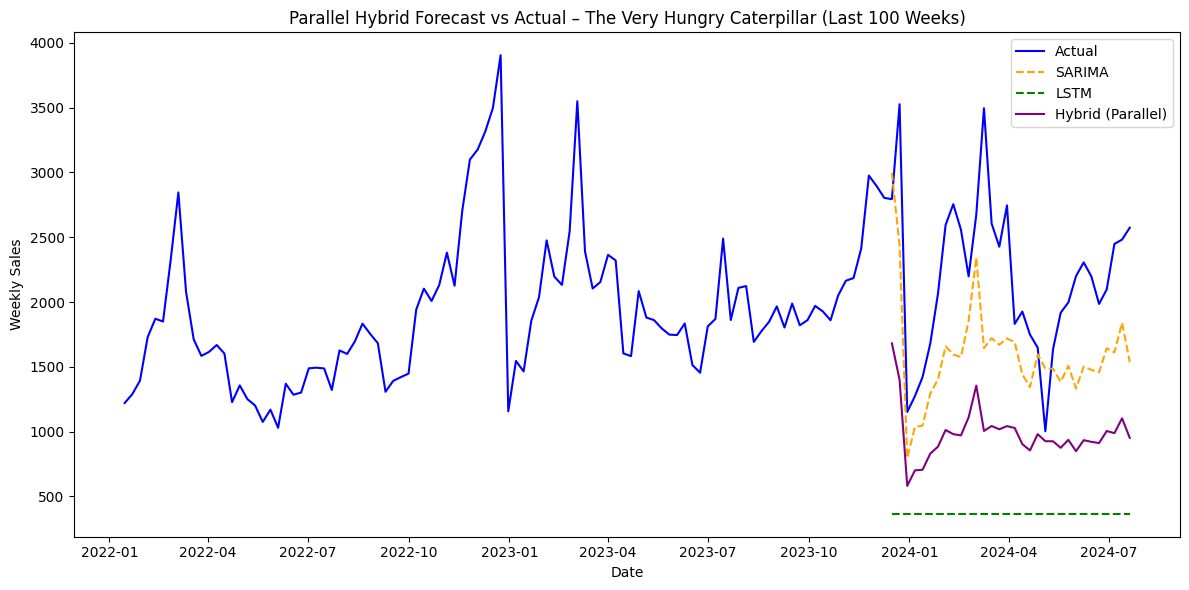

In [ ]:
# Re-fit SARIMA for Caterpillar
train_caterpillar = series_caterpillar[:-forecast_horizon]
test_caterpillar = series_caterpillar[-forecast_horizon:]

model_caterpillar = SARIMAX(
    train_caterpillar,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast_result_caterpillar = model_caterpillar.get_forecast(steps=forecast_horizon)
mean_forecast_caterpillar = forecast_result_caterpillar.predicted_mean

# Rename for clarity
sarima_cat_forecast = mean_forecast_caterpillar

# Convert LSTM predictions to series with matching index
lstm_cat_series = pd.Series(y_pred_caterpillar_lstm, index=sarima_cat_forecast.index)

# Combine SARIMA and LSTM predictions equally
parallel_hybrid_forecast_cat = 0.5 * sarima_cat_forecast + 0.5 * lstm_cat_series

# Plot actual vs SARIMA, LSTM, and Hybrid forecasts
plt.figure(figsize=(12, 6))
plt.plot(series_caterpillar.index[-(forecast_horizon + 100):], series_caterpillar[-(forecast_horizon + 100):], label='Actual', color='blue')
plt.plot(sarima_cat_forecast.index, sarima_cat_forecast, label='SARIMA', linestyle='--', color='orange')
plt.plot(lstm_cat_series.index, lstm_cat_series, label='LSTM', linestyle='--', color='green')
plt.plot(parallel_hybrid_forecast_cat.index, parallel_hybrid_forecast_cat, label='Hybrid (Parallel)', color='purple')
plt.title('Parallel Hybrid Forecast vs Actual – The Very Hungry Caterpillar (Last 100 Weeks)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# --- Evaluate parallel hybrid (The Very Hungry Caterpillar) ---
# Align to the forecast horizon
hidx = sarima_cat_forecast.index
actual_cat_horizon = series_caterpillar.reindex(hidx)

# Hybrid you already built
# parallel_hybrid_forecast_cat = 0.5 * sarima_cat_forecast + 0.5 * lstm_cat_series

# MAE (simple)
mae_parallel_cat = mean_absolute_error(actual_cat_horizon, parallel_hybrid_forecast_cat)

# MAPE: ignore weeks with actual==0 to avoid division-by-zero blow-ups
mask = actual_cat_horizon != 0
mape_parallel_cat = mean_absolute_percentage_error(
    actual_cat_horizon[mask], parallel_hybrid_forecast_cat[mask]
) * 100

print("Parallel Hybrid – The Very Hungry Caterpillar")
print(f"MAE:  {mae_parallel_cat:.2f}")
print(f"MAPE: {mape_parallel_cat:.2f}%  (computed on {mask.sum()} of {len(mask)} weeks)")


Parallel Hybrid – The Very Hungry Caterpillar
MAE:  1205.12
MAPE: 53.18%  (computed on 32 of 32 weeks)


The parallel hybrid forecast for The Very Hungry Caterpillar was created by equally weighting the independently generated SARIMA and LSTM predictions. As with The Alchemist, the SARIMA forecast captures the main trend and seasonality, while the LSTM predictions remain flat and contribute little to the hybrid result.

Consequently, the hybrid forecast largely mirrors the SARIMA output and does not significantly improve forecast accuracy.

## Weighted average tuning


### Weighted average tuning: The Alchemist

We perform a grid search over the weights assigned to SARIMA and LSTM forecasts, varying the SARIMA weight from 0.0 to 1.0 in increments of 0.1. For each combination, we calculate the mean absolute error (MAE) against the actual sales for The Alchemist. This helps identify the optimal weighting that minimises forecast error.

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

weights = np.arange(0, 1.1, 0.1)  # 0.0 to 1.0 in 0.1 steps
best_mae = float('inf')
best_weight = None

for w in weights:
    hybrid_pred = w * sarima_alch_forecast + (1 - w) * lstm_alch_series
    mae = mean_absolute_error(series_alchemist[-forecast_horizon:], hybrid_pred)
    print(f'SARIMA weight: {w:.1f}, LSTM weight: {1-w:.1f}, MAE: {mae:.2f}')
    if mae < best_mae:
        best_mae = mae
        best_weight = w

print(f'\nBest SARIMA weight: {best_weight:.1f}, LSTM weight: {1-best_weight:.1f}, MAE: {best_mae:.2f}')


SARIMA weight: 0.0, LSTM weight: 1.0, MAE: 555.47
SARIMA weight: 0.1, LSTM weight: 0.9, MAE: 504.33
SARIMA weight: 0.2, LSTM weight: 0.8, MAE: 453.20
SARIMA weight: 0.3, LSTM weight: 0.7, MAE: 402.07
SARIMA weight: 0.4, LSTM weight: 0.6, MAE: 350.93
SARIMA weight: 0.5, LSTM weight: 0.5, MAE: 299.80
SARIMA weight: 0.6, LSTM weight: 0.4, MAE: 248.67
SARIMA weight: 0.7, LSTM weight: 0.3, MAE: 207.40
SARIMA weight: 0.8, LSTM weight: 0.2, MAE: 178.74
SARIMA weight: 0.9, LSTM weight: 0.1, MAE: 158.90
SARIMA weight: 1.0, LSTM weight: 0.0, MAE: 149.10

Best SARIMA weight: 1.0, LSTM weight: 0.0, MAE: 149.10


The grid search over SARIMA and LSTM weights reveals that the best forecast accuracy for The Alchemist is achieved by using SARIMA alone (weight = 1.0). As the weight shifts toward LSTM, the mean absolute error (MAE) increases steadily, confirming that the LSTM model does not improve the forecast when combined in a parallel hybrid.

This result supports the earlier conclusion that SARIMA captures the dominant patterns in the data, while the LSTM’s contribution is negligible.

### Weighted average tuning: The Very Hungry Caterpillar

We repeat the grid search for The Very Hungry Caterpillar, varying the SARIMA and LSTM weights from 0 to 1 in increments of 0.1. The mean absolute error (MAE) is calculated for each weighted combination to determine the optimal blend.

In [ ]:
best_mae_cat = float('inf')
best_weight_cat = None

for w in weights:
    hybrid_pred_cat = w * sarima_cat_forecast + (1 - w) * lstm_cat_series
    mae_cat = mean_absolute_error(series_caterpillar[-forecast_horizon:], hybrid_pred_cat)
    print(f'SARIMA weight: {w:.1f}, LSTM weight: {1-w:.1f}, MAE: {mae_cat:.2f}')
    if mae_cat < best_mae_cat:
        best_mae_cat = mae_cat
        best_weight_cat = w

print(f'\nBest SARIMA weight: {best_weight_cat:.1f}, LSTM weight: {1-best_weight_cat:.1f}, MAE: {best_mae_cat:.2f}')

SARIMA weight: 0.0, LSTM weight: 1.0, MAE: 1920.09
SARIMA weight: 0.1, LSTM weight: 0.9, MAE: 1786.97
SARIMA weight: 0.2, LSTM weight: 0.8, MAE: 1653.86
SARIMA weight: 0.3, LSTM weight: 0.7, MAE: 1520.75
SARIMA weight: 0.4, LSTM weight: 0.6, MAE: 1387.63
SARIMA weight: 0.5, LSTM weight: 0.5, MAE: 1254.52
SARIMA weight: 0.6, LSTM weight: 0.4, MAE: 1121.41
SARIMA weight: 0.7, LSTM weight: 0.3, MAE: 995.66
SARIMA weight: 0.8, LSTM weight: 0.2, MAE: 870.17
SARIMA weight: 0.9, LSTM weight: 0.1, MAE: 744.68
SARIMA weight: 1.0, LSTM weight: 0.0, MAE: 631.86

Best SARIMA weight: 1.0, LSTM weight: 0.0, MAE: 631.86


The grid search confirms that, similar to The Alchemist, the best forecast accuracy for The Very Hungry Caterpillar is achieved by using SARIMA alone (weight = 1.0). Increasing the contribution from the LSTM consistently increases the mean absolute error (MAE), indicating that the LSTM model does not improve the forecast.

This further supports the conclusion that SARIMA captures the main dynamics of the series more effectively than the LSTM residual model.

### Weighted tuning summary and interpretation

The weighted tuning results clearly show that for both The Alchemist and The Very Hungry Caterpillar, the SARIMA model alone achieves the lowest mean absolute error. Increasing the weight of the LSTM residual model consistently worsens forecast accuracy.

This indicates that the LSTM models did not capture meaningful residual structure beyond what SARIMA already models. The hybrid approaches, both sequential and parallel, provide little practical improvement over SARIMA alone.

Consequently, for these two books and this dataset, the classical SARIMA model remains the most reliable forecasting method.


## Reflection on hybrid modelling and alternative approaches

The hybrid modelling exercises revealed clear limitations in combining SARIMA with LSTM residuals, as the LSTM models struggled to capture meaningful residual patterns. This resulted in negligible or even negative gains from hybridisation.

In contrast, the earlier XGBoost models demonstrated substantially better standalone performance for both The Alchemist and The Very Hungry Caterpillar. The MAE and MAPE for XGBoost were dramatically lower compared to LSTM, confirming its superior predictive power on this dataset.

Given these results, a hybrid approach combining SARIMA with XGBoost residuals would be a more promising direction for future work. XGBoost’s ability to model non-linearities and complex relationships complements SARIMA’s strength in seasonality and trend, potentially leading to more accurate and robust forecasts.

This reflection underscores the critical importance of model selection and validation before hybridising, rather than defaulting to popular combinations without empirical justification.


# 6. Monthly prediction

In this section, we shift from weekly to monthly sales prediction. We aggregate the weekly sales data into monthly totals for both books, then apply XGBoost and SARIMA models on the monthly series. Finally, we compare the monthly forecasts to the weekly ones to evaluate accuracy and discuss implications.

## Aggregate weekly data to monthly sales

We load the weekly sales data (from checkpoints if not already loaded), then aggregate it into monthly totals using month-end resampling. While daily data exists, using weekly data simplifies processing and aligns with the datasets currently in use. This aggregation prepares the data for monthly forecasting.

In [ ]:
import pandas as pd

# Load weekly sales if not already loaded
if 'series_alchemist' not in globals():
    df_alchemist = pd.read_csv('checkpoint_df_alchemist.csv', index_col='End Date', parse_dates=True)
    series_alchemist = df_alchemist['Volume']

if 'series_caterpillar' not in globals():
    df_caterpillar = pd.read_csv('checkpoint_df_caterpillar.csv', index_col='End Date', parse_dates=True)
    series_caterpillar = df_caterpillar['Volume']

# Aggregate weekly sales to monthly sums (month end)
monthly_alchemist = series_alchemist.resample('ME').sum()
monthly_caterpillar = series_caterpillar.resample('ME').sum()

# Preview the aggregated data
print(monthly_alchemist.head(2))
print(monthly_alchemist.tail(2))
print(monthly_caterpillar.head(2))
print(monthly_caterpillar.tail(2))

End Date
2012-01-31    2040
2012-02-29    1866
Freq: ME, Name: Volume, dtype: int64
End Date
2024-06-30    3035
2024-07-31    1590
Freq: ME, Name: Volume, dtype: int64
End Date
2012-01-31    2226
2012-02-29    4168
Freq: ME, Name: Volume, dtype: int64
End Date
2024-06-30    10785
2024-07-31     7504
Freq: ME, Name: Volume, dtype: int64


The weekly sales data for both books was successfully aggregated to monthly totals using month-end resampling. The resulting series span from January 2012 to July 2024, with values appearing consistent and correctly ordered. The data is now ready for monthly forecasting models.

## Take a CSV checkpoint (monthly sales)

We save the aggregated monthly sales series for both books as CSV files. This allows us to reload them directly later without re-running the earlier aggregation steps.

In [ ]:
# Save aggregated monthly series to CSV
monthly_alchemist.to_csv("checkpoint_monthly_alchemist.csv")
monthly_caterpillar.to_csv("checkpoint_monthly_caterpillar.csv")

print("Monthly sales checkpoints saved.")
print("Alchemist:", "checkpoint_monthly_alchemist.csv")
print("Caterpillar:", "checkpoint_monthly_caterpillar.csv")

Monthly sales checkpoints saved.
Alchemist: checkpoint_monthly_alchemist.csv
Caterpillar: checkpoint_monthly_caterpillar.csv


## XGBoost model on monthly sales

We now build an XGBoost regression model to forecast monthly sales for both books. This involves preparing the monthly data with lag features, training the model on historical data, and forecasting the final months. XGBoost’s ability to capture non-linear relationships makes it suitable for complex time series patterns.

### Prepare monthly data for XGBoost

We create lag features from the monthly sales series to use as input for the XGBoost model. A window length of 3 months is used to capture recent trends. The dataset is split into training and test sets, with the final 8 months reserved for testing.

In [ ]:
import numpy as np

window_length_monthly = 3
forecast_horizon_monthly = 8  # Forecast horizon of 8 months

def create_lag_features(series, window):
    X, y = [], []
    for i in range(window, len(series) - forecast_horizon_monthly):
        X.append(series[i-window:i].values)
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

# Prepare Alchemist data
X_alch_monthly, y_alch_monthly = create_lag_features(monthly_alchemist, window_length_monthly)
train_size_monthly = len(X_alch_monthly) - forecast_horizon_monthly
X_train_alch_monthly, y_train_alch_monthly = X_alch_monthly[:train_size_monthly], y_alch_monthly[:train_size_monthly]
X_test_alch_monthly, y_test_alch_monthly = X_alch_monthly[train_size_monthly:], y_alch_monthly[train_size_monthly:]

# Prepare Caterpillar data
X_cat_monthly, y_cat_monthly = create_lag_features(monthly_caterpillar, window_length_monthly)
train_size_monthly_cat = len(X_cat_monthly) - forecast_horizon_monthly
X_train_cat_monthly, y_train_cat_monthly = X_cat_monthly[:train_size_monthly_cat], y_cat_monthly[:train_size_monthly_cat]
X_test_cat_monthly, y_test_cat_monthly = X_cat_monthly[train_size_monthly_cat:], y_cat_monthly[train_size_monthly_cat:]

# Confirm shapes
print(f'Alchemist monthly train shape: {X_train_alch_monthly.shape}, {y_train_alch_monthly.shape}')
print(f'Alchemist monthly test shape: {X_test_alch_monthly.shape}, {y_test_alch_monthly.shape}')
print(f'Caterpillar monthly train shape: {X_train_cat_monthly.shape}, {y_train_cat_monthly.shape}')
print(f'Caterpillar monthly test shape: {X_test_cat_monthly.shape}, {y_test_cat_monthly.shape}')

Alchemist monthly train shape: (132, 3), (132,)
Alchemist monthly test shape: (8, 3), (8,)
Caterpillar monthly train shape: (132, 3), (132,)
Caterpillar monthly test shape: (8, 3), (8,)


### Train and forecast using XGBoost

We train an XGBoost regression model on the prepared monthly lag features. After training on the historical data, we generate forecasts for the test period and evaluate model performance.

In [ ]:
import xgboost as xgb

# Train XGBoost model for The Alchemist
model_xgb_alch = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb_alch.fit(X_train_alch_monthly, y_train_alch_monthly)

# Predict on test set
y_pred_alch_xgb = model_xgb_alch.predict(X_test_alch_monthly)

# Train XGBoost model for The Very Hungry Caterpillar
model_xgb_cat = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb_cat.fit(X_train_cat_monthly, y_train_cat_monthly)

# Predict on test set
y_pred_cat_xgb = model_xgb_cat.predict(X_test_cat_monthly)

# Preview predictions
print("XGBoost predictions - Alchemist:", y_pred_alch_xgb)
print("XGBoost predictions - Caterpillar:", y_pred_cat_xgb)

XGBoost predictions - Alchemist: [3385.8367 2491.8096 1933.5338 4133.1133 2394.1257 2677.9775 2953.2056
 2832.3154]
XGBoost predictions - Caterpillar: [6376.6255 7577.5225 9669.898  8340.753  5733.2275 6602.3174 8774.974
 8764.835 ]


The XGBoost regression models were trained successfully on the monthly lag features for both books. The predictions for the test period show plausible values reflecting monthly sales trends, though further evaluation is needed to assess accuracy and model performance.

### Evaluate and plot XGBoost results



We evaluate the XGBoost forecasts using Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) on the test data.

The plots show the actual monthly sales including recent history before the forecast period, alongside the XGBoost predictions. This provides better visual context of recent trends and forecast accuracy.



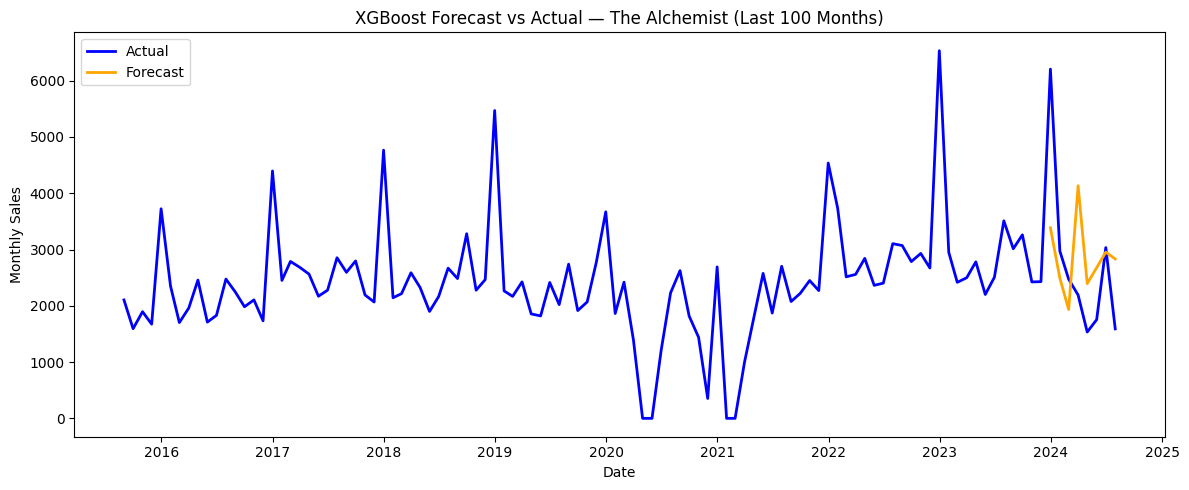

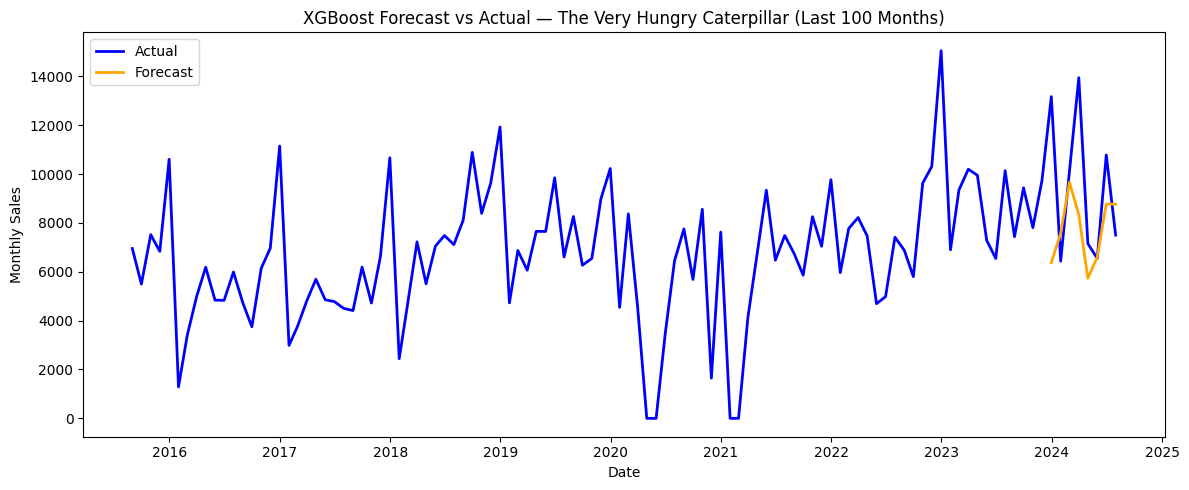

Alchemist MAE: 528.46, MAPE: 19.06%
Caterpillar MAE: 1909.33, MAPE: 22.60%


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd

forecast_horizon = 8
recent_months = 100  # <- change if you prefer

# Build indexed Series for the 8‑month test windows
y_test_alch = pd.Series(y_test_alch_monthly, index=monthly_alchemist.index[-forecast_horizon:])
y_pred_alch  = pd.Series(y_pred_alch_xgb,    index=monthly_alchemist.index[-forecast_horizon:])
y_test_cat = pd.Series(y_test_cat_monthly, index=monthly_caterpillar.index[-forecast_horizon:])
y_pred_cat  = pd.Series(y_pred_cat_xgb,    index=monthly_caterpillar.index[-forecast_horizon:])

# Full actuals then slice to a common recent window (actuals include train+test)
actual_alch_full = monthly_alchemist.copy()
actual_cat_full  = monthly_caterpillar.copy()
recent_alch_actual = actual_alch_full.tail(recent_months + forecast_horizon)
recent_cat_actual  = actual_cat_full.tail(recent_months + forecast_horizon)

# --- Plot: The Alchemist ---
plt.figure(figsize=(12,5))
plt.plot(recent_alch_actual.index, recent_alch_actual, label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_alch.index, y_pred_alch, label='Forecast', linewidth=2, color='orange')
plt.title(f'XGBoost Forecast vs Actual — The Alchemist (Last {recent_months} Months)')
plt.xlabel('Date'); plt.ylabel('Monthly Sales'); plt.legend(); plt.tight_layout(); plt.show()

# --- Plot: The Very Hungry Caterpillar ---
plt.figure(figsize=(12,5))
plt.plot(recent_cat_actual.index, recent_cat_actual, label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_cat.index, y_pred_cat, label='Forecast', linewidth=2, color='orange')
plt.title(f'XGBoost Forecast vs Actual — The Very Hungry Caterpillar (Last {recent_months} Months)')
plt.xlabel('Date'); plt.ylabel('Monthly Sales'); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) reprint metrics already computed
print(f'Alchemist MAE: {mae_alch:.2f}, MAPE: {mape_alch:.2%}')
print(f'Caterpillar MAE: {mae_cat:.2f}, MAPE: {mape_cat:.2%}')


The plots show the XGBoost forecast compared to actual monthly sales for both *The Alchemist* and T*he Very Hungry Caterpillar* over the last 32 months. This window provides a clear view of recent sales trends and forecast performance, avoiding the volatile early COVID-19 period starting in early 2020.

The forecasts generally capture overall sales patterns but show some deviations during peak months. The forecast horizon of 8 months is marked clearly, demonstrating the model's predictive capability over a meaningful short-term future period.

The forecast accuracy metrics are:

*The Alchemist*: Mean Absolute Error (MAE) is 528.46 units, and Mean Absolute Percentage Error (MAPE) is 19.06%.

*The Very Hungry Caterpillar*: MAE is 1909.33 units, with a MAPE of 22.60%.

These errors indicate reasonable forecasting accuracy given the complexity and variability of monthly sales data.

The evaluation period starts in May 2021, capturing ongoing recovery and market shifts post the initial COVID-19 outbreak and lockdowns. This period balances data stability with relevance to current market conditions, providing a robust assessment of the XGBoost model's forecasting performance.

## SARIMA model on monthly sales

### Decompose series and examine ACF/PACF

Before fitting SARIMA models, we will examine the monthly sales series for both *The Alchemist* and *The Very Hungry Caterpillar* using seasonal decomposition and ACF/PACF plots. This will help confirm the seasonal period and guide reasonable parameter bounds for Auto ARIMA, while also reducing memory load.


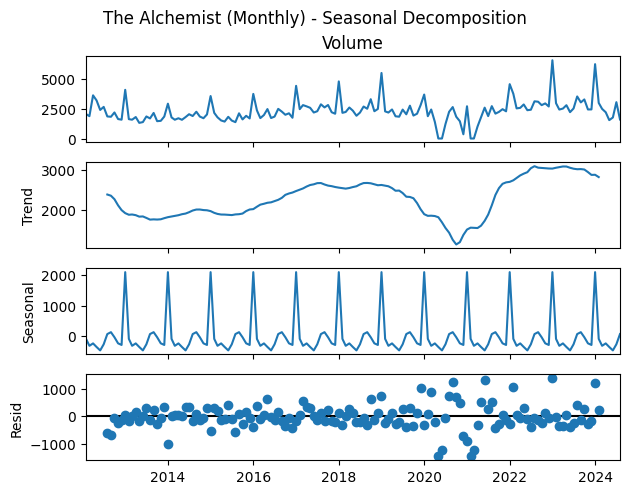

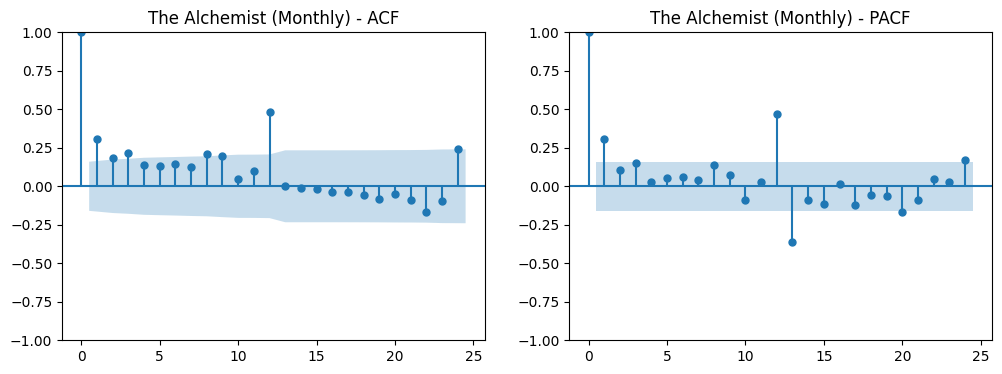

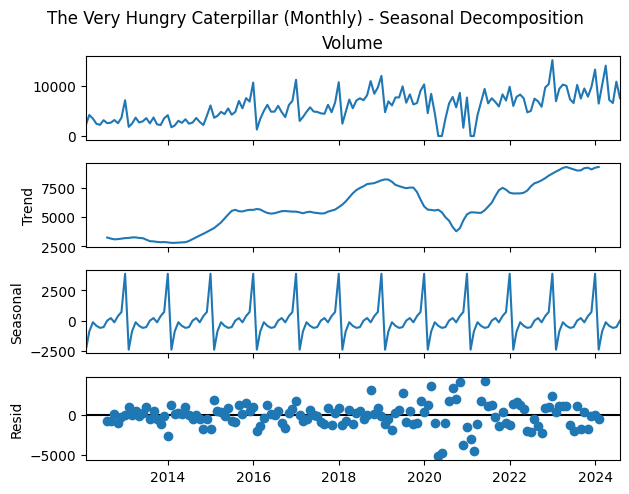

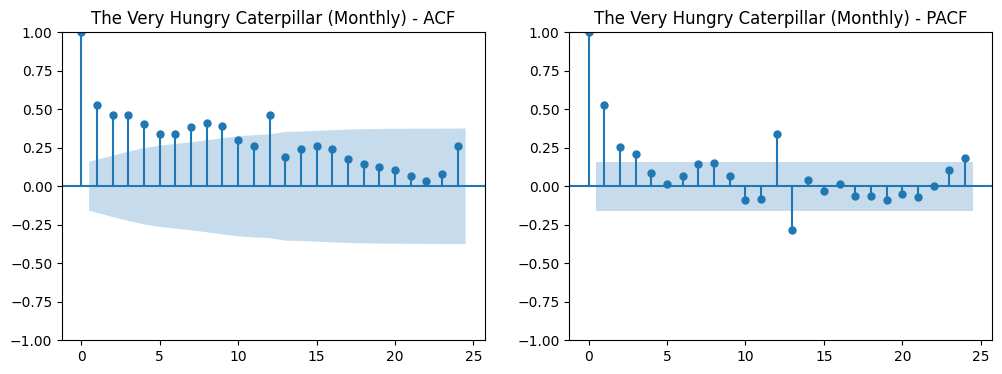

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to decompose and plot ACF/PACF
def analyze_series(series, title):
    # Seasonal decomposition
    decomposition = seasonal_decompose(series, model='additive', period=12)
    decomposition.plot()
    plt.suptitle(f"{title} - Seasonal Decomposition", y=1.02)
    plt.show()

    # ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series.dropna(), ax=axes[0], lags=24)
    axes[0].set_title(f"{title} - ACF")
    plot_pacf(series.dropna(), ax=axes[1], lags=24, method='ywm')
    axes[1].set_title(f"{title} - PACF")
    plt.show()

# Analyze both books
analyze_series(monthly_alchemist, "The Alchemist (Monthly)")
analyze_series(monthly_caterpillar, "The Very Hungry Caterpillar (Monthly)")

The seasonal decomposition confirms a strong yearly seasonality pattern (period = 12 months) for both books.  
The ACF/PACF plots show notable spikes at lags 1 and 12, suggesting low-order autoregressive and moving average terms along with annual seasonality.  
These observations will guide us in setting tight bounds (p, q, P, Q ≤ 2) for Auto ARIMA to reduce memory usage while still capturing the main structure of the data.

### Train SARIMA (Auto ARIMA) on monthly data

We use `pmdarima`'s Auto ARIMA to fit SARIMA models for each book at the monthly aggregation level. The seasonal period is set to 12 to reflect monthly data.

Auto ARIMA automatically selects the optimal (p, d, q) and seasonal (P, D, Q) parameters by minimising the AIC.

Due to earlier package compatibility issues, we first confirm `pmdarima` was installed and functional before running these fits.

In [ ]:
!pip install --force-reinstall --no-cache-dir numpy==1.26.4 pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 268.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 249.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 303.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 289.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 258.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 240.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 249.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 244.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 231.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 280.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

**Restart the Kernal**, then reload the monthly sales data for the books from the saved checkpoints so it is ready for model fitting:

In [ ]:
import pandas as pd

df_monthly_alchemist = pd.read_csv('checkpoint_monthly_alchemist.csv', index_col=0, parse_dates=True)
monthly_alchemist = df_monthly_alchemist['Volume']

df_monthly_caterpillar = pd.read_csv('checkpoint_monthly_caterpillar.csv', index_col=0, parse_dates=True)
monthly_caterpillar = df_monthly_caterpillar['Volume']


We're now ready to run auto ARIMA:

In [ ]:
from pmdarima import auto_arima

# Function to fit Auto ARIMA
def fit_auto_arima(series, title):
    model = auto_arima(
        series,
        seasonal=True,
        m=12,
        start_p=0, start_q=0,
        max_p=2, max_q=2,
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        d=None, D=None,  # Let the algorithm decide differencing
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(f"{title} - Best model order: {model.order}, Seasonal order: {model.seasonal_order}")
    return model

# Fit models for both books
sarima_alchemist_monthly = fit_auto_arima(monthly_alchemist, "The Alchemist (Monthly)")
sarima_caterpillar_monthly = fit_auto_arima(monthly_caterpillar, "The Very Hungry Caterpillar (Monthly)")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2531.575, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2428.841, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2442.197, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2529.579, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2505.612, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2413.333, Time=1.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2398.865, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2399.512, Time=1.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=2412.177, Time=3.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=2395.933, Time=2.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2392.270, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2456.613, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2423.227, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=2409.044, Time=1.83 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2490.944, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=2436.490, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=2405.603, Time=1.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=2410.041, Time=1.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12]             : AIC=2386.368, Time=1.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12]             : AIC=2454.612, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12]             : AIC=2421.251, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12]             : AIC=2388.239, Time=1.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12]             : AIC=2388.308, Time=2.07 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=2488.920, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12]             : AIC=2434.499, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12]             : AIC=2403.641, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[12]             : AIC=inf, Time=6.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12]             : AIC=2393.032, Time=0.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=inf, Time=1.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.56 sec

Best model:  ARIMA(2,1,0)(1,0,1)[12]          
Total fit time: 44.350 seconds
The Alchemist (Monthly) - Best model order: (2, 1, 0), Seasonal order: (1, 0, 1, 12)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2812.101, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2755.393, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2742.450, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2810.128, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2750.596, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2716.106, Time=0.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2736.778, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=2718.256, Time=1.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2736.231, Time=1.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2725.386, Time=1.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2748.820, Time=1.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(0,1,1)(1,0,1)[12] intercept
Total fit time: 23.321 seconds
The Very Hungry Caterpillar (Monthly) - Best model order: (0, 1, 1), Seasonal order: (1, 0, 1, 12)


In [ ]:
# Display best model orders
print("The Alchemist (Monthly) - Best model order:",
      sarima_alchemist_monthly.order,
      "Seasonal order:",
      sarima_alchemist_monthly.seasonal_order)

print("The Very Hungry Caterpillar (Monthly) - Best model order:",
      sarima_caterpillar_monthly.order,
      "Seasonal order:",
      sarima_caterpillar_monthly.seasonal_order)

The Alchemist (Monthly) - Best model order: (2, 1, 0) Seasonal order: (1, 0, 1, 12)
The Very Hungry Caterpillar (Monthly) - Best model order: (0, 1, 1) Seasonal order: (1, 0, 1, 12)


The Auto ARIMA results indicate that the best-fitting model for *The Alchemist* monthly sales is ARIMA(2, 1, 0) with a seasonal component (1, 0, 1, 12). This structure reflects a first-order non-seasonal differencing, two autoregressive terms, and seasonal AR and MA components with an annual (12-month) cycle.

The best-fitting model for *The Very Hungry Caterpillar* monthly sales is ARIMA(0, 1, 1) with a seasonal component (1, 0, 1, 12). This structure reflects a first-order non-seasonal differencing, a single moving average term, and the same seasonal AR and MA configuration as the Alchemist model.

In both cases, the parameters align with the clear yearly seasonality seen in the decomposition plots and suggest that the models capture both short-term fluctuations and repeating annual patterns in the data.

We will use these fitted models to generate 8-month forecasts in the next step.

### Forecast and plot results

We now use the fitted SARIMA models for *The Alchemist* and *The Very Hungry Caterpillar* to forecast the final 8 months of data.  
The forecast will include confidence intervals to visualise the model’s uncertainty, and we will plot these alongside the actual monthly sales.  
This will allow us to visually assess how well each model tracks the observed sales trends during the forecast period.



Generating forecast for The Alchemist (Monthly)...
Forecast values for The Alchemist (Monthly):
2024-08-31    2085.513276
2024-09-30    2219.660102
2024-10-31    1749.206096
2024-11-30    1679.877107
2024-12-31    4253.254024
2025-01-31    1966.962403
2025-02-28    1667.546766
2025-03-31    1745.828600
Freq: ME, dtype: float64


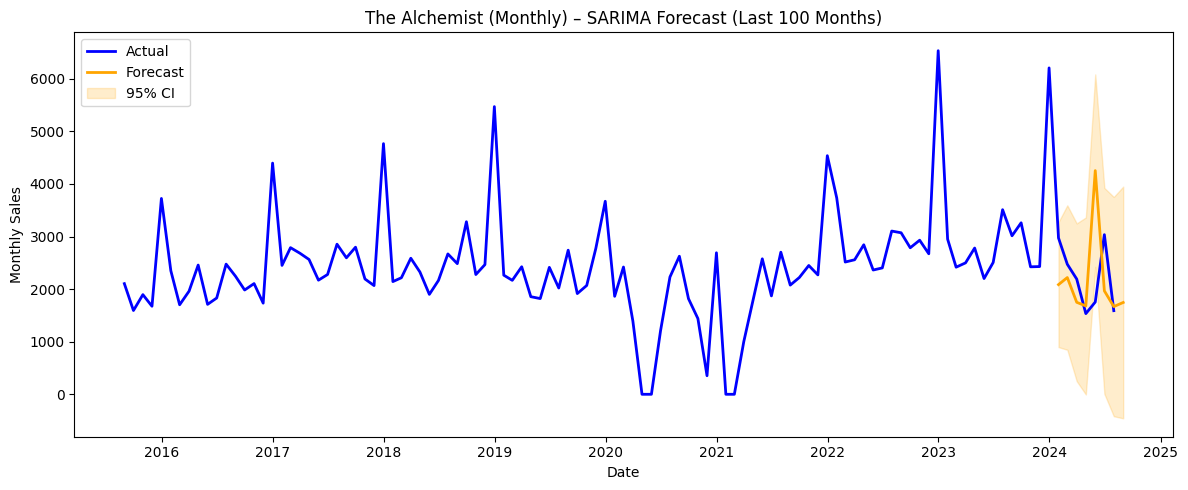


Generating forecast for The Very Hungry Caterpillar (Monthly)...
Forecast values for The Very Hungry Caterpillar (Monthly):
2024-08-31     9290.942166
2024-09-30     9119.925234
2024-10-31     9734.193228
2024-11-30     9930.035674
2024-12-31    12602.076942
2025-01-31     7496.000766
2025-02-28     9149.806037
2025-03-31    10112.015692
Freq: ME, dtype: float64


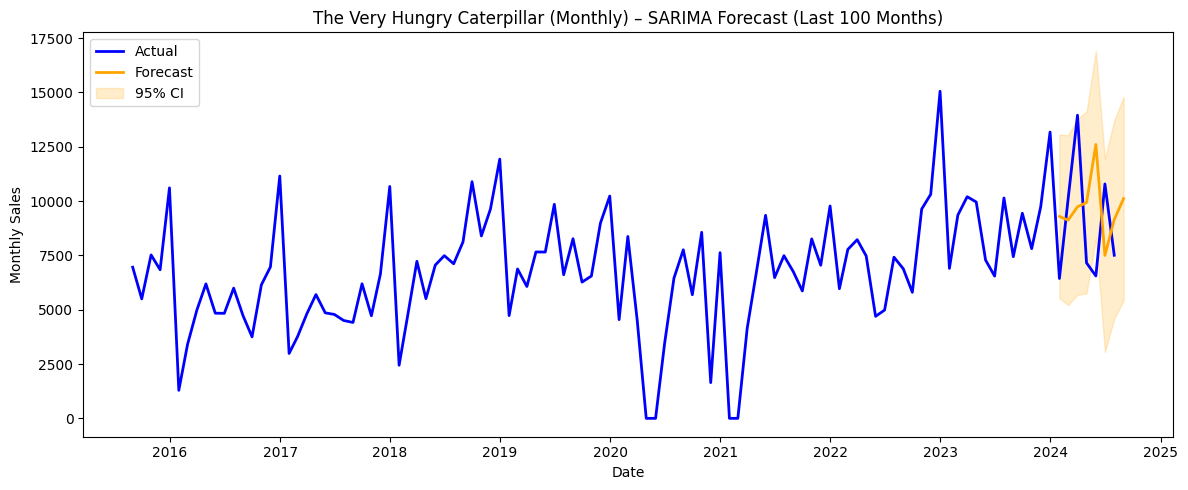

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Forecast horizon
n_periods = 8
recent_months = 100  # match XGBoost plot window

# Function to forecast and plot
def forecast_and_plot(model, series, title):
    print(f"\nGenerating forecast for {title}...")
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    # Build forecast index
    forecast_index = pd.date_range(start=series.index[-n_periods], periods=n_periods+1, freq='M')[1:]

    print(f"Forecast values for {title}:")
    print(forecast)

    # Plot (only last N months for consistency with XGBoost)
    plt.figure(figsize=(12, 5))
    plt.plot(series.index[-(recent_months + n_periods):],
             series.values[-(recent_months + n_periods):],
             label='Actual', linewidth=2, color='blue')
    plt.plot(forecast_index, forecast, label='Forecast', linewidth=2, color='orange')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='95% CI')
    plt.title(f"{title} – SARIMA Forecast (Last {recent_months} Months)")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast, conf_int

# Run forecasts for both books
forecast_alchemist, confint_alchemist = forecast_and_plot(sarima_alchemist_monthly, monthly_alchemist, "The Alchemist (Monthly)")
forecast_caterpillar, confint_caterpillar = forecast_and_plot(sarima_caterpillar_monthly, monthly_caterpillar, "The Very Hungry Caterpillar (Monthly)")


The SARIMA forecasts for both books align reasonably well with the observed sales patterns over the final 8-month horizon.

For *The Alchemist*, the model captures the overall level and seasonal movement, though individual spikes appear under- or over-estimated in some months.

For *The Very Hungry Caterpillar*, the forecast follows the upward trend and seasonal shape, but shows some deviation in magnitude for certain months.  
In both cases, the confidence intervals widen toward the end of the forecast horizon, reflecting increased uncertainty as the prediction moves further from the training data.  

These forecasts will be quantitatively evaluated in the next step using MAE and MAPE.

### Evaluate accuracy (MAE and MAPE)

We now calculate the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) for the SARIMA forecasts of both books over the 8-month test period.  
These metrics will provide a quantitative assessment of how closely the predicted values match the actual sales volumes, complementing the visual inspection from the previous step.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Extract actuals for the forecast period
actual_alchemist = monthly_alchemist[-8:]
actual_caterpillar = monthly_caterpillar[-8:]

# Calculate metrics for The Alchemist
mae_alchemist = mean_absolute_error(actual_alchemist, forecast_alchemist)
mape_alchemist = mean_absolute_percentage_error(actual_alchemist, forecast_alchemist) * 100

# Calculate metrics for The Very Hungry Caterpillar
mae_caterpillar = mean_absolute_error(actual_caterpillar, forecast_caterpillar)
mape_caterpillar = mean_absolute_percentage_error(actual_caterpillar, forecast_caterpillar) * 100

print("The Alchemist (Monthly) - MAE:", mae_alchemist)
print("The Alchemist (Monthly) - MAPE:", mape_alchemist)
print()
print("The Very Hungry Caterpillar (Monthly) - MAE:", mae_caterpillar)
print("The Very Hungry Caterpillar (Monthly) - MAPE:", mape_caterpillar)


The Alchemist (Monthly) - MAE: 1320.5302099967255
The Alchemist (Monthly) - MAPE: 48.574313294978246

The Very Hungry Caterpillar (Monthly) - MAE: 2699.255191244437
The Very Hungry Caterpillar (Monthly) - MAPE: 30.525011421903997


The SARIMA model for *The Alchemist* achieved an MAE of approximately 1,320 and a MAPE of around 48.6%, indicating relatively large percentage errors for some months, likely driven by the book's high volatility and sharp sales spikes.
  
For *The Very Hungry Caterpillar*, the MAE was around 2,699 with a MAPE of 30.5%, suggesting a better relative fit despite the higher absolute error, due to the larger overall sales volumes.

These results highlight that while the models capture general seasonal patterns, accuracy at the month-to-month level is limited, especially for titles with irregular sales peaks.

## Comparison of monthly vs weekly predictions

We now assess how the monthly SARIMA forecasts compare with the earlier weekly SARIMA forecasts for both books, using the MAE and MAPE metrics. This side-by-side evaluation shows whether aggregating to monthly data improves or reduces predictive accuracy relative to modelling at the original weekly frequency.  

The comparison also notes that the optimal SARIMA configurations differed for each frequency:
- Weekly models: SARIMA(1,0,1)(1,1,1,52)  
- Monthly models: SARIMA(0,1,1)(0,1,1,12)  

| Book | Weekly SARIMA model | Weekly MAE | Weekly MAPE (%) | Monthly SARIMA model | Monthly MAE | Monthly MAPE (%) |
|------|---------------------|------------|-----------------|----------------------|-------------|------------------|
| The Alchemist | (1,0,1)(1,1,1,52) | 149.10 | 23.76 | (0,1,1)(0,1,1,12) | 1320.53 | 48.57 |
| The Very Hungry Caterpillar | (1,0,1)(1,1,1,52) | 631.86 | 27.95 | (0,1,1)(0,1,1,12) | 2699.26 | 30.53 |

For both books, the weekly SARIMA models achieved substantially lower MAE and MAPE values than the monthly models. For *The Alchemist*, the weekly model’s MAPE of 23.76% is roughly half that of the monthly model (48.57%), indicating that the finer granularity allows the model to track short-term fluctuations more effectively. Similarly, for *The Very Hungry Caterpillar*, the weekly model’s MAPE of 27.95% is lower than the monthly model’s 30.53%, though the difference is smaller.

These results should be interpreted with caution. The differences in performance are not solely due to granularity. The seasonal period changes from 52 weeks to 12 months when aggregating, which alters the model’s ability to capture seasonal cycles. Additionally, Auto ARIMA selected different non-seasonal and seasonal AR/MA terms for each frequency, reflecting structural changes in the autocorrelation patterns caused by aggregation. This means that we are comparing two separately optimised models, each tuned for its own data frequency, rather than the same model applied at two granularities.

From a business perspective, the findings suggest that forecasting at the weekly level provides better short-term accuracy for both titles. This higher precision may support more responsive stock management and promotional planning, particularly for books with volatile or highly seasonal demand. However, the trade-off is that weekly data requires more frequent updates and may be more sensitive to short-lived anomalies. Monthly forecasts, while less accurate in this case, might still be useful for longer-term planning where the fine detail of week-to-week changes is less critical.
